# Names: #
# Ron Libman 211540265 #
# Project Name: Exploring Mental Health Data #

# Background & Introduction #

This goal of this project is to use data from a mental health survey to explore factors that may cause individuals to experience depression.

By looking at variables such as age, work pressure, and dietary habits, we will look for patterns and correlations that might explain causes of depression. Understanding causes for depression is crucial, as it can improve mental health support systems, and help develop methods for better treatment. Amid growing mental health concern around the western world it is important to assure the well being of people and communities.

To achieve this goal we will need to process and clean the given data, perform some exploratory data analysis and create a classification model to determine whether a given person has depression or not.

Link to the Kaggle project: https://www.kaggle.com/competitions/playground-series-s4e11/overview

## Some information about the dataset: ##
1. The dataset contains statistics from mental health surveys, with the target variable being "Depression". The target variable is binary - its value is either 1 (the respondent has depression) or 0 (the respondent does not have depression).
2. The train set contains 140,700 different records.
3. Each record has 16 features (initially) and 1 target feature (Depression).

## The most important question we want to answer in this project is how accurately we can predict whether a person has depression. Since the Kaggle scoring system in this project is based on accuracy score, we will seek to make optimize this metric (although we will definitely try other metrics as well). ##

# Installations and Imports #

In [1]:
!pip install shap
!pip install optuna
!pip install autogluon


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Ignored the following versions that require a different python version: 0.1.0 Requires-Python >=3.6, <3.9; 0.1.0b20210207 Requires-Python >=3.6, <3.8; 0.1.0b20210208 Requires-Python >=3.6, <3.8; 0.1.0b20210209 Requires-Python >=3.6, <3.8; 0.1.0b20210210 Requires-Python >=3.6, <3.8; 0.1.0b20210211 Requires-Python >=3.6, <3.8; 0.1.0b20210212 Requires-Python >=3.6, <3.8; 0.1.0b20210213 Requires-Python >=3.6, <3.8; 0.1.0b20210214 Requires-Python >=3.6, <3.8; 0.1.0b20210215 Requires-Python >=3.6, <3.8; 0.1.0b20210216 Requires-Python >=3.6, <3.8; 0.1.0b20210217 Requires-Python >=3.6, <3.8; 0.1.0b20210218 Requires-Python >=3.6, <3.8; 0.1.0b20210219 Requires-Python >=3.6, <3.8; 0.1.0b20210220 Requires-Python >=3.6, <3.8; 0.1.0b20210221 Requires-Python >=3.6, <3.8; 0.1.0b20210222 Requires-Python >=3.6, <3.8; 0.1.0b20210223 Requires-Python >=3.6, <3.8; 0.1.0b20210

In [102]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, chi2_contingency

from sklearn.datasets import make_classification
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, LabelEncoder
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    average_precision_score, mean_squared_error, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

import optuna

import shap

from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common import space

# Loading, Processing and Cleaning the Data #

**First we will load the dataset with pandas and see a small sample of it
using the head() function**

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

df = pd.read_csv('train.csv')

df.head()

id      Name  Gender   Age           City Working Professional or Student  \
0   0  Aaradhya  Female  49.0       Ludhiana            Working Professional   
1   1     Vivan    Male  26.0       Varanasi            Working Professional   
2   2    Yuvraj    Male  33.0  Visakhapatnam                         Student   
3   3    Yuvraj    Male  22.0         Mumbai            Working Professional   
4   4      Rhea  Female  30.0         Kanpur            Working Professional   

         Profession  Academic Pressure  Work Pressure  CGPA  \
0              Chef                NaN            5.0   NaN   
1           Teacher                NaN            4.0   NaN   
2               NaN                5.0            NaN  8.97   
3           Teacher                NaN            5.0   NaN   
4  Business Analyst                NaN            1.0   NaN   

   Study Satisfaction  Job Satisfaction     Sleep Duration Dietary Habits  \
0                 NaN               2.0  More than 8 hours        Healthy   
1                 NaN               3.0  Less than 5 hours      Unhealthy   
2                 2.0               NaN          5-6 hours        Healthy   
3                 NaN               1.0  Less than 5 hours       Moderate   
4                 NaN               1.0          5-6 hours      Unhealthy   

    Degree Have you ever had suicidal thoughts ?  Work/Study Hours  \
0      BHM                                    No               1.0   
1      LLB                                   Yes               7.0   
2  B.Pharm                                   Yes               3.0   
3      BBA                                   Yes              10.0   
4      BBA                                   Yes               9.0   

   Financial Stress Family History of Mental Illness  Depression  
0               2.0                               No           0  
1               3.0                               No           1  
2               1.0                               No           1  
3               1.0                              Yes           1  
4               4.0                              Yes           0

**The next step will be to remove duplicate values from the DataFrame that may cause our model
to overfit. We will also remove the ID and Name columns, as they are meaningless as features.
Also, we will check if there are any null values.**

In [4]:
"""
Duplicates are an extreme case of nonrandom sampling, and they may bias our fitted model.
Including them will essentially lead to the model overfitting this subset of points.
"""

df.drop_duplicates(inplace=True)

df.drop(columns=['id', 'Name'], inplace=True)

# Checking if there are null values
df.isnull().sum()

Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64

**There are many null values in the features that are related to work and study, because most students don't work and most people who work don't study. Now let's explore some basic information about the dataset:**

In [5]:
print("""The dataset contains features about %s people,
each person has %s features. I.E the size of the DataFrame is %s.""" % (df.shape[0],
                                                                                    df.shape[1] - 1,
                                                                                    df.shape))

The dataset contains features about 140700 people,
each person has 17 features. I.E the size of the DataFrame is (140700, 18).


In [6]:
print("The type of data stored in each column:")
types = df.dtypes.to_dict()
types_dict = {}
for i, v in types.items():
    types_dict[v] = [i] if v not in types_dict.keys() else types_dict[v] + [i]
types_dict

The type of data stored in each column:


{dtype('O'): ['Gender',
  'City',
  'Working Professional or Student',
  'Profession',
  'Sleep Duration',
  'Dietary Habits',
  'Degree',
  'Have you ever had suicidal thoughts ?',
  'Family History of Mental Illness'],
 dtype('float64'): ['Age',
  'Academic Pressure',
  'Work Pressure',
  'CGPA',
  'Study Satisfaction',
  'Job Satisfaction',
  'Work/Study Hours',
  'Financial Stress'],
 dtype('int64'): ['Depression']}

In [7]:
df.describe()

Age  Academic Pressure  Work Pressure          CGPA  \
count  140700.000000       27897.000000  112782.000000  27898.000000   
mean       40.388621           3.142273       2.998998      7.658636   
std        12.384099           1.380457       1.405771      1.464466   
min        18.000000           1.000000       1.000000      5.030000   
25%        29.000000           2.000000       2.000000      6.290000   
50%        42.000000           3.000000       3.000000      7.770000   
75%        51.000000           4.000000       4.000000      8.920000   
max        60.000000           5.000000       5.000000     10.000000   

       Study Satisfaction  Job Satisfaction  Work/Study Hours  \
count        27897.000000     112790.000000     140700.000000   
mean             2.944940          2.974404          6.252679   
std              1.360197          1.416078          3.853615   
min              1.000000          1.000000          0.000000   
25%              2.000000          2.000000          3.000000   
50%              3.000000          3.000000          6.000000   
75%              4.000000          4.000000         10.000000   
max              5.000000          5.000000         12.000000   

       Financial Stress     Depression  
count     140696.000000  140700.000000  
mean           2.988983       0.181713  
std            1.413633       0.385609  
min            1.000000       0.000000  
25%            2.000000       0.000000  
50%            3.000000       0.000000  
75%            4.000000       0.000000  
max            5.000000       1.000000

## Adding external features ##

**While the existing features are not bad, it would be interesting to try and build on them and get more information. For example, we have the feature "Profession" - it would be interesting, for exmaple, to create a feature of the average salary for this profession. This way, the feature will not only be a category without context, but also something quantative like money.**

**City Features - for each city in the data, let's add featrues that can shed light about the quality of life there: state, population, literacy rate and average salary. The data is based on the indian 2011 census and data from statista:**

https://www.census2011.co.in/city.php#google_vignette

https://www.statista.com/statistics/1305070/india-average-monthly-salary-by-city/

In [8]:
cities_df = pd.read_excel('indian_cities_data.xlsx')
cities_df.head()

City           State  City Population  City Literacy Rate  \
0  Hyderabad  Andhra Pradesh          6731790               83.26   
1     Mumbai     Maharashtra         12442373               89.73   
2      Delhi           Delhi         11034555               87.59   
3  Ahmedabad         Gujarat          5577940               88.29   
4     Jaipur       Rajasthan          3046163               83.33   

   City Average Salary (1K INR)  
0                         19.57  
1                         19.17  
2                         19.09  
3                         18.85  
4                         18.56

In [9]:
df = pd.merge(df, cities_df, on='City', how='left')

**Profession Features - for each profession in the data, we'll add features that relate to that profession - category (education, engineering, etc.) and average annual salary. Source:**

https://www.jobted.in/salary

In [10]:
profession_df = pd.read_excel('profession_data.xlsx')
profession_df.head()

Profession         Profession Category  \
0        Accountant        Accounting & Finance   
1         Architect       Design & Architecture   
2  Business Analyst          Business & Finance   
3              Chef  Hospitality & Food Service   
4           Chemist                     Science   

   Profession Average Annual Salary (INR)  
0                                261500.0  
1                                392500.0  
2                                481300.0  
3                                514200.0  
4                                360000.0

In [11]:
df = pd.merge(df, profession_df, on='Profession', how='left')

**Degree Features - for each type of degree in the data, add features like field / category and average salary for its graduates.**

In [12]:
degrees_df = pd.read_excel('degrees_data.xlsx')
degrees_df.head()

Degree Degree Category  Grad Salary Lower Bound  Grad Salary Upper Bound
0      MD    Professional                  1200000                  2500000
1     PhD        Doctoral                  1000000                  2000000
2     MBA    Postgraduate                   800000                  1500000
3    MBBS    Professional                   800000                  1500000
4  M.Tech    Postgraduate                   700000                  1400000

In [13]:
df = pd.merge(df, degrees_df, on='Degree', how='left')

# EDA - Exploratory Data Analysis #

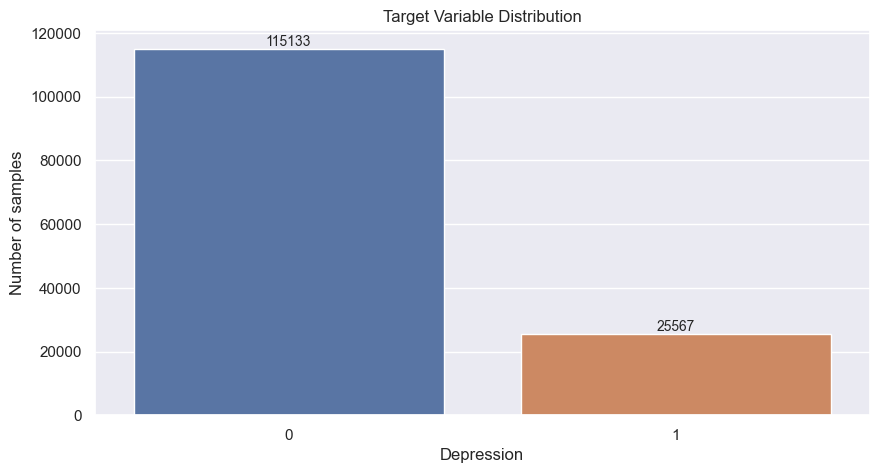

In [14]:
sns.set(font_scale=1)

plt.figure(figsize=(10, 5))
chart = sns.countplot(x="Depression", data=df)
chart.set(ylabel='Number of samples',
       xlabel='Depression')

for p in chart.patches:
    chart.annotate(f'{int(p.get_height())}', 
                   (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha='center', va='bottom', fontsize=10)
plt.title("Target Variable Distribution")
plt.show()

**Most of the people in the data do not have depression, making the target variable classes imbalanced. Interestingly enough, the kaggle competition requires the highest ACCURACY possible, even though it's not the best metric for imbalanced classes (if my model always outputs 0, I will get above 80% accuracy...). We will keep this in mind and try other metrics such a F Score.**

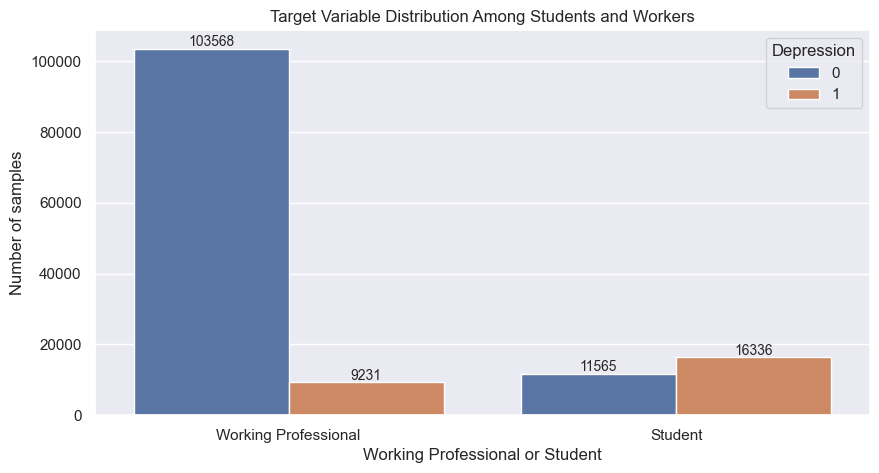

In [15]:
sns.set(font_scale=1)

plt.figure(figsize=(10, 5))
chart = sns.countplot(x="Working Professional or Student", hue="Depression", data=df)
chart.set(ylabel='Number of samples',
          xlabel='Working Professional or Student')

for p in chart.patches:
    chart.annotate(f'{int(p.get_height())}', 
                   (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha='center', va='bottom', fontsize=10)
plt.title("Target Variable Distribution Among Students and Workers")
plt.show()

**The "Working Professional or Student" feature is significant for the understanding of the data. We can learn a few things from this graph:**

**1. According to our data, most students are depressed :( unlike working people, most of them are fine. This fact will be significant for the learning process.**

**2. Almost 2/3 of the depressed respondents are students, even though they are less than 20% of the respondents.**

**Let's look at the distribution and plots of the features - numerical and categorical.**

In [16]:
category_features = ['Gender', 'City', 'Working Professional or Student',
                     'Profession', 'Sleep Duration', 'Dietary Habits',
                     'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness',
                     'State', 'Profession Category', 'Degree Category']
numerical_features = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction',
                      'Work/Study Hours', 'Financial Stress', 'City Population', 'City Literacy Rate',
                      'City Average Salary (1K INR)', 'Profession Average Annual Salary (INR)',
                      'Grad Salary Lower Bound', 'Grad Salary Upper Bound']

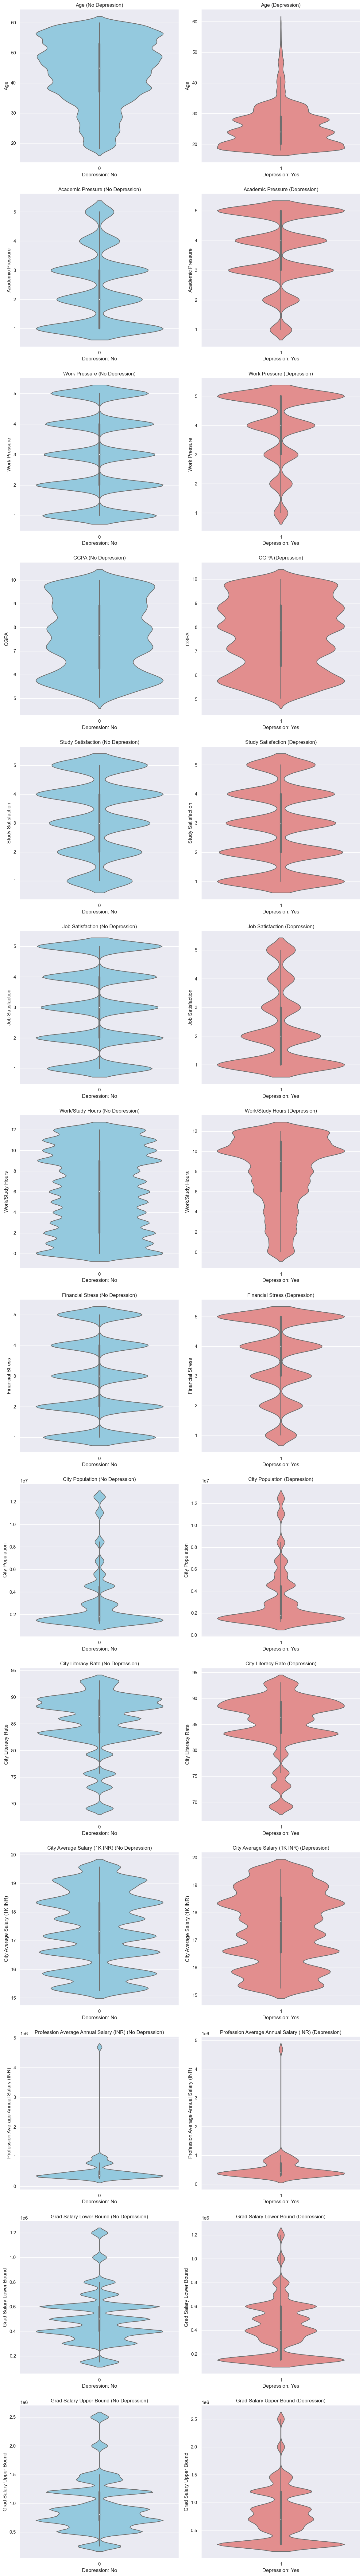

In [17]:
num_features = len(numerical_features)
fig, axes = plt.subplots(num_features, 2, figsize=(12, 6 * num_features))

for i, feature in enumerate(numerical_features):
    sns.violinplot(ax=axes[i, 0], x='Depression', y=feature, data=df[df['Depression'] == 0], color="skyblue")
    axes[i, 0].set_title(f'{feature} (No Depression)')
    axes[i, 0].set_xlabel('Depression: No')
    axes[i, 0].set_ylabel(feature)
    
    sns.violinplot(ax=axes[i, 1], x='Depression', y=feature, data=df[df['Depression'] == 1], color="lightcoral")
    axes[i, 1].set_title(f'{feature} (Depression)')
    axes[i, 1].set_xlabel('Depression: Yes')
    axes[i, 1].set_ylabel(feature)

plt.tight_layout()
plt.show()

**Some interesting things we can learn from these violin plots about our numeric features:**

* Age - Depression seems to be much more widespread among younger people (until age 35) while older people scarcely have it.
* Academic Pressure - Depression is more prevelant the higher a person's academic pressure is.
* Work Pressure - Same as academic pressure.
* CGPA - no difference between the depressed groups and non-depressed.
* Study Satisfaction - Depression is more prevelant the lower a person's study satisfaction is.
* Job Satisfaction - Same as study satisfaction.
* Work/Study Hours - The more a person works he is more likely to be depressed.
* Financial Stress - The higher it is, the more a person is likely to be depressed.
* City Population - no difference between the depressed groups and non-depressed.
* City Literacy Rate - no difference between the depressed groups and non-depressed.
* City Average Salary - no big difference between the depressed groups and non-depressed.
* Profession Avearge Annual Salary - no seen difference between the depressed groups and non-depressed, could be interesting to remove the outliers and look in a higher resolution.
* Grad Salary - Seems that lower salaries lead to higher depression rates.

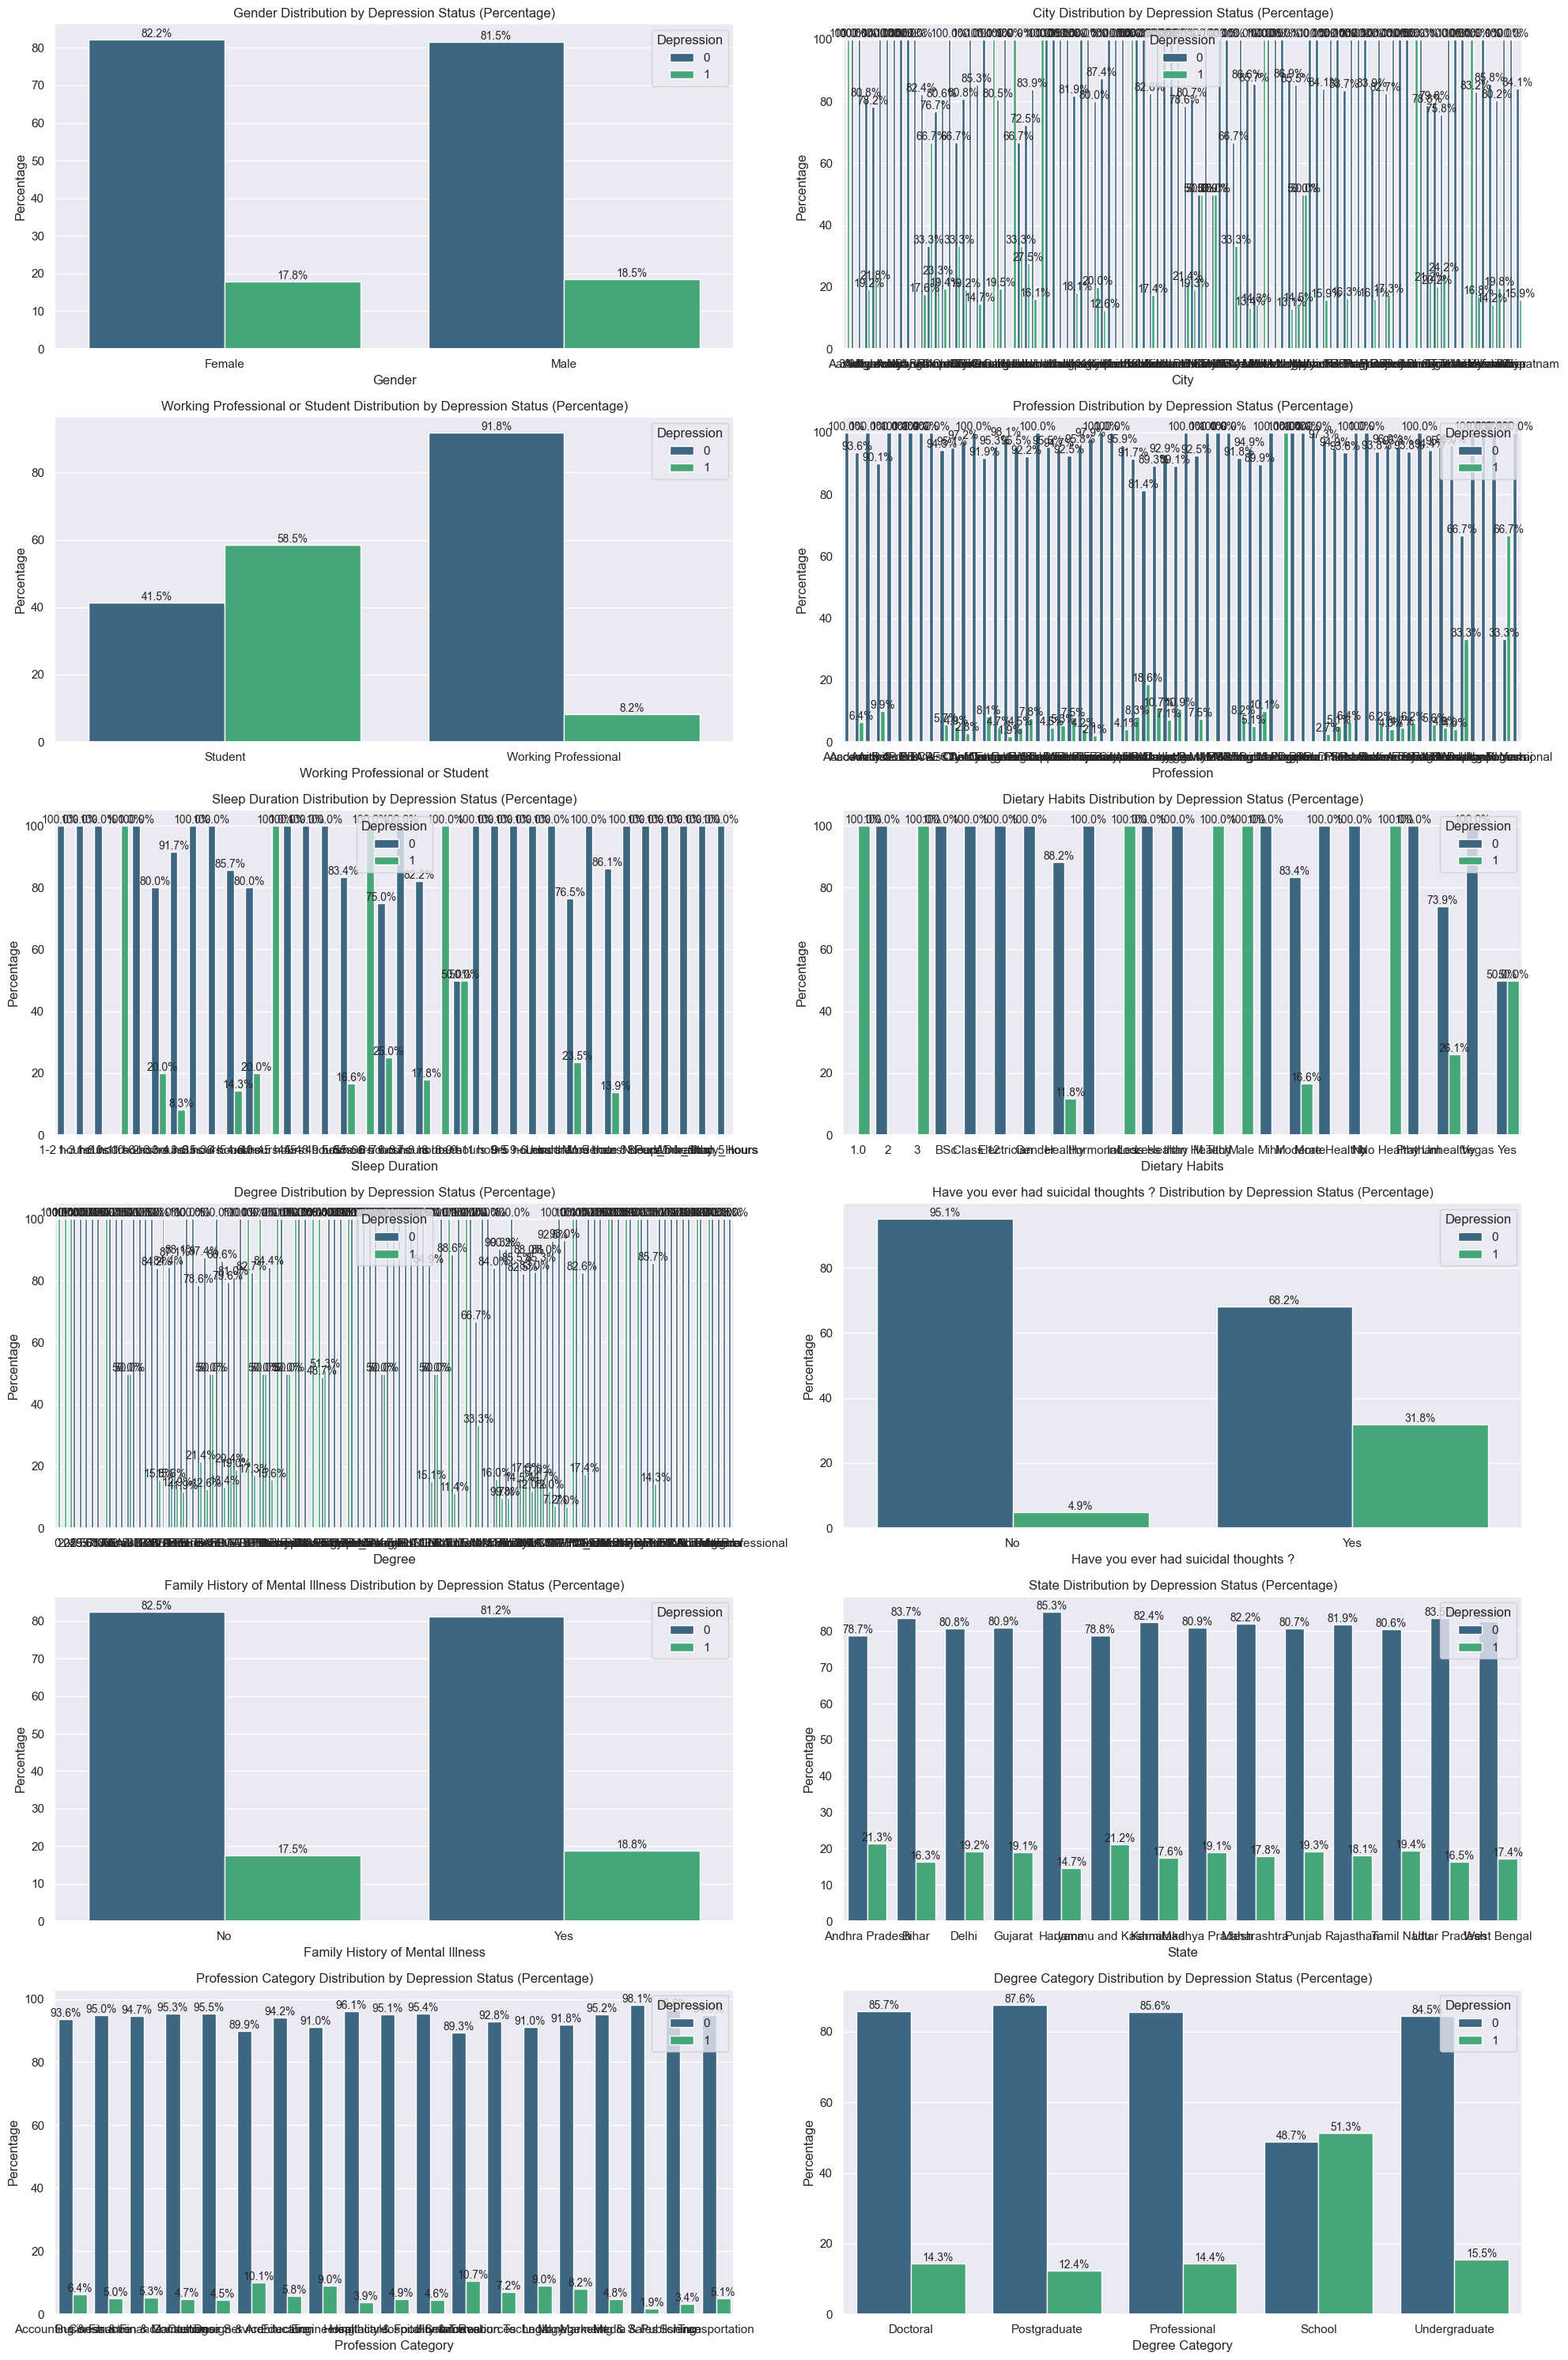

In [18]:
num_features = len(category_features)
num_cols = 2
num_rows = (num_features // num_cols) + (1 if num_features % num_cols != 0 else 0)

plt.figure(figsize=(20, 5 * num_rows))

for i, feature in enumerate(category_features):
    plt.subplot(num_rows, num_cols, i + 1)
    
    percentage_df = df.groupby([feature, 'Depression']).size().reset_index(name='Count')
    total_counts = percentage_df.groupby(feature)['Count'].transform('sum')
    percentage_df['Percentage'] = (percentage_df['Count'] / total_counts) * 100
    
    chart = sns.barplot(data=percentage_df, x=feature, y='Percentage', hue='Depression', palette='viridis')
    
    for p in chart.patches:
        height = p.get_height()
        chart.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='bottom', fontsize=10)

    plt.title(f'{feature} Distribution by Depression Status (Percentage)')
    plt.xlabel(feature)
    plt.ylabel('Percentage')

plt.tight_layout()
plt.show()

**Some interesting things we can learn from these plots about our categorical features:**

* Gender - Depression doesn't seem to be more prevalent among a specific gender.
* Working Professional or Student - as we have seen, depression is much more common among students.
* Sleep Duration - too many categories! We will work on this.
* Degree - too many categories! We will work on this.
* Family History of Mental Illness - the distribution is nearly the same for both options, a bit higher for "yes".
* Profession Categories - Some professions have higher depression rates.
* Dietary habits - too many categories! We will work on this.
* Suicidal thoughts - clearly people with suicidal thoughts have depression more often.
* State - Some states have higher rates, nothing too extreme.
* Degree Category - interestingly, over 50% of people with "only" a high school diploma - have depression.

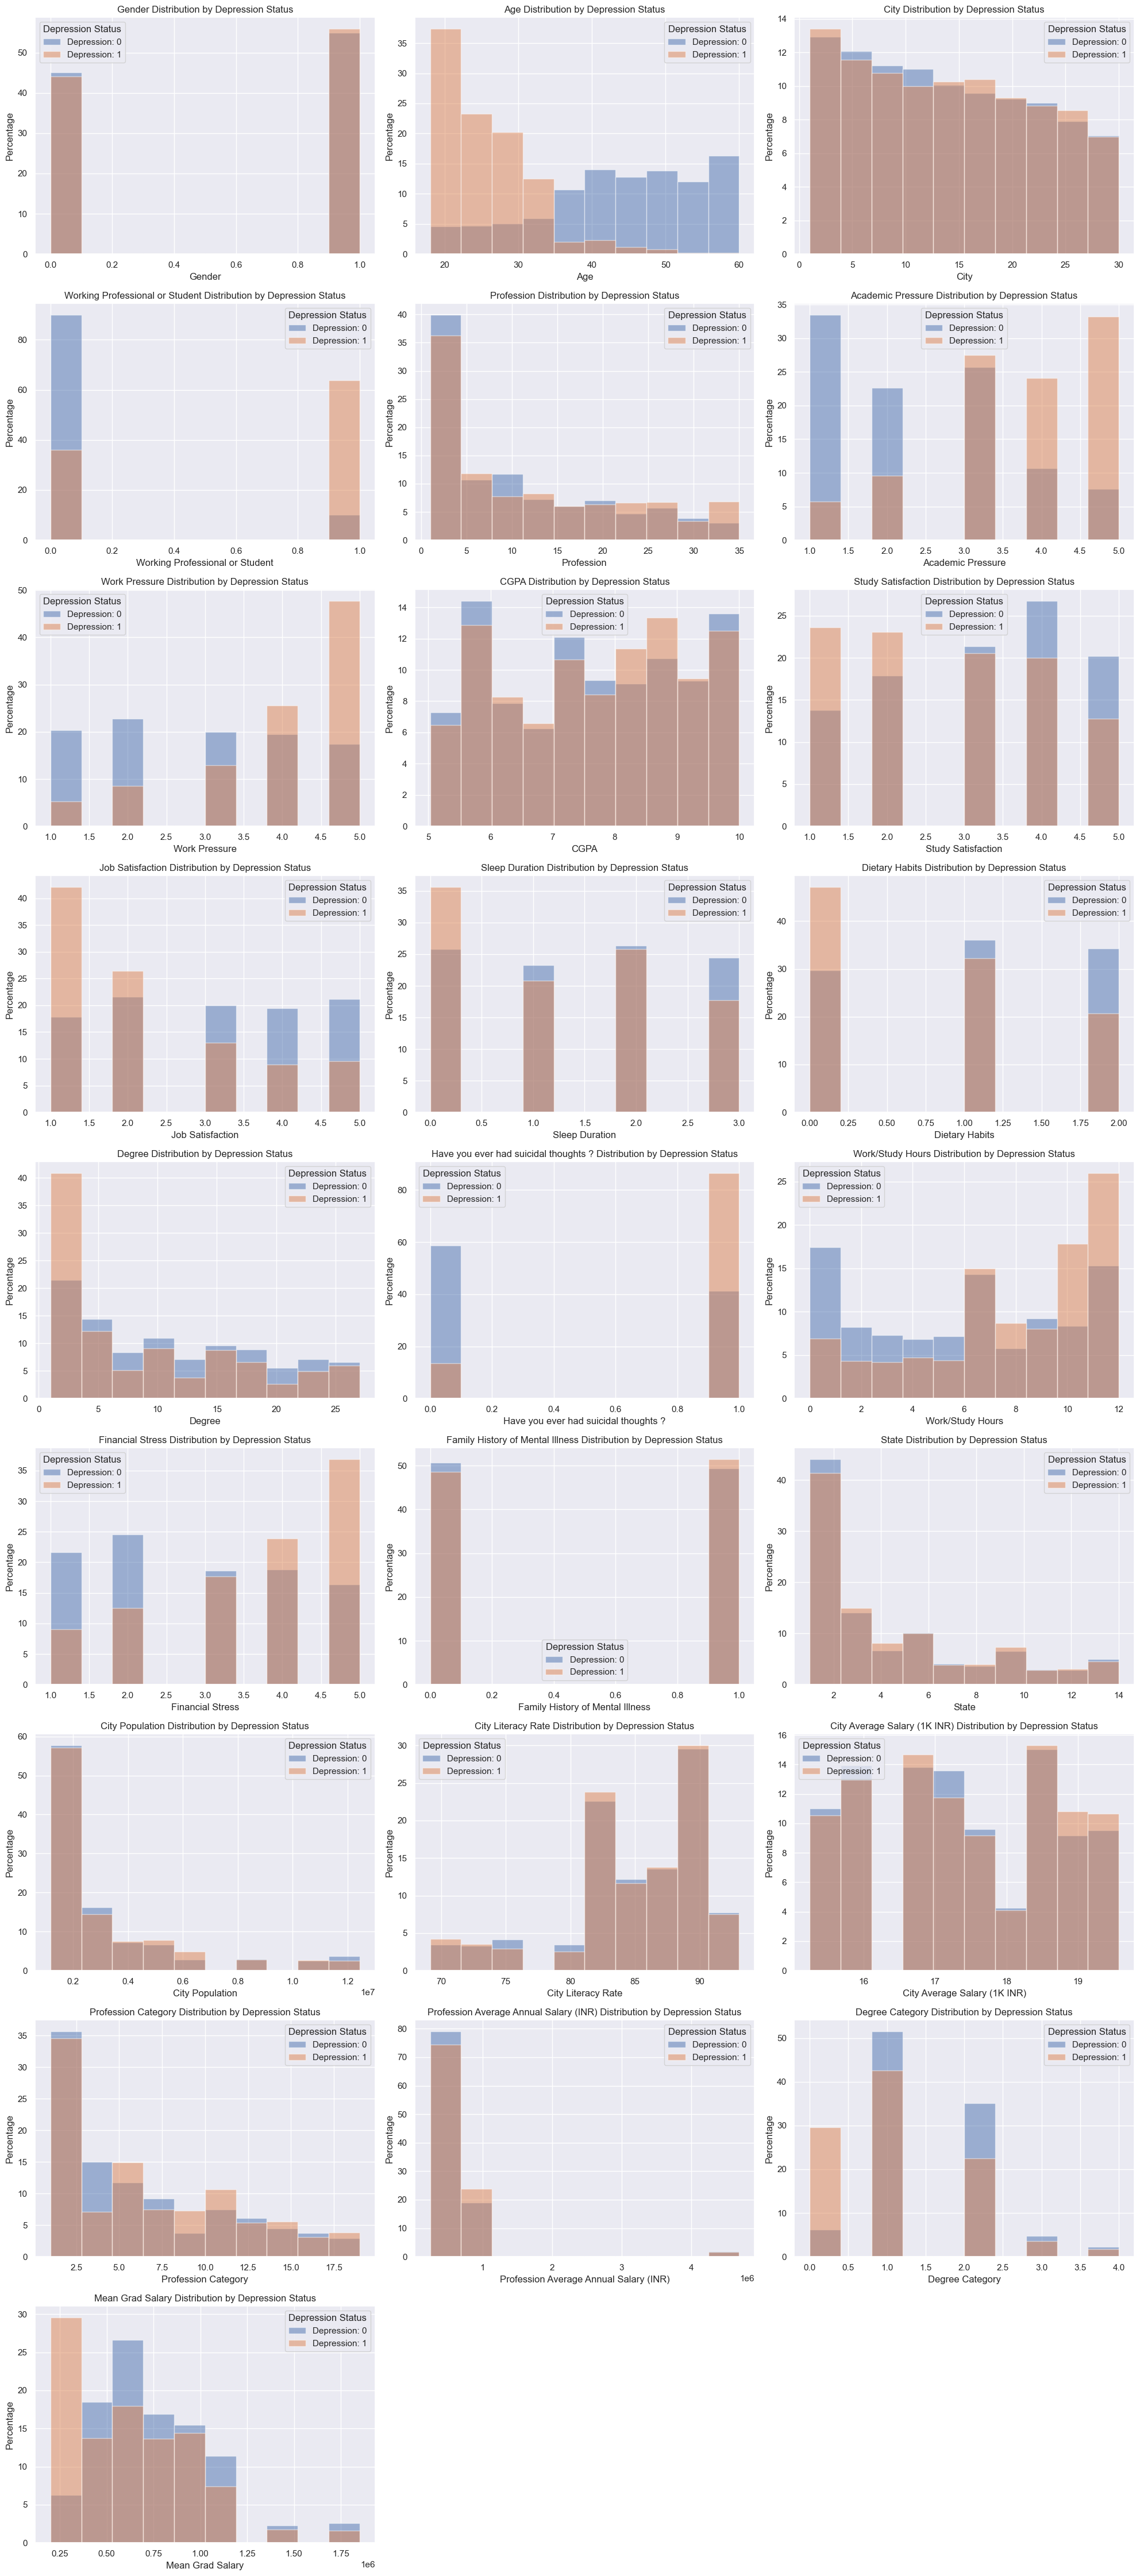

In [87]:
num_features = len(numerical_features)
num_cols = 3
num_rows = (num_features // num_cols) + (1 if num_features % num_cols != 0 else 0)

plt.figure(figsize=(20, 5 * num_rows))

for i, feature in enumerate(numerical_features):
    plt.subplot(num_rows, num_cols, i + 1)
    for status in df['Depression'].unique():
        subset = df[df['Depression'] == status][feature].dropna()
        counts, bins = np.histogram(subset, bins=10)
        percentages = counts / counts.sum() * 100
        plt.bar(bins[:-1], percentages, width=np.diff(bins), alpha=0.5, align='edge', label=f'Depression: {status}')
    
    plt.title(f'{feature} Distribution by Depression Status')
    plt.xlabel(feature)
    plt.ylabel('Percentage')
    plt.legend(title='Depression Status')

plt.tight_layout()
plt.show()

**And here is a tabular version of the categorical features (mainly for features with many categories):**

In [20]:
results_display = {}
for column in category_features:
    counts = df.groupby([column, 'Depression']).size().unstack(fill_value=0)
    counts['Total'] = counts.sum(axis=1)
    percentages = (counts.div(counts['Total'], axis=0) * 100).round(2)
    combined_stats = counts.drop(columns='Total').join(percentages, lsuffix='_count', rsuffix='_percent')
    results_display[column] = combined_stats

In [21]:
results_display['Gender']

Depression  0_count  1_count  0_percent  1_percent  Total
Gender                                                   
Female        51965    11271      82.18      17.82  100.0
Male          63168    14296      81.54      18.46  100.0

In [22]:
results_display['Working Professional or Student']

Depression                       0_count  1_count  0_percent  1_percent  Total
Working Professional or Student                                               
Student                            11565    16336      41.45      58.55  100.0
Working Professional              103568     9231      91.82       8.18  100.0

In [23]:
results_display['Sleep Duration'].sort_values(by=['0_count'], ascending=False).head(4)

Depression         0_count  1_count  0_percent  1_percent  Total
Sleep Duration                                                  
7-8 hours            30376     6593      82.17      17.83  100.0
Less than 5 hours    29683     9101      76.53      23.47  100.0
More than 8 hours    28187     4539      86.13      13.87  100.0
5-6 hours            26820     5322      83.44      16.56  100.0

**Generally it seems that lower sleep duration leads to higher depression rates.**

In [24]:
results_display['Dietary Habits'].sort_values(by=['0_count'], ascending=False).head(3)

Depression      0_count  1_count  0_percent  1_percent  Total
Dietary Habits                                               
Moderate          41472     8233      83.44      16.56  100.0
Healthy           39460     5281      88.20      11.80  100.0
Unhealthy         34183    12044      73.95      26.05  100.0

**Also, a healthier diet leads to lower depression rates.**

In [25]:
results_display['Have you ever had suicidal thoughts ?']

Depression                             0_count  1_count  0_percent  1_percent  \
Have you ever had suicidal thoughts ?                                           
No                                       67680     3458      95.14       4.86   
Yes                                      47453    22109      68.22      31.78   

Depression                             Total  
Have you ever had suicidal thoughts ?         
No                                     100.0  
Yes                                    100.0

**Clearly suicidal toughts play a role.**

In [26]:
results_display['Family History of Mental Illness']

Depression                        0_count  1_count  0_percent  1_percent  \
Family History of Mental Illness                                           
No                                  58348    12410      82.46      17.54   
Yes                                 56785    13157      81.19      18.81   

Depression                        Total  
Family History of Mental Illness         
No                                100.0  
Yes                               100.0

**Surprisingly, history of mental illness does not seem to be as influencial as one might expect.**

In [27]:
results_display['Profession Category']

Depression                  0_count  1_count  0_percent  1_percent  Total
Profession Category                                                      
Accounting & Finance           1253       86      93.58       6.42  100.0
Business & Finance             8343      443      94.96       5.04  100.0
Construction & Maintenance     3152      178      94.65       5.35  100.0
Consulting                     4030      199      95.29       4.71  100.0
Customer Service               1962       93      95.47       4.53  100.0
Design & Architecture          6278      707      89.88      10.12  100.0
Education                     26159     1599      94.24       5.76  100.0
Engineering                    2409      238      91.01       8.99  100.0
Healthcare                     6872      276      96.14       3.86  100.0
Hospitality & Food Service     2723      139      95.14       4.86  100.0
Hospitality & Travel           1774       86      95.38       4.62  100.0
Human Resources                3592      430      89.31      10.69  100.0
Information Technology         3621      279      92.85       7.15  100.0
Legal                          3572      352      91.03       8.97  100.0
Management                     1595      142      91.82       8.18  100.0
Marketing & Sales              4843      244      95.20       4.80  100.0
Media & Publishing             7668      146      98.13       1.87  100.0
Science                        5117      178      96.64       3.36  100.0
Transportation                 1815       98      94.88       5.12  100.0

**Seems like people in certain professions are more in risk for depression!**

In [28]:
results_display['Degree Category']

Depression       0_count  1_count  0_percent  1_percent  Total
Degree Category                                               
Doctoral            2660      443      85.72      14.28  100.0
Postgraduate       40417     5740      87.56      12.44  100.0
Professional        5535      930      85.61      14.39  100.0
School              7180     7549      48.75      51.25  100.0
Undergraduate      59252    10878      84.49      15.51  100.0

**Notice how over half(!) of the people with "only" a high school diploma, reported to have depression!**

# Feature Engineering / Encoding #

**The next necessary step would be to address the categorical features and fix them before trying to create a model. For feature with a clear number of categories, we will create a simple encoding (for example gender: female - 0, male - 1). For features with many categories, we will consider encoding only the most common categories so we wouldn't overfit or learn unnecessary patterns.**

In [29]:
df['Gender'] = df['Gender'].replace({'Female': 0, 'Male': 1})
df['Age'] = df['Age'].apply(int)
df['Working Professional or Student'] = df['Working Professional or Student'].replace({'Working Professional': 0, 'Student': 1})
df['Have you ever had suicidal thoughts ?'] = df['Have you ever had suicidal thoughts ?'].replace({'No': 0, 'Yes': 1})
df['Family History of Mental Illness'] = df['Family History of Mental Illness'].replace({'No': 0, 'Yes': 1})

In [30]:
df['Sleep Duration'].value_counts().head(10)

Sleep Duration
Less than 5 hours    38784
7-8 hours            36969
More than 8 hours    32726
5-6 hours            32142
3-4 hours               12
6-7 hours                8
4-5 hours                7
2-3 hours                5
4-6 hours                5
6-8 hours                4
Name: count, dtype: int64

In [31]:
df['Dietary Habits'].value_counts().head(10)

Dietary Habits
Moderate        49705
Unhealthy       46227
Healthy         44741
Yes                 2
No                  2
More Healthy        2
No Healthy          1
Class 12            1
Indoor              1
Male                1
Name: count, dtype: int64

In [32]:
df['Degree Category'].value_counts().head(10)

Degree Category
Undergraduate    70130
Postgraduate     46157
School           14729
Professional      6465
Doctoral          3103
Name: count, dtype: int64

**For each of these categories we will encode a number (only for the most common ones):**

In [33]:
sleep_duration_map = {
    'Less than 5 hours': 0,
    '5-6 hours': 1,
    '7-8 hours': 2,
    'More than 8 hours': 3,
    '3-4 hours': 0,
    '6-7 hours': 1,
    '4-5 hours': 0,
    '2-3 hours': 0,
    '4-6 hours': 0,
    '6-8 hours': 2
}

df['Sleep Duration'] = df['Sleep Duration'].map(sleep_duration_map).fillna(np.nan)

dietary_map = {
    'Unhealthy': 0,
    'Moderate': 1,
    'Healthy': 2
}

df['Dietary Habits'] = df['Dietary Habits'].map(dietary_map).fillna(np.nan)


degree_categories = {'School': 0,
                        'Undergraduate': 1,
                        'Postgraduate': 2,
                        'Professional': 3,
                        'Doctoral': 4}

df['Degree Category'] = df['Degree Category'].map(degree_categories).fillna(np.nan)

In [34]:
df['Profession'].value_counts().head(35)

Profession
Teacher                   24906
Content Writer             7814
Architect                  4370
Consultant                 4229
HR Manager                 4022
Pharmacist                 3893
Doctor                     3255
Business Analyst           3161
Entrepreneur               2968
Chemist                    2967
Chef                       2862
Educational Consultant     2852
Data Scientist             2390
Researcher                 2328
Lawyer                     2212
Customer Support           2055
Marketing Manager          1976
Pilot                      1913
Travel Consultant          1860
Plumber                    1748
Sales Executive            1739
Manager                    1737
Judge                      1712
Electrician                1582
Financial Analyst          1574
Software Engineer          1510
Civil Engineer             1470
UX/UI Designer             1452
Digital Marketer           1372
Accountant                 1339
Finanancial Analyst        13

In [35]:
top_k_values = df['Profession'].value_counts().nlargest(35).index
mapping = {profession: idx for idx, profession in enumerate(top_k_values, start=1)}
df['Profession'] = df['Profession'].apply(lambda x: mapping.get(x, np.nan))

In [36]:
df['City'].value_counts().head(30)

City
Kalyan           6591
Patna            5924
Vasai-Virar      5765
Kolkata          5689
Ahmedabad        5613
Meerut           5528
Ludhiana         5226
Pune             5210
Rajkot           5207
Visakhapatnam    5176
Srinagar         5074
Mumbai           4966
Indore           4872
Agra             4684
Surat            4636
Varanasi         4606
Vadodara         4568
Hyderabad        4496
Kanpur           4398
Jaipur           4328
Thane            4289
Lucknow          4280
Nagpur           4209
Bangalore        4123
Chennai          4044
Ghaziabad        3620
Delhi            3593
Bhopal           3475
Faridabad        3268
Nashik           3144
Name: count, dtype: int64

In [37]:
top_k_values = df['City'].value_counts().nlargest(30).index
mapping = {profession: idx for idx, profession in enumerate(top_k_values, start=1)}
df['City'] = df['City'].apply(lambda x: mapping.get(x, np.nan))

In [38]:
df['State'].value_counts().head(14)

State
Maharashtra          34174
Uttar Pradesh        27116
Gujarat              20024
Andhra Pradesh        9672
Madhya Pradesh        8347
Bihar                 5924
West Bengal           5689
Punjab                5226
Jammu and Kashmir     5074
Rajasthan             4328
Karnataka             4123
Tamil Nadu            4044
Delhi                 3593
Haryana               3268
Name: count, dtype: int64

In [39]:
top_k_values = df['State'].value_counts().nlargest(14).index
mapping = {profession: idx for idx, profession in enumerate(top_k_values, start=1)}
df['State'] = df['State'].apply(lambda x: mapping.get(x, np.nan))

In [40]:
df['Profession Category'].value_counts().head(19)

Profession Category
Education                     27758
Business & Finance             8786
Media & Publishing             7814
Healthcare                     7148
Design & Architecture          6985
Science                        5295
Marketing & Sales              5087
Consulting                     4229
Human Resources                4022
Legal                          3924
Information Technology         3900
Construction & Maintenance     3330
Hospitality & Food Service     2862
Engineering                    2647
Customer Service               2055
Transportation                 1913
Hospitality & Travel           1860
Management                     1737
Accounting & Finance           1339
Name: count, dtype: int64

In [41]:
top_k_values = df['Profession Category'].value_counts().nlargest(19).index
mapping = {profession: idx for idx, profession in enumerate(top_k_values, start=1)}
df['Profession Category'] = df['Profession Category'].apply(lambda x: mapping.get(x, np.nan))

In [42]:
df['Degree'].value_counts().head(27)

Degree
Class 12    14729
B.Ed        11691
B.Arch       8742
B.Com        8113
B.Pharm      5856
BCA          5739
M.Ed         5668
MCA          5234
BBA          5030
BSc          5027
MSc          4879
LLM          4647
M.Pharm      4537
M.Tech       4475
B.Tech       4425
LLB          4348
BHM          4305
MBA          3818
BA           3750
ME           3632
MD           3383
MHM          3286
BE           3104
PhD          3103
M.Com        3094
MBBS         3082
MA           2887
Name: count, dtype: int64

In [43]:
top_k_values = df['Degree'].value_counts().nlargest(27).index
mapping = {profession: idx for idx, profession in enumerate(top_k_values, start=1)}
df['Degree'] = df['Degree'].apply(lambda x: mapping.get(x, np.nan))

In [44]:
df.head()

Gender  Age  City  Working Professional or Student  Profession  \
0       0   49   7.0                                0        11.0   
1       1   26  16.0                                0         1.0   
2       1   33  10.0                                1         NaN   
3       1   22  12.0                                0         1.0   
4       0   30  19.0                                0         8.0   

   Academic Pressure  Work Pressure  CGPA  Study Satisfaction  \
0                NaN            5.0   NaN                 NaN   
1                NaN            4.0   NaN                 NaN   
2                5.0            NaN  8.97                 2.0   
3                NaN            5.0   NaN                 NaN   
4                NaN            1.0   NaN                 NaN   

   Job Satisfaction  Sleep Duration  Dietary Habits  Degree  \
0               2.0             3.0             2.0    17.0   
1               3.0             0.0             0.0    16.0   
2               NaN             1.0             2.0     5.0   
3               1.0             0.0             1.0     9.0   
4               1.0             1.0             0.0     9.0   

   Have you ever had suicidal thoughts ?  Work/Study Hours  Financial Stress  \
0                                      0               1.0               2.0   
1                                      1               7.0               3.0   
2                                      1               3.0               1.0   
3                                      1              10.0               1.0   
4                                      1               9.0               4.0   

   Family History of Mental Illness  Depression  State  City Population  \
0                                 0           0    8.0        1618879.0   
1                                 0           1    2.0        1198491.0   
2                                 0           1    4.0        1728128.0   
3                                 1           1    1.0       12442373.0   
4                                 1           0    2.0        2765348.0   

   City Literacy Rate  City Average Salary (1K INR)  Profession Category  \
0               85.77                         16.55                 13.0   
1               79.27                           NaN                  1.0   
2               81.79                         15.77                  NaN   
3               89.73                         19.17                  1.0   
4               82.42                         17.12                  2.0   

   Profession Average Annual Salary (INR)  Degree Category  \
0                                514200.0              1.0   
1                                314300.0              1.0   
2                                     NaN              1.0   
3                                314300.0              1.0   
4                                481300.0              1.0   

   Grad Salary Lower Bound  Grad Salary Upper Bound  
0                 350000.0                 600000.0  
1                 400000.0                 800000.0  
2                 400000.0                 700000.0  
3                 450000.0                 800000.0  
4                 450000.0                 800000.0

# Heatmap of correlations between features #

**Highly correlated features might be redundant:**

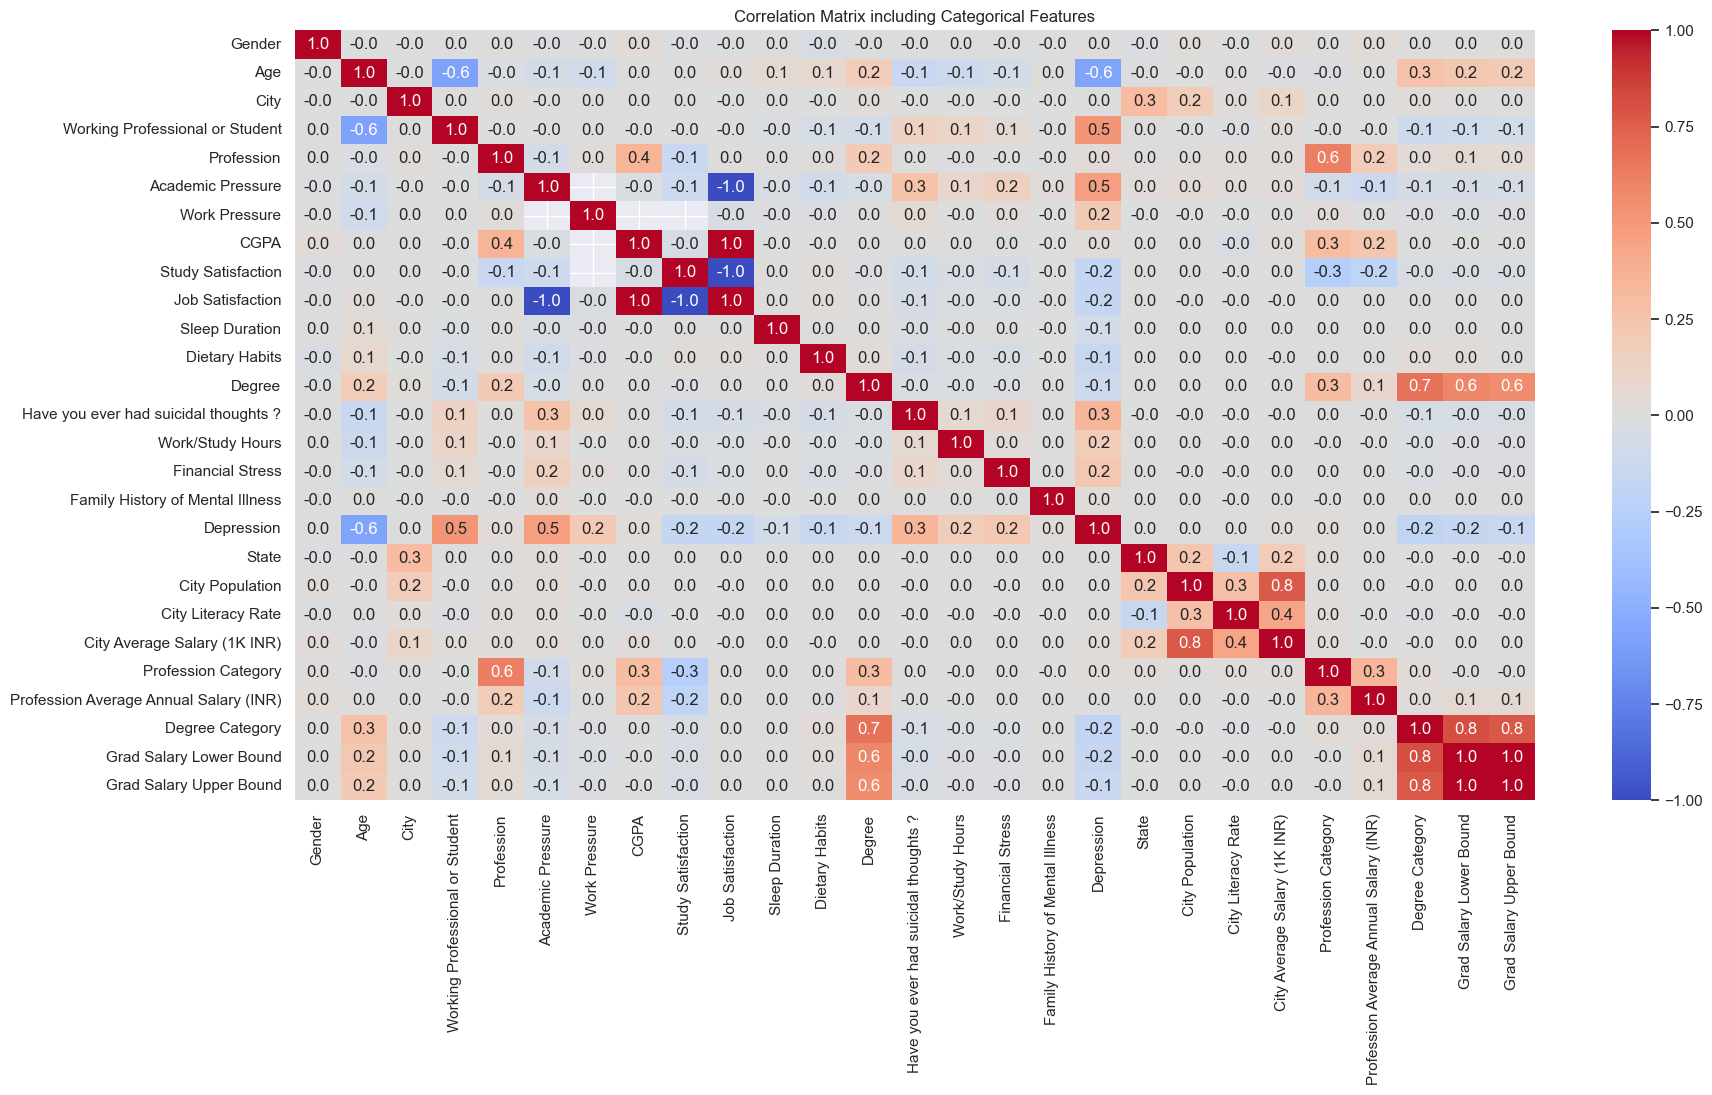

In [45]:
corr_matrix = df.corr()
plt.figure(figsize=(20, 10))

sns.heatmap(corr_matrix, annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Correlation Matrix including Categorical Features')
plt.show()

**The lower and upper bound of grad salary is redundant, instead we'll replace it with an average of the 2:**

In [46]:
df['Mean Grad Salary'] = (df['Grad Salary Lower Bound'] + df['Grad Salary Upper Bound']) / 2
df.drop(columns=['Grad Salary Lower Bound', 'Grad Salary Upper Bound'], inplace=True)

# Statistical Tests on Features #

**We will do some statistical tests to see which features have a similar distributions between depressed and non-depressed people. We will use Mann-Whitney U-Test and Chi-Squared tests.**

**Mann-Whitney U test is a non parametric test used to compare two independent groups to determine whether their distributions are significantly different. It's biggest advantage for us is that it doesn't require normal distributions and can handle outliers, and since our data is not normally distributed and contains outliers it can be a good indicator.**

**Chi-squared test evaluates the association between categorical variables by comparing observed and expected frequencies. We could just use it on the categorical features, but checking it out for numerical features is free, so why not?**

**We will also look at some simpler metrics hued by the target variable like mean and 95% confidence interval.**

In [47]:
def confidence_interval(data):
    mean = np.mean(data)
    ci = stats.t.interval(0.95, len(data) - 1, loc=mean, scale=stats.sem(data))
    return mean, ci

columns_to_drop_workers = ['Working Professional or Student',  'Academic Pressure',
                      'CGPA', 'Study Satisfaction','Degree', 'Degree Category', 'Mean Grad Salary']

columns_to_drop_students = ['Profession Average Annual Salary (INR)', 'Profession Category',
                            'Job Satisfaction', 'Working Professional or Student', 'Profession', 'Work Pressure']

results = []

for student_status in [0, 1]:
    
    df_student = df[df['Working Professional or Student'] == student_status] 
    
    if student_status == 1:
        df_student = df_student.drop(columns=columns_to_drop_students)
    else:
        df_student = df_student.drop(columns=columns_to_drop_workers)
        
    for feature in df_student.columns:
        try:
            group_0 = df_student[df_student['Depression'] == 0][feature].dropna()
            group_1 = df_student[df_student['Depression'] == 1][feature].dropna()

            stat_u, p_value_u = mannwhitneyu(group_0, group_1, alternative='two-sided')
            same_distribution_u = 'No' if p_value_u < 0.05 else 'Yes'
            
            contingency_table = pd.crosstab(df_student[feature], df_student['Depression'])
            stat_chi, p_value_chi, dof_chi, expected_chi = chi2_contingency(contingency_table)
            same_distribution_chi = 'No' if p_value_chi < 0.05 else 'Yes'
            
            depressed_mean, depressed_ci = confidence_interval(group_1)
            non_depressed_mean, non_depressed_ci = confidence_interval(group_0)
    
            results.append({
                'Feature Name': feature, 
                'P-value Mann-Whitney U': round(p_value_u, 2), 
                'Same Distribution Mann-Whitney U': same_distribution_u, 
                'P-value Chi-Squared': round(p_value_chi, 2), 
                'Same Distribution Chi-Squared': same_distribution_chi, 
                'Student': student_status,
                'Depressed Mean': round(depressed_mean, 2),
                'Depressed 95% CI': depressed_ci,
                'Non-Depressed Mean': round(non_depressed_mean, 2),
                'Non-Depressed 95% CI': non_depressed_ci
            })
        except Exception as e:
            pass


results_df = pd.DataFrame(results)
results_df

invalid value encountered in multiply
invalid value encountered in multiply
invalid value encountered in multiply
invalid value encountered in multiply


Feature Name  P-value Mann-Whitney U  \
0                                   Gender                    0.01   
1                                      Age                    0.00   
2                                     City                    0.06   
3                               Profession                    0.00   
4                            Work Pressure                    0.00   
5                         Job Satisfaction                    0.00   
6                           Sleep Duration                    0.00   
7                           Dietary Habits                    0.00   
8    Have you ever had suicidal thoughts ?                    0.00   
9                         Work/Study Hours                    0.00   
10                        Financial Stress                    0.00   
11        Family History of Mental Illness                    0.00   
12                              Depression                    0.00   
13                                   State                    0.48   
14                         City Population                    0.06   
15                      City Literacy Rate                    0.00   
16            City Average Salary (1K INR)                    0.01   
17                     Profession Category                    0.00   
18  Profession Average Annual Salary (INR)                    0.00   
19                                  Gender                    0.76   
20                                     Age                    0.00   
21                                    City                    0.02   
22                       Academic Pressure                    0.00   
23                                    CGPA                    0.00   
24                      Study Satisfaction                    0.00   
25                          Sleep Duration                    0.00   
26                          Dietary Habits                    0.00   
27                                  Degree                    0.00   
28   Have you ever had suicidal thoughts ?                    0.00   
29                        Work/Study Hours                    0.00   
30                        Financial Stress                    0.00   
31        Family History of Mental Illness                    0.00   
32                              Depression                    0.00   
33                                   State                    0.00   
34                         City Population                    0.00   
35                      City Literacy Rate                    0.09   
36            City Average Salary (1K INR)                    0.00   
37                         Degree Category                    0.00   
38                        Mean Grad Salary                    0.00   

   Same Distribution Mann-Whitney U  P-value Chi-Squared  \
0                                No                 0.01   
1                                No                 0.00   
2                               Yes                 0.00   
3                                No                 0.00   
4                                No                 0.00   
5                                No                 0.00   
6                                No                 0.00   
7                                No                 0.00   
8                                No                 0.00   
9                                No                 0.00   
10                               No                 0.00   
11                               No                 0.00   
12                               No                 0.00   
13                              Yes                 0.00   
14                              Yes                 0.00   
15                               No                 0.00   
16                               No                 0.00   
17                               No                 0.00   
18                               No                 0.00   
19                           

**As we can see, some of the features have very similar distributions for both classes: Gender, City Literacy Rate, City, City Population, State and City Average Salary (1K INR).**

**We will see later if dropping these features will be helpful, as they might not provide meaningful information about the target variable and it can simplify the model.**

# Is there a chance for separation? #

**Now let's try to visualize the data and hue it by the target variable, using 2-dimensional PCA, to roughly see if we have a feasible chance of separating the classes:**

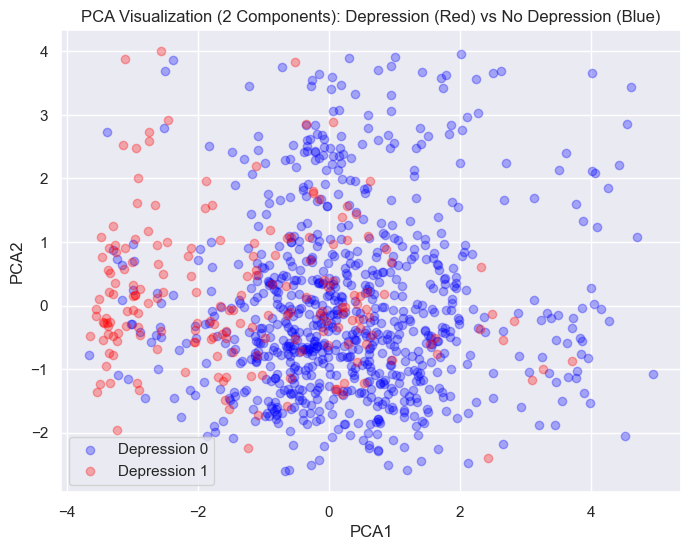

In [89]:
pca = PCA(n_components=2)
scaler = StandardScaler()

df_sample = df.sample(n=1000, random_state=42)

X = df_sample.drop(columns=['Depression'])
y = df_sample['Depression']

X_scaled = scaler.fit_transform(X)
pca_result = pca.fit_transform(np.nan_to_num(X_scaled, nan=0))

pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['Depression'] = y.reset_index(drop=True)

color_map = {0: 'blue', 1: 'red'}
plt.figure(figsize=(8, 6))
for depression_value in [0, 1]:
    subset = pca_df[pca_df['Depression'] == depression_value]
    plt.scatter(
        subset['PCA1'],
        subset['PCA2'],
        c=color_map[depression_value],
        label=f"Depression {depression_value}",
        alpha=0.3
    )

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA Visualization (2 Components): Depression (Red) vs No Depression (Blue)')
plt.legend()
plt.show()

**Seems like there is a chance! We can notice that most of the depressed samples are on the left side of the graph.**

# Outliers #

**Let's see if there are any extreme outliers in any of the features in the data:**

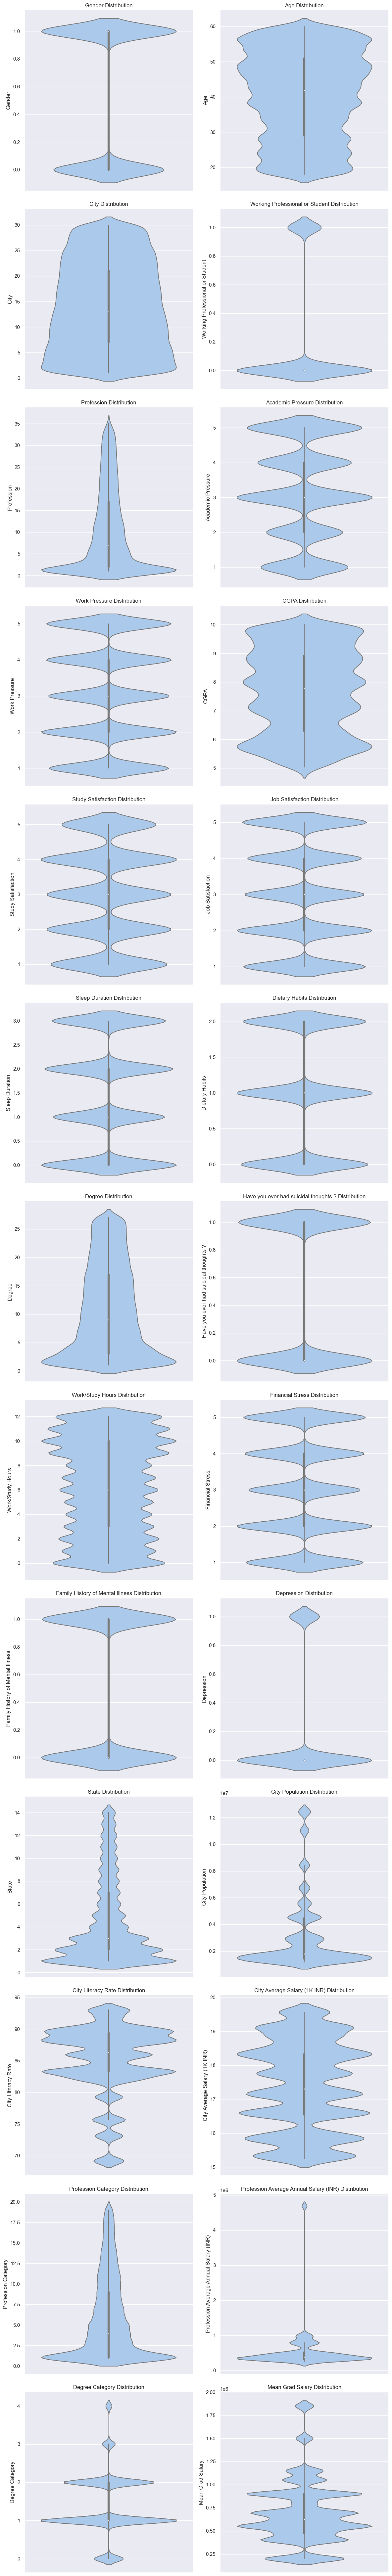

In [49]:
num_features = len(df.columns)
num_rows = (num_features + 1) // 2

fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))

axes = axes.flatten()

for i, feature in enumerate(df.columns):
    sns.violinplot(ax=axes[i], y=feature, data=df, palette="pastel")
    axes[i].set_title(f'{feature} Distribution')
    axes[i].set_ylabel(feature)
    axes[i].set_xlabel('')

if num_features % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

**It seems like there are some outliers regarding Salary - it could be wise to try and remove those outliers from the data before training the model, in order to generelize better on the test set.**

**Finally let's check how our features correlate with the target variable:**

In [50]:
# Calculate the correlation of each feature with 'Depression', sort by absolute value
correlations = df.drop("Depression", axis=1).apply(lambda x: x.corr(df["Depression"])).sort_values(ascending=False)
correlations

Working Professional or Student           0.520790
Academic Pressure                         0.475037
Have you ever had suicidal thoughts ?     0.349066
Financial Stress                          0.227237
Work Pressure                             0.216634
Work/Study Hours                          0.191746
Profession                                0.031437
Profession Category                       0.023213
City Average Salary (1K INR)              0.023196
CGPA                                      0.021729
Family History of Mental Illness          0.016502
Gender                                    0.008144
City                                      0.006563
State                                     0.005877
Profession Average Annual Salary (INR)    0.005139
City Population                           0.002545
City Literacy Rate                        0.001395
Sleep Duration                           -0.081856
Degree                                   -0.124732
Mean Grad Salary               

**Examples of features that are minimally correlated - 'CGPA', 'Family History of Mental Illness', 'Profession Average Annual Salary (INR)'**
                                        
**Generally, some advanced models like XGBOOST that we will use, are robust to low correlation features, and their removal maybe not necessary.**

# Model Training and Evaluation #

In [51]:
X, y = df.drop(columns=['Depression']), df['Depression']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

**In this part, we will try many combinations of the data and of different models, to see which ones work best:**

1. Imputation strategies - No imputation, impute mean of each column, impute 0.
2. Outliers - keep or remove.
3. Dropping columns with low correlation to target variable / redundant.
4. Scaling the dataset.
5. One-hot encoding.
6. Models - Xgboost, LightGBM, CatBoost, Random Forest, Logistic Regression.

In [52]:
imputation_strategies = ['none', 'mean', 'constant']  # Imputation options
outlier_options = [True, False]                       # Outlier removal options
drop_columns_options = [True, False]                  # Drop columns options
scaling_options = [True, False]                       # Feature scaling options
one_hot_options = [True, False]                       # One-hot encoding options

pipeline_configurations = []

columns_to_drop = ['CGPA', 'Family History of Mental Illness', 'Profession Average Annual Salary (INR)',
                   'Gender', 'City Literacy Rate', 'City', 'City Population', 'State',
                   'City Average Salary (1K INR)']
one_hot_columns = ['Working Professional or Student', 'Have you ever had suicidal thoughts ?',
                   'Family History of Mental Illness', 'Profession Category', 'Degree Category']
training_data_variations = []

for impute in imputation_strategies:
    for outlier in outlier_options:
        for drop_columns in drop_columns_options:
            for scale in scaling_options:
                for one_hot in one_hot_options:
                    
                    data_type = ''
                    data = X_train.copy()
                    labels = y_train.copy()
                    
                    test_data = X_test.copy()
                    
                    if drop_columns:  
                        data = data.drop(columns=columns_to_drop)
                        test_data = test_data.drop(columns=columns_to_drop)
                        data_type += 'dropped_columns-'
                    else:
                        data_type += 'no_dropped_columns-'
                    
                    if one_hot:
                        if drop_columns:
                            data = pd.get_dummies(data,
                                                     columns=[col for col in one_hot_columns if col not in columns_to_drop],
                                                     drop_first=True)
                            test_data = pd.get_dummies(test_data,
                                                     columns=[col for col in one_hot_columns if col not in columns_to_drop],
                                                     drop_first=True)
                        else:
                            data = pd.get_dummies(data, columns=one_hot_columns, drop_first=True)
                            test_data = pd.get_dummies(test_data, columns=one_hot_columns, drop_first=True)
                        data = data.applymap(lambda x: 1 if x is True else (0 if x is False else x))
                        test_data = test_data.applymap(lambda x: 1 if x is True else (0 if x is False else x))
                        data_type += 'encoded-'
                    else:
                        data_type += 'not_encoded-'
                        
                    numerical_features = list(data.columns)
                    
                    steps = []
                    
                    if impute == 'none':
                        imputer = 'passthrough'
                        data_type += 'no_imputation-'
                    else:
                        imputer = SimpleImputer(strategy=impute if impute != 'constant' else 'constant', fill_value=0)
                        if impute == 'mean':
                            data_type += 'imputed_mean-'
                        else:
                            data_type += 'imputed_0-'
                    steps.append(('imputer', imputer))

                    if scale:
                        steps.append(('scaler', StandardScaler()))
                        data_type += 'scaled-'
                    else:
                        data_type += 'not_scaled-'
                    
                    steps.append(('convert_to_float32', FunctionTransformer(lambda x: x.astype(np.float32))))
                                        
                    pipeline = Pipeline(steps=steps)
                    preprocessor = ColumnTransformer(
                        transformers=[
                            ('num', pipeline, numerical_features),
                        ]
                    )

                    data_preprocessed = preprocessor.fit_transform(data)
                    test_data_preprocessed = preprocessor.fit_transform(test_data)
                    
                    if outlier and impute != 'none':
                        data_type += 'removed_outliers'
                        isolation_forest = IsolationForest(contamination=0.01, random_state=42)
                        outlier_labels = isolation_forest.fit_predict(data_preprocessed)

                        non_outliers_mask = outlier_labels != -1
                        data_preprocessed = data_preprocessed[non_outliers_mask]
                        labels = labels[non_outliers_mask]
                    else:
                        data_type += 'kept_outliers'
                    
                    existing_data_types = [x[0] for x in training_data_variations]
                    if data_type not in existing_data_types:
                        training_data_variations.append((data_type, data_preprocessed, labels, test_data_preprocessed))

In [53]:
models = {
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
}

results = []

for variation in training_data_variations:
    for model_type in list(models.keys()):
        try:
            data_type, data, labels, test_data = variation
            model = models[model_type]

            model.fit(data, labels)

            y_pred = model.predict(test_data)
            test_accuracy = accuracy_score(y_test, y_pred)
            test_f1 = f1_score(y_test, y_pred)
            test_ap = average_precision_score(y_test, y_pred)
            test_rmse = mean_squared_error(y_test, y_pred, squared=False)
            test_auc_roc = roc_auc_score(y_test, model.predict_proba(test_data)[:, 1])

            results.append({
                'data_type': data_type,
                'model_type': model_type,
                'test_accuracy': test_accuracy,
                'test_f1': test_f1,
                'test_ap': test_ap,
                'test_rmse': test_rmse,
                'test_auc_roc': test_auc_roc
            })

            print(f"Test results for {data_type} with model {model_type}:")
            print(f"Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}, AP: {test_ap:.4f}, RMSE: {test_rmse:.4f}, AUC-ROC: {test_auc_roc:.4f}")
        except ValueError:
            pass
        
results_df = pd.DataFrame(results)

`use_label_encoder` is deprecated in 1.7.0.


Test results for dropped_columns-encoded-no_imputation-scaled-kept_outliers with model XGBoost:
Accuracy: 0.9379, F1: 0.8264, AP: 0.7170, RMSE: 0.2492, AUC-ROC: 0.9737
Test results for dropped_columns-encoded-no_imputation-scaled-kept_outliers with model CatBoost:
Accuracy: 0.9387, F1: 0.8278, AP: 0.7198, RMSE: 0.2477, AUC-ROC: 0.9744
Test results for dropped_columns-encoded-no_imputation-scaled-kept_outliers with model LightGBM:
Accuracy: 0.9383, F1: 0.8302, AP: 0.7202, RMSE: 0.2484, AUC-ROC: 0.9742
Test results for dropped_columns-not_encoded-no_imputation-scaled-kept_outliers with model XGBoost:
Accuracy: 0.9370, F1: 0.8238, AP: 0.7134, RMSE: 0.2509, AUC-ROC: 0.9731
Test results for dropped_columns-not_encoded-no_imputation-scaled-kept_outliers with model CatBoost:
Accuracy: 0.9389, F1: 0.8286, AP: 0.7208, RMSE: 0.2472, AUC-ROC: 0.9745
Test results for dropped_columns-not_encoded-no_imputation-scaled-kept_outliers with model LightGBM:
Accuracy: 0.9383, F1: 0.8300, AP: 0.7200, RMSE: 

Test results for no_dropped_columns-encoded-imputed_mean-scaled-removed_outliers with model RandomForest:
Accuracy: 0.9355, F1: 0.8167, AP: 0.7059, RMSE: 0.2539, AUC-ROC: 0.9708
Test results for no_dropped_columns-encoded-imputed_mean-scaled-removed_outliers with model LogisticRegression:
Accuracy: 0.9392, F1: 0.8299, AP: 0.7224, RMSE: 0.2465, AUC-ROC: 0.9740
Test results for no_dropped_columns-not_encoded-imputed_mean-scaled-removed_outliers with model XGBoost:
Accuracy: 0.9371, F1: 0.8260, AP: 0.7147, RMSE: 0.2508, AUC-ROC: 0.9734
Test results for no_dropped_columns-not_encoded-imputed_mean-scaled-removed_outliers with model CatBoost:
Accuracy: 0.9387, F1: 0.8307, AP: 0.7213, RMSE: 0.2477, AUC-ROC: 0.9740
Test results for no_dropped_columns-not_encoded-imputed_mean-scaled-removed_outliers with model LightGBM:
Accuracy: 0.9372, F1: 0.8256, AP: 0.7149, RMSE: 0.2505, AUC-ROC: 0.9737
Test results for no_dropped_columns-not_encoded-imputed_mean-scaled-removed_outliers with model RandomFor

Test results for no_dropped_columns-encoded-imputed_mean-not_scaled-kept_outliers with model XGBoost:
Accuracy: 0.9250, F1: 0.7683, AP: 0.6568, RMSE: 0.2738, AUC-ROC: 0.9697
Test results for no_dropped_columns-encoded-imputed_mean-not_scaled-kept_outliers with model CatBoost:
Accuracy: 0.9333, F1: 0.7996, AP: 0.6933, RMSE: 0.2583, AUC-ROC: 0.9726
Test results for no_dropped_columns-encoded-imputed_mean-not_scaled-kept_outliers with model LightGBM:
Accuracy: 0.9232, F1: 0.7616, AP: 0.6490, RMSE: 0.2771, AUC-ROC: 0.9703
Test results for no_dropped_columns-encoded-imputed_mean-not_scaled-kept_outliers with model RandomForest:
Accuracy: 0.9318, F1: 0.7895, AP: 0.6864, RMSE: 0.2612, AUC-ROC: 0.9709
Test results for no_dropped_columns-encoded-imputed_mean-not_scaled-kept_outliers with model LogisticRegression:
Accuracy: 0.8183, F1: 0.0000, AP: 0.1817, RMSE: 0.4263, AUC-ROC: 0.6138
Test results for no_dropped_columns-not_encoded-imputed_mean-not_scaled-kept_outliers with model XGBoost:
Accura

Test results for no_dropped_columns-not_encoded-imputed_0-not_scaled-removed_outliers with model LightGBM:
Accuracy: 0.9396, F1: 0.8315, AP: 0.7242, RMSE: 0.2458, AUC-ROC: 0.9749
Test results for no_dropped_columns-not_encoded-imputed_0-not_scaled-removed_outliers with model RandomForest:
Accuracy: 0.9367, F1: 0.8195, AP: 0.7104, RMSE: 0.2516, AUC-ROC: 0.9711
Test results for no_dropped_columns-not_encoded-imputed_0-not_scaled-removed_outliers with model LogisticRegression:
Accuracy: 0.8183, F1: 0.0000, AP: 0.1817, RMSE: 0.4263, AUC-ROC: 0.7895
Test results for dropped_columns-encoded-imputed_0-scaled-kept_outliers with model XGBoost:
Accuracy: 0.9377, F1: 0.8263, AP: 0.7166, RMSE: 0.2495, AUC-ROC: 0.9735
Test results for dropped_columns-encoded-imputed_0-scaled-kept_outliers with model CatBoost:
Accuracy: 0.9386, F1: 0.8276, AP: 0.7196, RMSE: 0.2478, AUC-ROC: 0.9743
Test results for dropped_columns-encoded-imputed_0-scaled-kept_outliers with model LightGBM:
Accuracy: 0.9396, F1: 0.831

**Top models by F1 Score:**

In [54]:
top_models_f1 = results_df.sort_values(by=['test_f1'], ascending=False).reset_index(drop=True)
top_models_f1

data_type          model_type  \
0    no_dropped_columns-encoded-imputed_mean-scaled...            CatBoost   
1    no_dropped_columns-not_encoded-imputed_0-scale...            LightGBM   
2    no_dropped_columns-not_encoded-imputed_0-not_s...            CatBoost   
3    dropped_columns-not_encoded-imputed_0-not_scal...            LightGBM   
4    no_dropped_columns-not_encoded-no_imputation-n...            LightGBM   
5    no_dropped_columns-encoded-imputed_0-not_scale...            LightGBM   
6    dropped_columns-encoded-imputed_0-not_scaled-k...            LightGBM   
7    no_dropped_columns-not_encoded-imputed_0-not_s...            LightGBM   
8    no_dropped_columns-encoded-imputed_0-scaled-re...            LightGBM   
9    no_dropped_columns-not_encoded-imputed_0-scale...            LightGBM   
10   no_dropped_columns-encoded-imputed_0-not_scale...            LightGBM   
11   dropped_columns-not_encoded-imputed_0-scaled-k...            LightGBM   
12   no_dropped_columns-encoded-no_imputation-not_s...            CatBoost   
13   no_dropped_columns-encoded-no_imputation-scale...            LightGBM   
14   dropped_columns-encoded-imputed_0-scaled-kept_...            LightGBM   
15   no_dropped_columns-encoded-imputed_mean-scaled...            CatBoost   
16   no_dropped_columns-encoded-imputed_0-not_scale...            CatBoost   
17   dropped_columns-not_encoded-imputed_0-not_scal...            LightGBM   
18   dropped_columns-encoded-no_imputation-not_scal...            LightGBM   
19   no_dropped_columns-not_encoded-imputed_mean-sc...            CatBoost   
20   no_dropped_columns-encoded-imputed_0-scaled-re...            CatBoost   
21   dropped_columns-encoded-imputed_0-scaled-remov...            LightGBM   
22   dropped_columns-encoded-imputed_mean-scaled-re...            CatBoost   
23   dropped_columns-encoded-imputed_mean-scaled-ke...            LightGBM   
24   dropped_columns-not_encoded-imputed_mean-scale...             XGBoost   
25   dropped_columns-not_encoded-imputed_0-scaled-r...            LightGBM   
26   dropped_columns-encoded-no_imputation-scaled-k...            LightGBM   
27   no_dropped_columns-not_encoded-imputed_0-not_s...            LightGBM   
28   no_dropped_columns-encoded-imputed_0-not_scale...            CatBoost   
29   no_dropped_columns-encoded-imputed_0-scaled-ke...            LightGBM   
30   dropped_columns-not_encoded-no_imputation-scal...            LightGBM   
31   dropped_columns-encoded-imputed_0-not_scaled-r...            LightGBM   
32   no_dropped_columns-encoded-no_imputation-scale...            CatBoost   
33   no_dropped_columns-encoded-imputed_mean-scaled...  LogisticRegression   
34   no_dropped_columns-encoded-imputed_mean-scaled...  LogisticRegression   
35   dropped_columns-not_encoded-imputed_0-scaled-k...             XGBoost   
36   dropped_columns-not_encoded-imputed_0-not_scal...             XGBoost   
37   no_dropped_columns-encoded-no_imputation-not_s...            LightGBM   
38   dropped_columns-not_encoded-imputed_0-not_scal...            CatBoost   
39   dropped_columns-not_encoded-imputed_0-scaled-r...            CatBoost   
40   no_dropped_columns-not_encoded-no_imputation-s...            LightGBM   
41   dropped_columns-encoded-imputed_mean-scaled-ke...             XGBoost   
42   no_dropped_columns-encoded-imputed_0-not_scale...             XGBoost   
43   no_dropped_columns-not_encoded-imputed_mean-sc...            CatBoost   
44   dropped_columns-encoded-imputed_mean-scaled-re...  LogisticRegression   
45   dropped_columns-encoded-imputed_mean-scaled-ke...            CatBoost   
46   no_dropped_columns-not_encoded-imputed_0-scale...  LogisticRegression   
47   no_dropped_columns-not_encoded-imputed_0-scale...  LogisticRegression   
48   dropped_columns-encoded-imputed_mean-scaled-ke...  LogisticRegression   
49   dropped_columns-not_encoded-imputed_mean-scale...            CatBoost   
50   dropped_columns-not_encoded-no_imputation-not_...            L

**Top models by AUC ROC:**

In [55]:
top_models_auc_roc = results_df.sort_values(by=['test_auc_roc'], ascending=False).reset_index(drop=True)
top_models_auc_roc

data_type          model_type  \
0    no_dropped_columns-not_encoded-no_imputation-n...            LightGBM   
1    dropped_columns-not_encoded-imputed_0-not_scal...            LightGBM   
2    no_dropped_columns-not_encoded-imputed_0-scale...            LightGBM   
3    no_dropped_columns-encoded-imputed_0-scaled-ke...            LightGBM   
4    dropped_columns-encoded-imputed_0-scaled-kept_...            LightGBM   
5    no_dropped_columns-encoded-imputed_0-not_scale...            LightGBM   
6    no_dropped_columns-encoded-imputed_0-scaled-re...            LightGBM   
7    no_dropped_columns-not_encoded-imputed_0-not_s...            LightGBM   
8    no_dropped_columns-encoded-imputed_0-not_scale...            CatBoost   
9    no_dropped_columns-not_encoded-imputed_0-scale...            LightGBM   
10   dropped_columns-encoded-imputed_0-scaled-remov...            LightGBM   
11   dropped_columns-encoded-imputed_0-not_scaled-k...            LightGBM   
12   no_dropped_columns-encoded-no_imputation-not_s...            LightGBM   
13   no_dropped_columns-encoded-imputed_0-not_scale...            LightGBM   
14   dropped_columns-not_encoded-imputed_0-scaled-k...            LightGBM   
15   dropped_columns-encoded-no_imputation-not_scal...            LightGBM   
16   no_dropped_columns-encoded-no_imputation-scale...            CatBoost   
17   no_dropped_columns-encoded-imputed_0-scaled-re...            CatBoost   
18   no_dropped_columns-not_encoded-imputed_0-not_s...            LightGBM   
19   no_dropped_columns-not_encoded-imputed_0-not_s...            CatBoost   
20   dropped_columns-not_encoded-imputed_0-scaled-r...            LightGBM   
21   no_dropped_columns-not_encoded-imputed_0-not_s...            CatBoost   
22   no_dropped_columns-encoded-no_imputation-not_s...            CatBoost   
23   dropped_columns-not_encoded-no_imputation-not_...            LightGBM   
24   dropped_columns-encoded-imputed_0-not_scaled-r...            LightGBM   
25   dropped_columns-not_encoded-imputed_0-not_scal...            LightGBM   
26   no_dropped_columns-not_encoded-no_imputation-n...            CatBoost   
27   no_dropped_columns-not_encoded-no_imputation-s...            CatBoost   
28   no_dropped_columns-not_encoded-no_imputation-s...            LightGBM   
29   no_dropped_columns-encoded-imputed_0-not_scale...            CatBoost   
30   dropped_columns-not_encoded-no_imputation-not_...            CatBoost   
31   dropped_columns-not_encoded-no_imputation-scal...            CatBoost   
32   dropped_columns-encoded-no_imputation-scaled-k...            CatBoost   
33   dropped_columns-encoded-no_imputation-not_scal...            CatBoost   
34   no_dropped_columns-encoded-no_imputation-scale...            LightGBM   
35   no_dropped_columns-not_encoded-imputed_0-scale...            CatBoost   
36   dropped_columns-encoded-imputed_0-scaled-remov...            CatBoost   
37   dropped_columns-encoded-imputed_0-not_scaled-r...            CatBoost   
38   dropped_columns-encoded-imputed_0-scaled-kept_...            CatBoost   
39   dropped_columns-encoded-imputed_0-not_scaled-k...            CatBoost   
40   dropped_columns-not_encoded-imputed_0-scaled-k...            CatBoost   
41   dropped_columns-not_encoded-imputed_0-not_scal...            CatBoost   
42   no_dropped_columns-encoded-imputed_mean-scaled...            CatBoost   
43   no_dropped_columns-not_encoded-imputed_0-scale...            CatBoost   
44   dropped_columns-not_encoded-imputed_0-not_scal...            CatBoost   
45   dropped_columns-not_encoded-imputed_0-scaled-r...            CatBoost   
46   no_dropped_columns-encoded-imputed_mean-scaled...            CatBoost   
47   dropped_columns-encoded-no_imputation-scaled-k...            LightGBM   
48   no_dropped_columns-encoded-imputed_0-scaled-ke...            CatBoost   
49   dropped_columns-encoded-imputed_mean-scaled-re...            CatBoost   
50   no_dropped_columns-not_encoded-imputed_0-not_s...             

**Top models by Accuracy:**

In [56]:
top_models_accuracy = results_df.sort_values(by=['test_accuracy'], ascending=False).reset_index(drop=True)
top_models_accuracy

data_type          model_type  \
0    no_dropped_columns-not_encoded-imputed_0-not_s...            CatBoost   
1    no_dropped_columns-not_encoded-imputed_0-scale...            LightGBM   
2    no_dropped_columns-not_encoded-no_imputation-n...            LightGBM   
3    no_dropped_columns-encoded-imputed_mean-scaled...            CatBoost   
4    dropped_columns-not_encoded-imputed_0-not_scal...            LightGBM   
5    no_dropped_columns-encoded-no_imputation-not_s...            CatBoost   
6    no_dropped_columns-encoded-imputed_0-not_scale...            LightGBM   
7    no_dropped_columns-encoded-imputed_0-not_scale...            CatBoost   
8    dropped_columns-encoded-imputed_0-not_scaled-k...            LightGBM   
9    no_dropped_columns-not_encoded-imputed_0-scale...            LightGBM   
10   dropped_columns-encoded-imputed_0-scaled-kept_...            LightGBM   
11   no_dropped_columns-not_encoded-imputed_0-not_s...            LightGBM   
12   no_dropped_columns-encoded-imputed_0-scaled-re...            LightGBM   
13   no_dropped_columns-encoded-imputed_0-scaled-re...            CatBoost   
14   no_dropped_columns-encoded-imputed_0-not_scale...            LightGBM   
15   no_dropped_columns-encoded-imputed_0-not_scale...            CatBoost   
16   no_dropped_columns-encoded-no_imputation-scale...            CatBoost   
17   dropped_columns-not_encoded-imputed_0-scaled-k...            LightGBM   
18   dropped_columns-not_encoded-imputed_0-scaled-r...            CatBoost   
19   dropped_columns-encoded-no_imputation-not_scal...            LightGBM   
20   dropped_columns-not_encoded-imputed_0-not_scal...            CatBoost   
21   no_dropped_columns-encoded-imputed_mean-scaled...  LogisticRegression   
22   dropped_columns-encoded-imputed_0-scaled-remov...            LightGBM   
23   dropped_columns-not_encoded-imputed_0-not_scal...            LightGBM   
24   no_dropped_columns-not_encoded-imputed_0-not_s...            LightGBM   
25   no_dropped_columns-encoded-imputed_mean-scaled...  LogisticRegression   
26   dropped_columns-not_encoded-imputed_0-scaled-r...            LightGBM   
27   no_dropped_columns-encoded-imputed_0-scaled-ke...            LightGBM   
28   no_dropped_columns-encoded-imputed_0-not_scale...             XGBoost   
29   dropped_columns-not_encoded-imputed_0-scaled-k...             XGBoost   
30   dropped_columns-not_encoded-imputed_0-not_scal...             XGBoost   
31   dropped_columns-encoded-imputed_mean-scaled-re...  LogisticRegression   
32   dropped_columns-encoded-imputed_0-not_scaled-r...            LightGBM   
33   no_dropped_columns-encoded-no_imputation-not_s...            LightGBM   
34   no_dropped_columns-not_encoded-imputed_0-scale...            CatBoost   
35   no_dropped_columns-encoded-imputed_0-scaled-re...  LogisticRegression   
36   no_dropped_columns-not_encoded-imputed_0-scale...  LogisticRegression   
37   no_dropped_columns-encoded-imputed_mean-scaled...            CatBoost   
38   no_dropped_columns-not_encoded-imputed_0-scale...  LogisticRegression   
39   dropped_columns-not_encoded-no_imputation-not_...            LightGBM   
40   no_dropped_columns-not_encoded-no_imputation-n...            CatBoost   
41   no_dropped_columns-not_encoded-no_imputation-s...            CatBoost   
42   dropped_columns-encoded-imputed_mean-scaled-ke...  LogisticRegression   
43   dropped_columns-not_encoded-no_imputation-not_...            CatBoost   
44   dropped_columns-not_encoded-no_imputation-scal...            CatBoost   
45   dropped_columns-encoded-imputed_mean-scaled-re...            CatBoost   
46   no_dropped_columns-encoded-no_imputation-scale...            LightGBM   
47   dropped_columns-encoded-no_imputation-not_scal...            CatBoost   
48   dropped_columns-encoded-no_imputation-scaled-k...            CatBoost   
49   no_dropped_columns-not_encoded-imputed_mean-sc...  LogisticRegression   
50   no_dropped_columns-not_encoded-imputed_0-not_s...            C

**Average metric values by model type:**

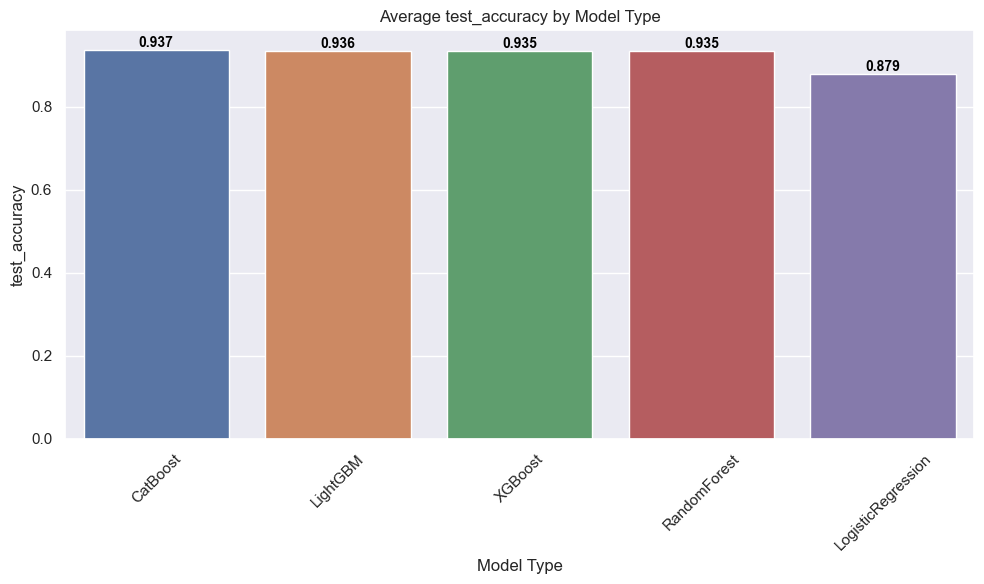

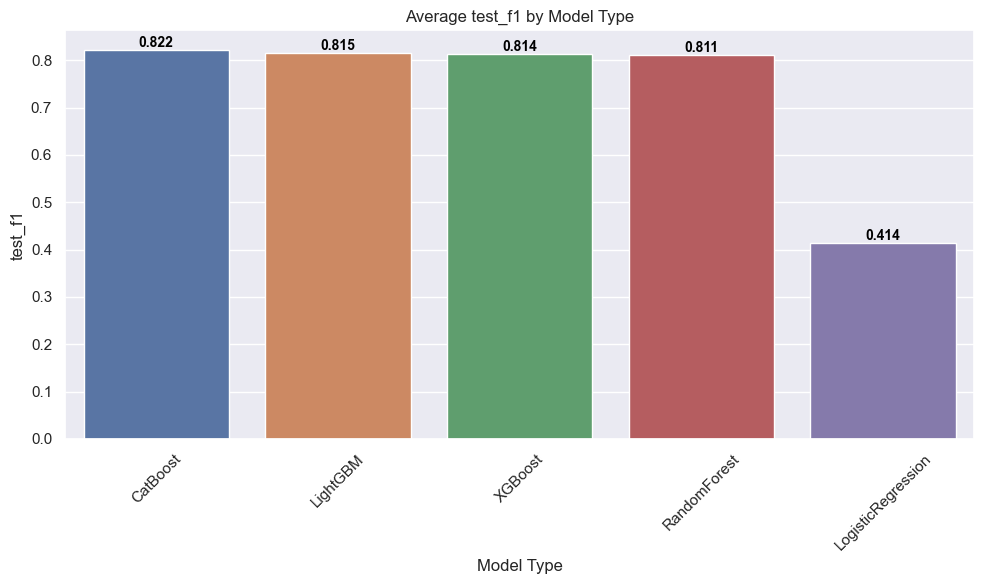

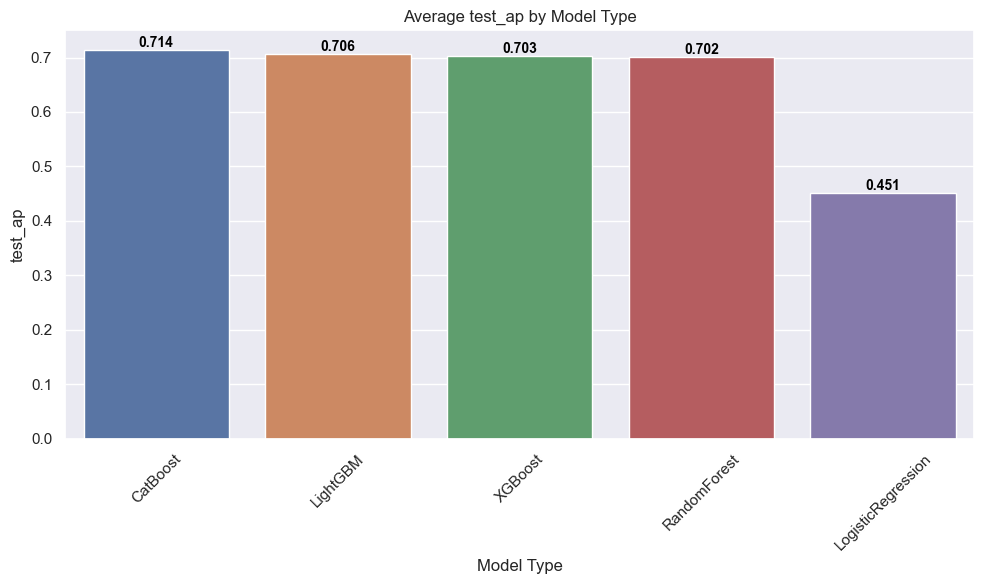

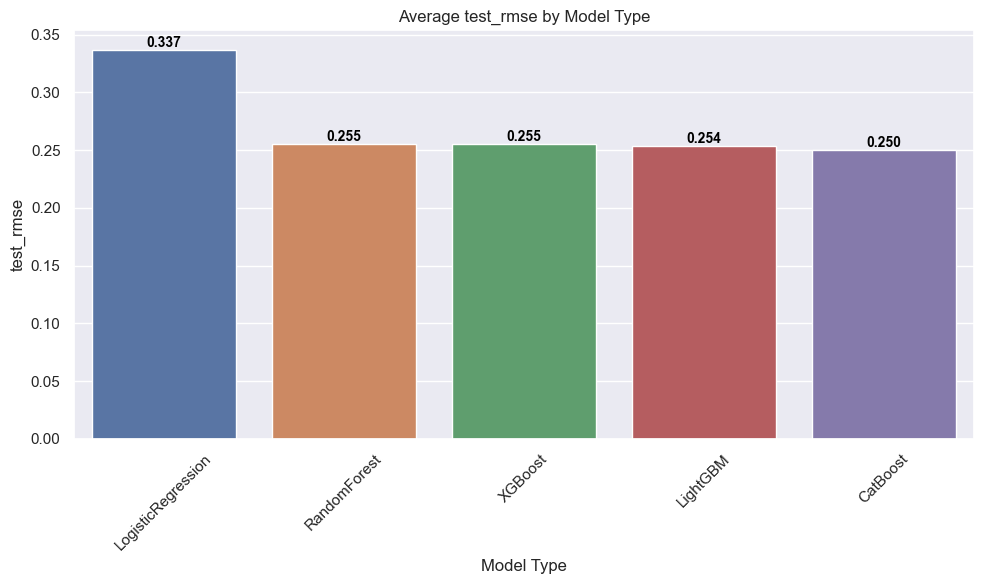

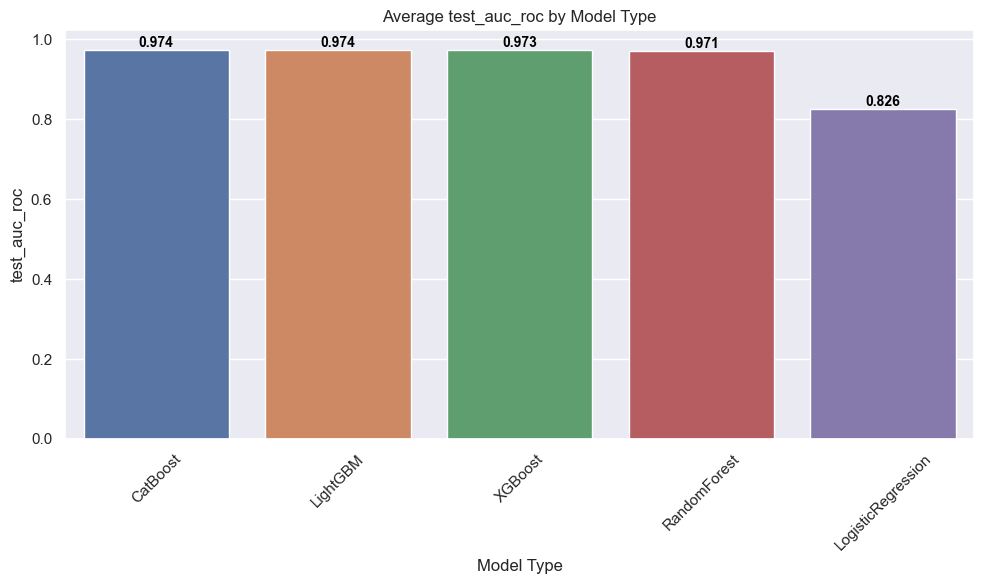

In [57]:
for metric in ['test_accuracy', 'test_f1', 'test_ap', 'test_rmse', 'test_auc_roc']:
    sorted_results = results_df.groupby('model_type', as_index=False)[metric].mean()
    sorted_results = sorted_results.sort_values(by=metric, ascending=False)
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=sorted_results, x="model_type", y=metric, order=sorted_results['model_type'])
    
    for i, row in enumerate(sorted_results.itertuples()):
        ax.text(i, row[2], f'{row[2]:.3f}', ha='center', va='bottom', fontsize=10, color='black', weight='bold')
    
    plt.title(f'Average {metric} by Model Type')
    plt.xlabel("Model Type")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**In summary of this part, we've trained some base model on different permutations of data - different imputation strategies, feature selection, etc. Ultimately, most models performed similiarly to each other in all metrics - with very slight differences.**

**The only model that did much worse is logistic regression - mainly because the non-scaled data permutations dipped its accuracy of course!**

**We will continue by choosing the model with the highest AUC-ROC (No changes to the data LGBM Classifier):**

In [58]:
best_model_data = next(tup for tup in training_data_variations if tup[0] == top_models_auc_roc['data_type'][0])

X_train, y_train, X_test = best_model_data[1], best_model_data[2].reset_index(drop=True), best_model_data[3]

## Hyperparameter Optimization ##

In [59]:
def objective(trial, scoring_metric, X_train_opt, y_train_opt):
    params = {
          "objective": "binary",
          "verbose": -1,
          "n_jobs": -1,
          "num_leaves": trial.suggest_int("num_leaves", 10, 200),
          "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
          "num_iterations": trial.suggest_int("numn_iterations", 10, 1000),
          "max_depth": trial.suggest_int("max_depth", 2, 12),
          "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
          "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
          "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
          "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
          "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),
          "subsample": trial.suggest_float("subsample", 0.25, 1.0),
          "scale_pos_weight": trial.suggest_uniform("scale_pos_weight", 0.1, 10)
    }

    model = lgb.LGBMClassifier(**params)
    metric_mean_value = cross_val_score(model, X_train_opt, y_train_opt,
                                        scoring=scoring_metric, cv=StratifiedKFold(n_splits=5)).mean()
    return metric_mean_value

In [95]:
results = []

X_train_lgb = pd.DataFrame(X_train)
X_train_lgb.columns = X.columns

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, 'accuracy', X_train_lgb, y_train), n_trials=50)  

best_params = study.best_params
model = lgb.LGBMClassifier(**best_params)
model.fit(X_train_lgb, y_train)

y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_ap = average_precision_score(y_test, y_pred)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
test_auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f"Test results for {data_type}:")
print(f"Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}, AP: {test_ap:.4f}, RMSE: {test_rmse:.4f}, AUC-ROC: {test_auc_roc:.4f}")

[I 2024-11-23 02:30:31,969] A new study created in memory with name: no-name-e5cb1bd8-a6b0-437a-8d26-cd3b762e77a0
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77


[I 2024-11-23 02:30:45,677] Trial 0 finished with value: 0.9064913527600094 and parameters: {'num_leaves': 151, 'learning_rate': 0.09058074849879726, 'numn_iterations': 624, 'max_depth': 5, 'min_data_in_leaf': 77, 'n_estimators': 338, 'reg_alpha': 0.6567439799188987, 'reg_lambda': 0.44624948173251944, 'colsample_bytree': 0.5596774582659172, 'subsample': 0.3218788346656297, 'scale_pos_weight': 8.77444447570129}. Best is trial 0 with value: 0.9064913527600094.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2024-11-23 02:30:56,631] Trial 1 finished with value: 0.9389639106057016 and parameters: {'num_leaves': 123, 'learning_rate': 0.026559725429530646, 'numn_iterations': 623, 'max_depth': 3, 'min_data_in_leaf': 12, 'n_estimators': 320, 'reg_alpha': 0.19369193108349161, 'reg_lambda': 2.1904661764357676, 'colsample_bytree': 0.9431278225954758, 'subsample': 0.46450027701298013, 'scale_pos_weight': 1.2224721184801328}. Best is trial 1 with value: 0.9389639106057016.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2024-11-23 02:31:05,860] Trial 2 finished with value: 0.925128326620864 and parameters: {'num_leaves': 105, 'learning_rate': 0.07162096087105381, 'numn_iterations': 324, 'max_depth': 6, 'min_data_in_leaf': 7, 'n_estimators': 927, 'reg_alpha': 0.9279388855314264, 'reg_lambda': 0.001899671148538678, 'colsample_bytree': 0.8350946801082777, 'subsample': 0.6340542891447342, 'scale_pos_weight': 3.901781590800019}. Best is trial 1 with value: 0.9389639106057016.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2024-11-23 02:31:17,906] Trial 3 finished with value: 0.9161809997630893 and parameters: {'num_leaves': 37, 'learning_rate': 0.0271876510529847, 'numn_iterations': 454, 'max_depth': 5, 'min_data_in_leaf': 11, 'n_estimators': 910, 'reg_alpha': 0.026696860040075387, 'reg_lambda': 0.026210466549883585, 'colsample_bytree': 0.5073759097907615, 'subsample': 0.2572974248658906, 'scale_pos_weight': 4.761971106554296}. Best is trial 1 with value: 0.9389639106057016.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63


[I 2024-11-23 02:31:30,619] Trial 4 finished with value: 0.9060175313906658 and parameters: {'num_leaves': 97, 'learning_rate': 0.018873004988002724, 'numn_iterations': 781, 'max_depth': 2, 'min_data_in_leaf': 63, 'n_estimators': 258, 'reg_alpha': 0.0014138729131514967, 'reg_lambda': 1.124847847877722, 'colsample_bytree': 0.5608105720325531, 'subsample': 0.7492009774969213, 'scale_pos_weight': 5.593479076113991}. Best is trial 1 with value: 0.9389639106057016.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37


[I 2024-11-23 02:31:35,147] Trial 5 finished with value: 0.912745794835347 and parameters: {'num_leaves': 65, 'learning_rate': 0.02213426193542869, 'numn_iterations': 132, 'max_depth': 7, 'min_data_in_leaf': 37, 'n_estimators': 703, 'reg_alpha': 0.07229886305615214, 'reg_lambda': 0.07351212545996472, 'colsample_bytree': 0.43842568549654315, 'subsample': 0.26104365006700203, 'scale_pos_weight': 4.6477223540337045}. Best is trial 1 with value: 0.9389639106057016.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


[I 2024-11-23 02:31:44,296] Trial 6 finished with value: 0.9295901445155177 and parameters: {'num_leaves': 91, 'learning_rate': 0.028519021263284813, 'numn_iterations': 247, 'max_depth': 8, 'min_data_in_leaf': 35, 'n_estimators': 221, 'reg_alpha': 0.036997925768925695, 'reg_lambda': 0.37888226884697246, 'colsample_bytree': 0.5782861084375732, 'subsample': 0.4959835697948263, 'scale_pos_weight': 0.3652344144560953}. Best is trial 1 with value: 0.9389639106057016.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2024-11-23 02:31:51,332] Trial 7 finished with value: 0.9103529969201611 and parameters: {'num_leaves': 101, 'learning_rate': 0.03961464245949504, 'numn_iterations': 163, 'max_depth': 10, 'min_data_in_leaf': 10, 'n_estimators': 320, 'reg_alpha': 0.5453318850127855, 'reg_lambda': 0.008886599897412719, 'colsample_bytree': 0.6738641721907053, 'subsample': 0.7421067048824627, 'scale_pos_weight': 6.353368985065417}. Best is trial 1 with value: 0.9389639106057016.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83


[I 2024-11-23 02:32:03,738] Trial 8 finished with value: 0.9037668798862828 and parameters: {'num_leaves': 12, 'learning_rate': 0.04270413912475672, 'numn_iterations': 663, 'max_depth': 12, 'min_data_in_leaf': 83, 'n_estimators': 247, 'reg_alpha': 1.8209797002560368, 'reg_lambda': 1.1308935734374375, 'colsample_bytree': 0.40408314095972553, 'subsample': 0.49626880844324084, 'scale_pos_weight': 7.15473641862759}. Best is trial 1 with value: 0.9389639106057016.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


[I 2024-11-23 02:32:16,725] Trial 9 finished with value: 0.9296533206980969 and parameters: {'num_leaves': 179, 'learning_rate': 0.012537687804889031, 'numn_iterations': 267, 'max_depth': 9, 'min_data_in_leaf': 52, 'n_estimators': 900, 'reg_alpha': 0.0018720989290971287, 'reg_lambda': 6.045443578757587, 'colsample_bytree': 0.5364801392674599, 'subsample': 0.36774653281661307, 'scale_pos_weight': 2.814451482420123}. Best is trial 1 with value: 0.9389639106057016.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2024-11-23 02:32:29,221] Trial 10 finished with value: 0.933507067835426 and parameters: {'num_leaves': 143, 'learning_rate': 0.26100045314188036, 'numn_iterations': 972, 'max_depth': 2, 'min_data_in_leaf': 29, 'n_estimators': 549, 'reg_alpha': 5.9913784893258955, 'reg_lambda': 5.4483932776850725, 'colsample_bytree': 0.9528640113821505, 'subsample': 0.9972602306627805, 'scale_pos_weight': 0.45201936899118067}. Best is trial 1 with value: 0.9389639106057016.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2024-11-23 02:32:43,111] Trial 11 finished with value: 0.91535970938956 and parameters: {'num_leaves': 144, 'learning_rate': 0.1969881701889867, 'numn_iterations': 995, 'max_depth': 2, 'min_data_in_leaf': 29, 'n_estimators': 519, 'reg_alpha': 4.437503326520971, 'reg_lambda': 5.700134090875732, 'colsample_bytree': 0.9923179195754375, 'subsample': 0.9571371872896497, 'scale_pos_weight': 0.18262412601318534}. Best is trial 1 with value: 0.9389639106057016.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2024-11-23 02:33:00,240] Trial 12 finished with value: 0.9322040590697307 and parameters: {'num_leaves': 148, 'learning_rate': 0.27881007659344875, 'numn_iterations': 956, 'max_depth': 3, 'min_data_in_leaf': 25, 'n_estimators': 522, 'reg_alpha': 0.007972791016031862, 'reg_lambda': 6.0157517084818455, 'colsample_bytree': 0.9723424513999327, 'subsample': 0.953182514242166, 'scale_pos_weight': 2.299229164904159}. Best is trial 1 with value: 0.9389639106057016.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


[I 2024-11-23 02:33:15,960] Trial 13 finished with value: 0.9357261312485192 and parameters: {'num_leaves': 200, 'learning_rate': 0.14284356526566833, 'numn_iterations': 821, 'max_depth': 4, 'min_data_in_leaf': 47, 'n_estimators': 115, 'reg_alpha': 6.887528146879393, 'reg_lambda': 1.3458918479945081, 'colsample_bytree': 0.8239081615495438, 'subsample': 0.8263805151247126, 'scale_pos_weight': 1.820642032247552}. Best is trial 1 with value: 0.9389639106057016.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


[I 2024-11-23 02:33:33,405] Trial 14 finished with value: 0.9341072415699282 and parameters: {'num_leaves': 195, 'learning_rate': 0.1307780190459897, 'numn_iterations': 795, 'max_depth': 4, 'min_data_in_leaf': 97, 'n_estimators': 133, 'reg_alpha': 0.21305121860991685, 'reg_lambda': 1.1912373720800542, 'colsample_bytree': 0.7828955122625911, 'subsample': 0.8059479739278641, 'scale_pos_weight': 2.1638952386004036}. Best is trial 1 with value: 0.9389639106057016.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


[I 2024-11-23 02:33:44,938] Trial 15 finished with value: 0.936657979941562 and parameters: {'num_leaves': 184, 'learning_rate': 0.11151805744991783, 'numn_iterations': 483, 'max_depth': 4, 'min_data_in_leaf': 60, 'n_estimators': 136, 'reg_alpha': 0.290937652383788, 'reg_lambda': 0.15977001367809096, 'colsample_bytree': 0.8472780833723702, 'subsample': 0.5031186941493443, 'scale_pos_weight': 1.7332608964370368}. Best is trial 1 with value: 0.9389639106057016.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


[I 2024-11-23 02:33:55,979] Trial 16 finished with value: 0.925689015241254 and parameters: {'num_leaves': 173, 'learning_rate': 0.06517944914691101, 'numn_iterations': 458, 'max_depth': 4, 'min_data_in_leaf': 64, 'n_estimators': 384, 'reg_alpha': 0.21647230519431856, 'reg_lambda': 0.1463442706416634, 'colsample_bytree': 0.7153697142265494, 'subsample': 0.48542772362949194, 'scale_pos_weight': 3.44705586189985}. Best is trial 1 with value: 0.9389639106057016.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


[I 2024-11-23 02:34:18,128] Trial 17 finished with value: 0.9382294874832189 and parameters: {'num_leaves': 125, 'learning_rate': 0.010248520183325923, 'numn_iterations': 574, 'max_depth': 6, 'min_data_in_leaf': 68, 'n_estimators': 431, 'reg_alpha': 0.1908921537393418, 'reg_lambda': 0.04779732432043438, 'colsample_bytree': 0.8832309046419036, 'subsample': 0.5963893445174844, 'scale_pos_weight': 1.1793139593757584}. Best is trial 1 with value: 0.9389639106057016.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


[I 2024-11-23 02:34:46,397] Trial 18 finished with value: 0.8962883992734738 and parameters: {'num_leaves': 120, 'learning_rate': 0.01343543816683336, 'numn_iterations': 600, 'max_depth': 7, 'min_data_in_leaf': 76, 'n_estimators': 678, 'reg_alpha': 0.011191662534730628, 'reg_lambda': 0.017897521696315186, 'colsample_bytree': 0.8937383325233819, 'subsample': 0.6229476671489713, 'scale_pos_weight': 9.612113615669756}. Best is trial 1 with value: 0.9389639106057016.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2024-11-23 02:34:48,019] Trial 19 finished with value: 0.8182895048566691 and parameters: {'num_leaves': 72, 'learning_rate': 0.011081247888905384, 'numn_iterations': 18, 'max_depth': 6, 'min_data_in_leaf': 95, 'n_estimators': 425, 'reg_alpha': 0.08162944247097846, 'reg_lambda': 0.004228457044746799, 'colsample_bytree': 0.3017040687736114, 'subsample': 0.6060640898188518, 'scale_pos_weight': 1.2772825739504725}. Best is trial 1 with value: 0.9389639106057016.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45


[I 2024-11-23 02:35:07,906] Trial 20 finished with value: 0.9275290215588724 and parameters: {'num_leaves': 124, 'learning_rate': 0.01720418501040311, 'numn_iterations': 372, 'max_depth': 11, 'min_data_in_leaf': 45, 'n_estimators': 658, 'reg_alpha': 2.0903546313565964, 'reg_lambda': 0.043944687640215585, 'colsample_bytree': 0.7395055575309463, 'subsample': 0.40209275332418287, 'scale_pos_weight': 3.2864188764449}. Best is trial 1 with value: 0.9389639106057016.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


[I 2024-11-23 02:35:20,083] Trial 21 finished with value: 0.9394693200663349 and parameters: {'num_leaves': 169, 'learning_rate': 0.09986360690353706, 'numn_iterations': 558, 'max_depth': 3, 'min_data_in_leaf': 64, 'n_estimators': 422, 'reg_alpha': 0.20766262475549088, 'reg_lambda': 0.1922235697055701, 'colsample_bytree': 0.8836523322669914, 'subsample': 0.5620777353880152, 'scale_pos_weight': 1.1849860610687424}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


[I 2024-11-23 02:35:33,404] Trial 22 finished with value: 0.9384585011450683 and parameters: {'num_leaves': 122, 'learning_rate': 0.04501933482797717, 'numn_iterations': 582, 'max_depth': 3, 'min_data_in_leaf': 70, 'n_estimators': 451, 'reg_alpha': 0.1361226963164793, 'reg_lambda': 0.28756634260912484, 'colsample_bytree': 0.893761064312507, 'subsample': 0.5908386905152355, 'scale_pos_weight': 0.8127235118147338}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


[I 2024-11-23 02:35:48,966] Trial 23 finished with value: 0.9391218510621495 and parameters: {'num_leaves': 172, 'learning_rate': 0.04324848805852941, 'numn_iterations': 704, 'max_depth': 3, 'min_data_in_leaf': 86, 'n_estimators': 482, 'reg_alpha': 0.05646208843775807, 'reg_lambda': 0.4833551846561718, 'colsample_bytree': 0.9223633679233222, 'subsample': 0.4293763065077578, 'scale_pos_weight': 1.091987223416743}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


[I 2024-11-23 02:36:05,587] Trial 24 finished with value: 0.9301903182500197 and parameters: {'num_leaves': 160, 'learning_rate': 0.033964949777311265, 'numn_iterations': 706, 'max_depth': 3, 'min_data_in_leaf': 86, 'n_estimators': 624, 'reg_alpha': 0.023073641543534487, 'reg_lambda': 0.5534137871886509, 'colsample_bytree': 0.9316882640711863, 'subsample': 0.42250733969855647, 'scale_pos_weight': 2.676364578961871}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2024-11-23 02:36:20,059] Trial 25 finished with value: 0.9391139540393272 and parameters: {'num_leaves': 169, 'learning_rate': 0.05159777651107064, 'numn_iterations': 735, 'max_depth': 3, 'min_data_in_leaf': 89, 'n_estimators': 780, 'reg_alpha': 0.04582316343969337, 'reg_lambda': 1.796739915875183, 'colsample_bytree': 0.7736633846515593, 'subsample': 0.4355759386511742, 'scale_pos_weight': 1.3271396598239087}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


[I 2024-11-23 02:36:43,845] Trial 26 finished with value: 0.9241885809049988 and parameters: {'num_leaves': 165, 'learning_rate': 0.06591052309398927, 'numn_iterations': 874, 'max_depth': 5, 'min_data_in_leaf': 86, 'n_estimators': 800, 'reg_alpha': 0.004388528538381741, 'reg_lambda': 0.2026676585259345, 'colsample_bytree': 0.7658933510675336, 'subsample': 0.3723647962045469, 'scale_pos_weight': 4.160758844407436}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2024-11-23 02:36:56,455] Trial 27 finished with value: 0.9279238726999921 and parameters: {'num_leaves': 184, 'learning_rate': 0.052693162349981254, 'numn_iterations': 739, 'max_depth': 2, 'min_data_in_leaf': 100, 'n_estimators': 762, 'reg_alpha': 0.04643483594474348, 'reg_lambda': 2.9921888660642644, 'colsample_bytree': 0.6677573477228809, 'subsample': 0.5538862961204841, 'scale_pos_weight': 2.9982359216677357}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2024-11-23 02:37:13,882] Trial 28 finished with value: 0.9371712864250178 and parameters: {'num_leaves': 162, 'learning_rate': 0.08759182584993229, 'numn_iterations': 865, 'max_depth': 3, 'min_data_in_leaf': 89, 'n_estimators': 592, 'reg_alpha': 0.010959957246649376, 'reg_lambda': 0.6493828149200209, 'colsample_bytree': 0.8041464650818033, 'subsample': 0.6719299902206233, 'scale_pos_weight': 1.7370956145774994}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75


[I 2024-11-23 02:37:32,224] Trial 29 finished with value: 0.9117902550738372 and parameters: {'num_leaves': 154, 'learning_rate': 0.09304469332958007, 'numn_iterations': 695, 'max_depth': 5, 'min_data_in_leaf': 75, 'n_estimators': 788, 'reg_alpha': 0.7074216626727041, 'reg_lambda': 0.09398724639056688, 'colsample_bytree': 0.7139697698503886, 'subsample': 0.3388477460389442, 'scale_pos_weight': 7.767538868385546}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80


[I 2024-11-23 02:37:45,934] Trial 30 finished with value: 0.9386085445786939 and parameters: {'num_leaves': 169, 'learning_rate': 0.0534166499980918, 'numn_iterations': 531, 'max_depth': 5, 'min_data_in_leaf': 80, 'n_estimators': 986, 'reg_alpha': 0.06961914857578237, 'reg_lambda': 2.235427858097189, 'colsample_bytree': 0.6300724796261423, 'subsample': 0.552092094584069, 'scale_pos_weight': 0.7523817080806454}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93


[I 2024-11-23 02:38:00,148] Trial 31 finished with value: 0.9389954986969913 and parameters: {'num_leaves': 131, 'learning_rate': 0.028966030076245326, 'numn_iterations': 659, 'max_depth': 3, 'min_data_in_leaf': 93, 'n_estimators': 329, 'reg_alpha': 0.42507400927508987, 'reg_lambda': 2.506719548360224, 'colsample_bytree': 0.9271052361208747, 'subsample': 0.43987015824472064, 'scale_pos_weight': 1.2460369603875}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2024-11-23 02:38:15,752] Trial 32 finished with value: 0.9383795309168443 and parameters: {'num_leaves': 139, 'learning_rate': 0.08461708618440306, 'numn_iterations': 642, 'max_depth': 4, 'min_data_in_leaf': 92, 'n_estimators': 487, 'reg_alpha': 0.5168482447632441, 'reg_lambda': 0.6452557721439055, 'colsample_bytree': 0.9134476330686505, 'subsample': 0.4290837192892379, 'scale_pos_weight': 1.2725498511332978}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2024-11-23 02:38:31,301] Trial 33 finished with value: 0.908418226328674 and parameters: {'num_leaves': 189, 'learning_rate': 0.034792739447593805, 'numn_iterations': 732, 'max_depth': 3, 'min_data_in_leaf': 92, 'n_estimators': 366, 'reg_alpha': 0.36624485224370995, 'reg_lambda': 2.896538022319167, 'colsample_bytree': 0.8762428554298934, 'subsample': 0.31446326788615947, 'scale_pos_weight': 0.14484854893844812}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


[I 2024-11-23 02:38:40,716] Trial 34 finished with value: 0.9300718629076838 and parameters: {'num_leaves': 132, 'learning_rate': 0.03348453607873759, 'numn_iterations': 527, 'max_depth': 2, 'min_data_in_leaf': 81, 'n_estimators': 290, 'reg_alpha': 1.128373570921118, 'reg_lambda': 9.207760592048581, 'colsample_bytree': 0.8472508679174493, 'subsample': 0.4380513321534253, 'scale_pos_weight': 2.442610844602772}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72


[I 2024-11-23 02:38:51,384] Trial 35 finished with value: 0.9367843323067204 and parameters: {'num_leaves': 155, 'learning_rate': 0.02250582902741153, 'numn_iterations': 428, 'max_depth': 3, 'min_data_in_leaf': 72, 'n_estimators': 378, 'reg_alpha': 0.10900442488232036, 'reg_lambda': 0.30742612793290586, 'colsample_bytree': 0.9986841245200976, 'subsample': 0.5456814529779207, 'scale_pos_weight': 1.4570547318481255}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


[I 2024-11-23 02:39:08,313] Trial 36 finished with value: 0.9391376451077944 and parameters: {'num_leaves': 175, 'learning_rate': 0.05762424584598592, 'numn_iterations': 643, 'max_depth': 4, 'min_data_in_leaf': 60, 'n_estimators': 205, 'reg_alpha': 0.02088753250291271, 'reg_lambda': 1.5476706319430331, 'colsample_bytree': 0.9314140233971502, 'subsample': 0.6733309719044551, 'scale_pos_weight': 0.9430011158685023}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


[I 2024-11-23 02:39:32,005] Trial 37 finished with value: 0.9233041143488905 and parameters: {'num_leaves': 173, 'learning_rate': 0.07435802118540472, 'numn_iterations': 899, 'max_depth': 4, 'min_data_in_leaf': 56, 'n_estimators': 176, 'reg_alpha': 0.023148827138140652, 'reg_lambda': 0.7289200262396043, 'colsample_bytree': 0.8625790648171412, 'subsample': 0.66058925191556, 'scale_pos_weight': 4.003686147964334}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


[I 2024-11-23 02:39:58,690] Trial 38 finished with value: 0.9210060807075733 and parameters: {'num_leaves': 179, 'learning_rate': 0.054123069682507324, 'numn_iterations': 760, 'max_depth': 6, 'min_data_in_leaf': 64, 'n_estimators': 596, 'reg_alpha': 0.037109334352774824, 'reg_lambda': 0.40574713716808447, 'colsample_bytree': 0.7975974737669911, 'subsample': 0.7105505812817572, 'scale_pos_weight': 5.464904326782532}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


[I 2024-11-23 02:40:06,013] Trial 39 finished with value: 0.9388454552633657 and parameters: {'num_leaves': 192, 'learning_rate': 0.11562415690970651, 'numn_iterations': 396, 'max_depth': 2, 'min_data_in_leaf': 56, 'n_estimators': 716, 'reg_alpha': 0.013476555523542823, 'reg_lambda': 1.5523678828337357, 'colsample_bytree': 0.958797483979102, 'subsample': 0.5396665696672749, 'scale_pos_weight': 0.8611615746320656}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


[I 2024-11-23 02:40:26,226] Trial 40 finished with value: 0.9341783147753298 and parameters: {'num_leaves': 77, 'learning_rate': 0.05964624074173711, 'numn_iterations': 552, 'max_depth': 8, 'min_data_in_leaf': 44, 'n_estimators': 842, 'reg_alpha': 0.004801405715747393, 'reg_lambda': 0.0014239475653418784, 'colsample_bytree': 0.8280928714912132, 'subsample': 0.3046792123959444, 'scale_pos_weight': 2.1680151508186847}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78


[I 2024-11-23 02:40:45,766] Trial 41 finished with value: 0.9367211561241412 and parameters: {'num_leaves': 110, 'learning_rate': 0.02919027955843915, 'numn_iterations': 658, 'max_depth': 5, 'min_data_in_leaf': 78, 'n_estimators': 194, 'reg_alpha': 0.06666108443887667, 'reg_lambda': 3.626570386557487, 'colsample_bytree': 0.9242343037640462, 'subsample': 0.4570546622293997, 'scale_pos_weight': 0.6024235370945212}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


[I 2024-11-23 02:40:59,027] Trial 42 finished with value: 0.939350864723999 and parameters: {'num_leaves': 135, 'learning_rate': 0.04618407476101455, 'numn_iterations': 614, 'max_depth': 3, 'min_data_in_leaf': 86, 'n_estimators': 292, 'reg_alpha': 0.13453869500925725, 'reg_lambda': 1.907682102380886, 'colsample_bytree': 0.9269070995403594, 'subsample': 0.3833085848071708, 'scale_pos_weight': 1.034137808867785}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85


[I 2024-11-23 02:41:10,469] Trial 43 finished with value: 0.9352681039248203 and parameters: {'num_leaves': 174, 'learning_rate': 0.04577459312189872, 'numn_iterations': 633, 'max_depth': 2, 'min_data_in_leaf': 85, 'n_estimators': 267, 'reg_alpha': 0.1433723977663648, 'reg_lambda': 1.6944776337466907, 'colsample_bytree': 0.9529193058895667, 'subsample': 0.2703961330815084, 'scale_pos_weight': 1.8776189533720338}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67


[I 2024-11-23 02:41:26,232] Trial 44 finished with value: 0.9393034825870646 and parameters: {'num_leaves': 155, 'learning_rate': 0.04027025125918495, 'numn_iterations': 708, 'max_depth': 3, 'min_data_in_leaf': 67, 'n_estimators': 288, 'reg_alpha': 0.050135325550782886, 'reg_lambda': 0.8712446291448648, 'colsample_bytree': 0.9051609203455551, 'subsample': 0.3917655839103731, 'scale_pos_weight': 0.926320050164629}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


[I 2024-11-23 02:41:43,763] Trial 45 finished with value: 0.9364289662797127 and parameters: {'num_leaves': 151, 'learning_rate': 0.03939902418947214, 'numn_iterations': 613, 'max_depth': 4, 'min_data_in_leaf': 68, 'n_estimators': 303, 'reg_alpha': 0.018883990515022077, 'reg_lambda': 0.8431093202636377, 'colsample_bytree': 0.9775186802418531, 'subsample': 0.35915714202513677, 'scale_pos_weight': 0.5685292145396237}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


[I 2024-11-23 02:41:55,147] Trial 46 finished with value: 0.9114901682065861 and parameters: {'num_leaves': 138, 'learning_rate': 0.1714121431885055, 'numn_iterations': 501, 'max_depth': 3, 'min_data_in_leaf': 51, 'n_estimators': 226, 'reg_alpha': 0.03232135517680518, 'reg_lambda': 0.25355054341849853, 'colsample_bytree': 0.915510138449444, 'subsample': 0.3817137695745603, 'scale_pos_weight': 0.14228417658505588}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2024-11-23 02:42:08,914] Trial 47 finished with value: 0.9026691937139699 and parameters: {'num_leaves': 110, 'learning_rate': 0.023039917549590318, 'numn_iterations': 688, 'max_depth': 2, 'min_data_in_leaf': 59, 'n_estimators': 188, 'reg_alpha': 0.05226695744283194, 'reg_lambda': 0.9504045068663209, 'colsample_bytree': 0.4825488667702258, 'subsample': 0.7806183900541854, 'scale_pos_weight': 6.276438321465721}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74


[I 2024-11-23 02:42:31,541] Trial 48 finished with value: 0.9383163547342651 and parameters: {'num_leaves': 43, 'learning_rate': 0.07660875658697046, 'numn_iterations': 780, 'max_depth': 5, 'min_data_in_leaf': 74, 'n_estimators': 473, 'reg_alpha': 0.1143701039236354, 'reg_lambda': 0.39419496353911215, 'colsample_bytree': 0.6153789620315813, 'subsample': 0.2938192236596021, 'scale_pos_weight': 1.021715771008108}. Best is trial 21 with value: 0.9394693200663349.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


[I 2024-11-23 02:42:52,632] Trial 49 finished with value: 0.935599778883361 and parameters: {'num_leaves': 160, 'learning_rate': 0.039202229598216884, 'numn_iterations': 843, 'max_depth': 4, 'min_data_in_leaf': 38, 'n_estimators': 406, 'reg_alpha': 0.005338700454239742, 'reg_lambda': 0.17830445766859845, 'colsample_bytree': 0.9500633419579942, 'subsample': 0.8601604327825461, 'scale_pos_weight': 1.9681202368943778}. Best is trial 21 with value: 0.9394693200663349.


[LightGBM] [Warning] Unknown parameter: numn_iterations
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
Test results for no_dropped_columns-not_encoded-imputed_0-not_scaled-kept_outliers:
Accuracy: 0.9400, F1: 0.8348, AP: 0.7271, RMSE: 0.2449, AUC-ROC: 0.9753


**This model produced an accuracy of 94.00% on the test set with roc-auc of 0.9753!**

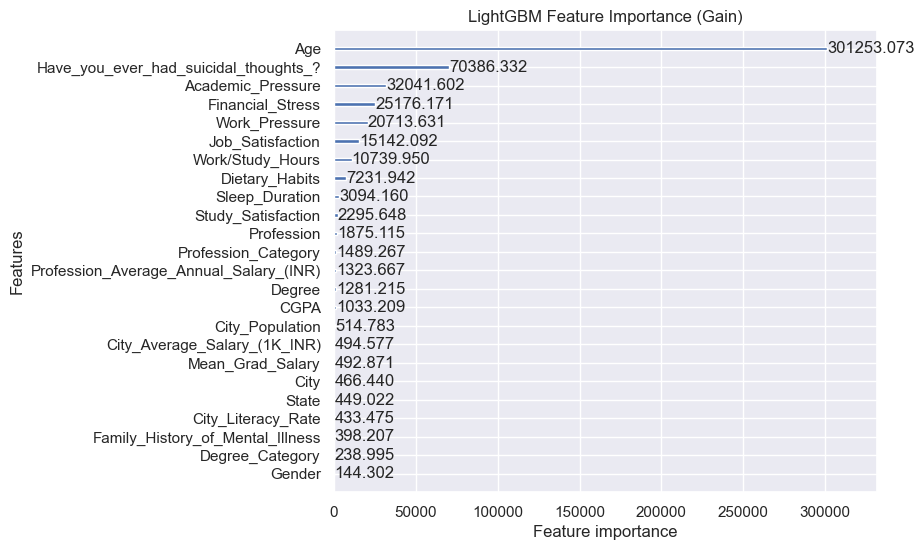

In [96]:
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

**As expected, some of the most influencial features include age (younger people are more depressed), work hours (more hours lead to depression) and financial stress (same), while gender, family history and state, for example, are less significant features in the decision making of the model.**

**We'll also try to separate to 2 models: model for students and model for workers (with the same train splits of course):**

In [62]:
columns_to_drop_students = ['Profession Average Annual Salary (INR)', 'Profession Category',
                            'Job Satisfaction', 'Working Professional or Student', 'Profession', 'Work Pressure']

X_train_stud = pd.DataFrame(X_train)
X_train_stud.columns = X.columns
X_test_stud = pd.DataFrame(X_test)
X_test_stud.columns = X.columns

X_train_stud = X_train_stud[X_train_stud['Working Professional or Student'] == 1].drop(columns=columns_to_drop_students)
X_test_stud = X_test_stud[X_test_stud['Working Professional or Student'] == 1].drop(columns=columns_to_drop_students)

y_train_stud = y_train.iloc[X_train_stud.index]
y_test_stud = y_test.iloc[X_test_stud.index]

In [63]:
results_students = []

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, 'accuracy', X_train_stud, y_train_stud), n_trials=50)  

best_params = study.best_params
students_model = lgb.LGBMClassifier(**best_params)
students_model.fit(X_train_stud, y_train_stud)

y_pred_stud = students_model.predict(X_test_stud)
y_pred_stud_proba = students_model.predict_proba(X_test_stud)[:, 1]

[I 2024-11-22 17:00:43,533] A new study created in memory with name: no-name-0a8826a5-1cc4-4555-963a-5be205f3deee
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58


[I 2024-11-22 17:00:47,288] Trial 0 finished with value: 0.8066582872640199 and parameters: {'num_leaves': 73, 'learning_rate': 0.02255243140306192, 'numn_iterations': 818, 'max_depth': 3, 'min_data_in_leaf': 58, 'n_estimators': 460, 'reg_alpha': 0.0363496728938289, 'reg_lambda': 1.2637178001025726, 'colsample_bytree': 0.377757128548735, 'subsample': 0.41279677733737563, 'scale_pos_weight': 4.101558742819645}. Best is trial 0 with value: 0.8066582872640199.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2024-11-22 17:00:59,892] Trial 1 finished with value: 0.78605533411385 and parameters: {'num_leaves': 200, 'learning_rate': 0.014672702367785976, 'numn_iterations': 600, 'max_depth': 11, 'min_data_in_leaf': 92, 'n_estimators': 779, 'reg_alpha': 0.024180800403165628, 'reg_lambda': 0.00665123704494631, 'colsample_bytree': 0.41684435389790875, 'subsample': 0.5812931031731527, 'scale_pos_weight': 8.260598902112863}. Best is trial 0 with value: 0.8066582872640199.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


[I 2024-11-22 17:01:06,628] Trial 2 finished with value: 0.8370853742011528 and parameters: {'num_leaves': 33, 'learning_rate': 0.03311439049919944, 'numn_iterations': 688, 'max_depth': 11, 'min_data_in_leaf': 8, 'n_estimators': 842, 'reg_alpha': 5.054306205143904, 'reg_lambda': 7.007214143492551, 'colsample_bytree': 0.9112280618676503, 'subsample': 0.934674667818761, 'scale_pos_weight': 2.1861924414436302}. Best is trial 2 with value: 0.8370853742011528.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2024-11-22 17:01:26,315] Trial 3 finished with value: 0.83092034378805 and parameters: {'num_leaves': 129, 'learning_rate': 0.054472344673621484, 'numn_iterations': 928, 'max_depth': 8, 'min_data_in_leaf': 28, 'n_estimators': 302, 'reg_alpha': 0.14464296695515094, 'reg_lambda': 0.03031459644683255, 'colsample_bytree': 0.9137812022283276, 'subsample': 0.8317492605841736, 'scale_pos_weight': 6.7127092462243745}. Best is trial 2 with value: 0.8370853742011528.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


[I 2024-11-22 17:01:30,376] Trial 4 finished with value: 0.8133005180929131 and parameters: {'num_leaves': 17, 'learning_rate': 0.08407467530048574, 'numn_iterations': 663, 'max_depth': 4, 'min_data_in_leaf': 14, 'n_estimators': 269, 'reg_alpha': 0.001212700665801554, 'reg_lambda': 0.5430985055891644, 'colsample_bytree': 0.886859902611624, 'subsample': 0.3021282976211638, 'scale_pos_weight': 4.617642440933639}. Best is trial 2 with value: 0.8370853742011528.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


[I 2024-11-22 17:01:33,975] Trial 5 finished with value: 0.8309200590433876 and parameters: {'num_leaves': 182, 'learning_rate': 0.22638138365505678, 'numn_iterations': 453, 'max_depth': 6, 'min_data_in_leaf': 50, 'n_estimators': 308, 'reg_alpha': 0.0073198573533228145, 'reg_lambda': 0.2777747723043356, 'colsample_bytree': 0.3079829708460286, 'subsample': 0.6518266264351217, 'scale_pos_weight': 1.132843427496343}. Best is trial 2 with value: 0.8370853742011528.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2024-11-22 17:01:41,606] Trial 6 finished with value: 0.7739243572640657 and parameters: {'num_leaves': 120, 'learning_rate': 0.011567303860069246, 'numn_iterations': 542, 'max_depth': 7, 'min_data_in_leaf': 23, 'n_estimators': 779, 'reg_alpha': 0.004802536024801108, 'reg_lambda': 5.785288871890743, 'colsample_bytree': 0.6654209046697799, 'subsample': 0.6477947774498439, 'scale_pos_weight': 9.315363877551535}. Best is trial 2 with value: 0.8370853742011528.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2024-11-22 17:01:44,039] Trial 7 finished with value: 0.7907886209072503 and parameters: {'num_leaves': 198, 'learning_rate': 0.046705105845327714, 'numn_iterations': 445, 'max_depth': 4, 'min_data_in_leaf': 26, 'n_estimators': 529, 'reg_alpha': 2.086204815519784, 'reg_lambda': 0.010244575550857837, 'colsample_bytree': 0.6554306490074221, 'subsample': 0.9219899012631702, 'scale_pos_weight': 6.189425072191309}. Best is trial 2 with value: 0.8370853742011528.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48


[I 2024-11-22 17:01:47,203] Trial 8 finished with value: 0.8156868998314153 and parameters: {'num_leaves': 58, 'learning_rate': 0.13599866461356483, 'numn_iterations': 519, 'max_depth': 8, 'min_data_in_leaf': 48, 'n_estimators': 456, 'reg_alpha': 9.95225492905293, 'reg_lambda': 0.024676845995640368, 'colsample_bytree': 0.3776103506370236, 'subsample': 0.6204569501300033, 'scale_pos_weight': 4.887314058155974}. Best is trial 2 with value: 0.8370853742011528.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


[I 2024-11-22 17:01:51,959] Trial 9 finished with value: 0.8274998248029369 and parameters: {'num_leaves': 118, 'learning_rate': 0.0781098075511469, 'numn_iterations': 422, 'max_depth': 7, 'min_data_in_leaf': 90, 'n_estimators': 201, 'reg_alpha': 0.009689012939794364, 'reg_lambda': 0.03142382790735505, 'colsample_bytree': 0.7274749987812326, 'subsample': 0.991861626850618, 'scale_pos_weight': 4.0403053909396}. Best is trial 2 with value: 0.8370853742011528.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


Found `num_iterations` in params. Will use it instead of argument
[I 2024-11-22 17:01:52,299] Trial 10 finished with value: 0.7235699608934845 and parameters: {'num_leaves': 17, 'learning_rate': 0.02868753651347077, 'numn_iterations': 22, 'max_depth': 12, 'min_data_in_leaf': 70, 'n_estimators': 963, 'reg_alpha': 0.49671870278304875, 'reg_lambda': 0.0011112376618762547, 'colsample_bytree': 0.8108591628145104, 'subsample': 0.7905182646680662, 'scale_pos_weight': 0.13256572954011503}. Best is trial 2 with value: 0.8370853742011528.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2024-11-22 17:02:12,884] Trial 11 finished with value: 0.831238538038644 and parameters: {'num_leaves': 145, 'learning_rate': 0.04699215498209013, 'numn_iterations': 991, 'max_depth': 10, 'min_data_in_leaf': 9, 'n_estimators': 766, 'reg_alpha': 0.22493200643031147, 'reg_lambda': 8.479033532631416, 'colsample_bytree': 0.927263333444667, 'subsample': 0.8222475168472531, 'scale_pos_weight': 6.9058747662873525}. Best is trial 2 with value: 0.8370853742011528.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-11-22 17:02:38,450] Trial 12 finished with value: 0.8372839282361191 and parameters: {'num_leaves': 159, 'learning_rate': 0.03081609639366405, 'numn_iterations': 999, 'max_depth': 10, 'min_data_in_leaf': 5, 'n_estimators': 739, 'reg_alpha': 1.068218843200372, 'reg_lambda': 6.714317524432398, 'colsample_bytree': 0.9907126458247463, 'subsample': 0.8220471027646705, 'scale_pos_weight': 2.2818776873177424}. Best is trial 12 with value: 0.8372839282361191.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-11-22 17:02:50,691] Trial 13 finished with value: 0.8357726696694574 and parameters: {'num_leaves': 79, 'learning_rate': 0.02470623111149265, 'numn_iterations': 766, 'max_depth': 10, 'min_data_in_leaf': 5, 'n_estimators': 958, 'reg_alpha': 2.0725361900157044, 'reg_lambda': 2.210385118643711, 'colsample_bytree': 0.9941543219461846, 'subsample': 0.9985116672529212, 'scale_pos_weight': 2.378722331138855}. Best is trial 12 with value: 0.8372839282361191.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


[I 2024-11-22 17:02:55,382] Trial 14 finished with value: 0.828732721733437 and parameters: {'num_leaves': 163, 'learning_rate': 0.034871046750606476, 'numn_iterations': 273, 'max_depth': 12, 'min_data_in_leaf': 38, 'n_estimators': 665, 'reg_alpha': 7.721443668980203, 'reg_lambda': 2.534071605008592, 'colsample_bytree': 0.5215625492286289, 'subsample': 0.7679149796176745, 'scale_pos_weight': 2.6425692779796326}. Best is trial 12 with value: 0.8372839282361191.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2024-11-22 17:03:05,345] Trial 15 finished with value: 0.8363693362902487 and parameters: {'num_leaves': 49, 'learning_rate': 0.016580175535156755, 'numn_iterations': 830, 'max_depth': 10, 'min_data_in_leaf': 18, 'n_estimators': 650, 'reg_alpha': 0.9715168528581345, 'reg_lambda': 0.16209214473556363, 'colsample_bytree': 0.8009862768075576, 'subsample': 0.899176591800706, 'scale_pos_weight': 2.2571842452412065}. Best is trial 12 with value: 0.8372839282361191.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=34, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=34


[I 2024-11-22 17:03:19,344] Trial 16 finished with value: 0.8334260968166655 and parameters: {'num_leaves': 94, 'learning_rate': 0.08992293592413828, 'numn_iterations': 712, 'max_depth': 9, 'min_data_in_leaf': 34, 'n_estimators': 878, 'reg_alpha': 2.9390565225687326, 'reg_lambda': 0.736021083917521, 'colsample_bytree': 0.9855286040486697, 'subsample': 0.7510187556342991, 'scale_pos_weight': 3.2235136148552828}. Best is trial 12 with value: 0.8372839282361191.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70


[I 2024-11-22 17:03:28,605] Trial 17 finished with value: 0.84324999331641 and parameters: {'num_leaves': 37, 'learning_rate': 0.03576568670113825, 'numn_iterations': 906, 'max_depth': 11, 'min_data_in_leaf': 70, 'n_estimators': 672, 'reg_alpha': 0.514366676092575, 'reg_lambda': 9.830782067186163, 'colsample_bytree': 0.8285353930573536, 'subsample': 0.5068725243637591, 'scale_pos_weight': 1.1227117761261676}. Best is trial 17 with value: 0.84324999331641.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


[I 2024-11-22 17:03:42,759] Trial 18 finished with value: 0.7990609279227417 and parameters: {'num_leaves': 155, 'learning_rate': 0.018993564169906777, 'numn_iterations': 882, 'max_depth': 9, 'min_data_in_leaf': 76, 'n_estimators': 602, 'reg_alpha': 0.46988427339658223, 'reg_lambda': 2.9622739549542056, 'colsample_bytree': 0.8130154171141551, 'subsample': 0.4915887072926808, 'scale_pos_weight': 0.19147098671944018}. Best is trial 17 with value: 0.84324999331641.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


[I 2024-11-22 17:03:55,652] Trial 19 finished with value: 0.827380421874528 and parameters: {'num_leaves': 94, 'learning_rate': 0.2896036740370293, 'numn_iterations': 985, 'max_depth': 12, 'min_data_in_leaf': 68, 'n_estimators': 693, 'reg_alpha': 0.06474218850136154, 'reg_lambda': 0.42181565320775366, 'colsample_bytree': 0.7446672641307897, 'subsample': 0.5207153603529591, 'scale_pos_weight': 1.1312638753142705}. Best is trial 17 with value: 0.84324999331641.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


[I 2024-11-22 17:03:58,884] Trial 20 finished with value: 0.8432900157606171 and parameters: {'num_leaves': 141, 'learning_rate': 0.010670403520184085, 'numn_iterations': 273, 'max_depth': 6, 'min_data_in_leaf': 81, 'n_estimators': 523, 'reg_alpha': 0.713453357300673, 'reg_lambda': 0.10745013489011007, 'colsample_bytree': 0.5785079330824354, 'subsample': 0.3134168393876491, 'scale_pos_weight': 1.264705871211997}. Best is trial 20 with value: 0.8432900157606171.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


[I 2024-11-22 17:04:01,365] Trial 21 finished with value: 0.8431705020981726 and parameters: {'num_leaves': 140, 'learning_rate': 0.010026644205086503, 'numn_iterations': 280, 'max_depth': 5, 'min_data_in_leaf': 81, 'n_estimators': 500, 'reg_alpha': 0.7581617312095574, 'reg_lambda': 0.001783873821494811, 'colsample_bytree': 0.5552198464102501, 'subsample': 0.28739354689680774, 'scale_pos_weight': 1.1415015649026397}. Best is trial 20 with value: 0.8432900157606171.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


[I 2024-11-22 17:04:03,563] Trial 22 finished with value: 0.8436080201814361 and parameters: {'num_leaves': 137, 'learning_rate': 0.01025098026771663, 'numn_iterations': 257, 'max_depth': 5, 'min_data_in_leaf': 82, 'n_estimators': 421, 'reg_alpha': 0.3033206543852048, 'reg_lambda': 0.001801777250486277, 'colsample_bytree': 0.5488696179820398, 'subsample': 0.2722325507166742, 'scale_pos_weight': 1.1924685704013551}. Best is trial 22 with value: 0.8436080201814361.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2024-11-22 17:04:04,515] Trial 23 finished with value: 0.8209369744582456 and parameters: {'num_leaves': 107, 'learning_rate': 0.013347605527958955, 'numn_iterations': 181, 'max_depth': 2, 'min_data_in_leaf': 100, 'n_estimators': 373, 'reg_alpha': 0.22572074804721856, 'reg_lambda': 0.11305331076412847, 'colsample_bytree': 0.5679677851845315, 'subsample': 0.37263876309669025, 'scale_pos_weight': 1.3061493657596683}. Best is trial 22 with value: 0.8436080201814361.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2024-11-22 17:04:06,149] Trial 24 finished with value: 0.7489063669381075 and parameters: {'num_leaves': 173, 'learning_rate': 0.01015939115935638, 'numn_iterations': 133, 'max_depth': 6, 'min_data_in_leaf': 59, 'n_estimators': 401, 'reg_alpha': 0.3016434958548875, 'reg_lambda': 0.0037640599429827346, 'colsample_bytree': 0.5041655476876253, 'subsample': 0.2560781382226152, 'scale_pos_weight': 3.392449077190313}. Best is trial 22 with value: 0.8436080201814361.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


[I 2024-11-22 17:04:08,718] Trial 25 finished with value: 0.842056960638638 and parameters: {'num_leaves': 136, 'learning_rate': 0.01835252304371712, 'numn_iterations': 307, 'max_depth': 5, 'min_data_in_leaf': 82, 'n_estimators': 589, 'reg_alpha': 0.09886417186499706, 'reg_lambda': 0.04909979346663069, 'colsample_bytree': 0.6032763170600303, 'subsample': 0.36782294699085727, 'scale_pos_weight': 1.5786548315977253}. Best is trial 22 with value: 0.8436080201814361.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68


[I 2024-11-22 17:04:10,322] Trial 26 finished with value: 0.727905277473391 and parameters: {'num_leaves': 110, 'learning_rate': 0.012898769059272168, 'numn_iterations': 190, 'max_depth': 6, 'min_data_in_leaf': 68, 'n_estimators': 127, 'reg_alpha': 1.3812602004496608, 'reg_lambda': 0.011876663900596498, 'colsample_bytree': 0.7011857119084351, 'subsample': 0.4499852310717024, 'scale_pos_weight': 0.1553222937030423}. Best is trial 22 with value: 0.8436080201814361.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2024-11-22 17:04:12,391] Trial 27 finished with value: 0.8038740855939291 and parameters: {'num_leaves': 94, 'learning_rate': 0.14174742267652327, 'numn_iterations': 361, 'max_depth': 4, 'min_data_in_leaf': 89, 'n_estimators': 578, 'reg_alpha': 0.05536118150007514, 'reg_lambda': 0.07991629981550495, 'colsample_bytree': 0.4731700200542557, 'subsample': 0.3333602849198284, 'scale_pos_weight': 5.607223863895163}. Best is trial 22 with value: 0.8436080201814361.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75


Found `num_iterations` in params. Will use it instead of argument
[I 2024-11-22 17:04:12,699] Trial 28 finished with value: 0.5975658760731117 and parameters: {'num_leaves': 125, 'learning_rate': 0.02045247262902014, 'numn_iterations': 15, 'max_depth': 5, 'min_data_in_leaf': 75, 'n_estimators': 386, 'reg_alpha': 0.46272994739133083, 'reg_lambda': 0.0030858960176832445, 'colsample_bytree': 0.46539149055063256, 'subsample': 0.4124753115997791, 'scale_pos_weight': 3.50451531209335}. Best is trial 22 with value: 0.8436080201814361.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2024-11-22 17:04:13,447] Trial 29 finished with value: 0.8303630193881059 and parameters: {'num_leaves': 66, 'learning_rate': 0.023478934822492227, 'numn_iterations': 141, 'max_depth': 2, 'min_data_in_leaf': 59, 'n_estimators': 453, 'reg_alpha': 0.027162919280488453, 'reg_lambda': 1.0378028746155363, 'colsample_bytree': 0.6025026987329113, 'subsample': 0.43707584829356805, 'scale_pos_weight': 0.7217277796193088}. Best is trial 22 with value: 0.8436080201814361.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


[I 2024-11-22 17:04:15,137] Trial 30 finished with value: 0.8343804976482463 and parameters: {'num_leaves': 79, 'learning_rate': 0.01577851264343424, 'numn_iterations': 359, 'max_depth': 3, 'min_data_in_leaf': 99, 'n_estimators': 516, 'reg_alpha': 0.12142138933479876, 'reg_lambda': 0.1686444713752702, 'colsample_bytree': 0.6231086153860328, 'subsample': 0.5330050747947228, 'scale_pos_weight': 1.7424157382367778}. Best is trial 22 with value: 0.8436080201814361.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83


[I 2024-11-22 17:04:17,569] Trial 31 finished with value: 0.841141743836425 and parameters: {'num_leaves': 146, 'learning_rate': 0.010706110055487718, 'numn_iterations': 271, 'max_depth': 5, 'min_data_in_leaf': 83, 'n_estimators': 498, 'reg_alpha': 0.6681928772207097, 'reg_lambda': 0.001129079403247961, 'colsample_bytree': 0.5657498868929001, 'subsample': 0.2534900459139972, 'scale_pos_weight': 0.6825765118555515}. Best is trial 22 with value: 0.8436080201814361.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


[I 2024-11-22 17:04:19,973] Trial 32 finished with value: 0.8033966874387897 and parameters: {'num_leaves': 136, 'learning_rate': 0.014561649280015337, 'numn_iterations': 210, 'max_depth': 6, 'min_data_in_leaf': 82, 'n_estimators': 430, 'reg_alpha': 0.30103185606682764, 'reg_lambda': 0.002426614712895669, 'colsample_bytree': 0.5467182039394468, 'subsample': 0.3072212830285577, 'scale_pos_weight': 2.919911114160354}. Best is trial 22 with value: 0.8436080201814361.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


[I 2024-11-22 17:04:20,866] Trial 33 finished with value: 0.7744810884459634 and parameters: {'num_leaves': 174, 'learning_rate': 0.010204678832526709, 'numn_iterations': 101, 'max_depth': 5, 'min_data_in_leaf': 76, 'n_estimators': 627, 'reg_alpha': 3.9594357840476304, 'reg_lambda': 0.005917390258642139, 'colsample_bytree': 0.44339075880541773, 'subsample': 0.37622648797576136, 'scale_pos_weight': 1.7077478613840964}. Best is trial 22 with value: 0.8436080201814361.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2024-11-22 17:04:23,360] Trial 34 finished with value: 0.8441645298952629 and parameters: {'num_leaves': 142, 'learning_rate': 0.012918306228933224, 'numn_iterations': 579, 'max_depth': 3, 'min_data_in_leaf': 94, 'n_estimators': 542, 'reg_alpha': 0.6589994677256227, 'reg_lambda': 0.001552699321524792, 'colsample_bytree': 0.39019904231602176, 'subsample': 0.2961732592614546, 'scale_pos_weight': 0.7768747490154894}. Best is trial 34 with value: 0.8441645298952629.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2024-11-22 17:04:26,231] Trial 35 finished with value: 0.841738434185938 and parameters: {'num_leaves': 42, 'learning_rate': 0.01318558830555893, 'numn_iterations': 662, 'max_depth': 3, 'min_data_in_leaf': 92, 'n_estimators': 719, 'reg_alpha': 1.5722444468683296, 'reg_lambda': 0.015239155255371754, 'colsample_bytree': 0.3656384126192921, 'subsample': 0.33417468631471936, 'scale_pos_weight': 0.6400437142520361}. Best is trial 34 with value: 0.8441645298952629.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63


[I 2024-11-22 17:04:28,577] Trial 36 finished with value: 0.8074140075074512 and parameters: {'num_leaves': 148, 'learning_rate': 0.03578775786008623, 'numn_iterations': 597, 'max_depth': 3, 'min_data_in_leaf': 63, 'n_estimators': 825, 'reg_alpha': 0.14146884632448023, 'reg_lambda': 0.007000678711306333, 'colsample_bytree': 0.3162946121604207, 'subsample': 0.4020787493792808, 'scale_pos_weight': 4.006805118611135}. Best is trial 34 with value: 0.8441645298952629.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2024-11-22 17:04:37,595] Trial 37 finished with value: 0.8375625034307778 and parameters: {'num_leaves': 130, 'learning_rate': 0.01683753283889166, 'numn_iterations': 586, 'max_depth': 8, 'min_data_in_leaf': 95, 'n_estimators': 548, 'reg_alpha': 0.23830910758101612, 'reg_lambda': 0.004899510907104198, 'colsample_bytree': 0.4160717631390566, 'subsample': 0.3349746292257826, 'scale_pos_weight': 1.8862881458742184}. Best is trial 34 with value: 0.8441645298952629.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87


[I 2024-11-22 17:04:39,640] Trial 38 finished with value: 0.7793732311226549 and parameters: {'num_leaves': 187, 'learning_rate': 0.06333841354410753, 'numn_iterations': 354, 'max_depth': 4, 'min_data_in_leaf': 87, 'n_estimators': 285, 'reg_alpha': 0.4329635830799146, 'reg_lambda': 0.00170576669351513, 'colsample_bytree': 0.6886808031757015, 'subsample': 0.4672368514895388, 'scale_pos_weight': 7.846352827434089}. Best is trial 34 with value: 0.8441645298952629.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2024-11-22 17:04:45,263] Trial 39 finished with value: 0.8440851573206348 and parameters: {'num_leaves': 116, 'learning_rate': 0.012226667703264114, 'numn_iterations': 475, 'max_depth': 7, 'min_data_in_leaf': 96, 'n_estimators': 226, 'reg_alpha': 3.1334961190566366, 'reg_lambda': 0.35656664267770405, 'colsample_bytree': 0.8540397991063186, 'subsample': 0.5600606054441689, 'scale_pos_weight': 0.6965736630703978}. Best is trial 34 with value: 0.8441645298952629.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2024-11-22 17:04:50,419] Trial 40 finished with value: 0.7417867775019447 and parameters: {'num_leaves': 114, 'learning_rate': 0.012542463561644403, 'numn_iterations': 503, 'max_depth': 7, 'min_data_in_leaf': 95, 'n_estimators': 341, 'reg_alpha': 4.326398024384749, 'reg_lambda': 0.3573910794784795, 'colsample_bytree': 0.41056632197601833, 'subsample': 0.6953215163059845, 'scale_pos_weight': 9.476416714303845}. Best is trial 34 with value: 0.8441645298952629.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


[I 2024-11-22 17:04:56,523] Trial 41 finished with value: 0.8455965898979239 and parameters: {'num_leaves': 127, 'learning_rate': 0.014656083112295966, 'numn_iterations': 426, 'max_depth': 8, 'min_data_in_leaf': 86, 'n_estimators': 559, 'reg_alpha': 2.462706380389749, 'reg_lambda': 0.06700115121912667, 'colsample_bytree': 0.8658237432405754, 'subsample': 0.5762089663361647, 'scale_pos_weight': 0.9008062820954628}. Best is trial 41 with value: 0.8455965898979239.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


[I 2024-11-22 17:05:02,320] Trial 42 finished with value: 0.8429714181217515 and parameters: {'num_leaves': 125, 'learning_rate': 0.014893422792797753, 'numn_iterations': 411, 'max_depth': 8, 'min_data_in_leaf': 86, 'n_estimators': 132, 'reg_alpha': 2.677302923899392, 'reg_lambda': 0.18636868303057455, 'colsample_bytree': 0.8463464598402777, 'subsample': 0.5916279122309679, 'scale_pos_weight': 0.7375009335169529}. Best is trial 41 with value: 0.8455965898979239.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95


[I 2024-11-22 17:05:07,142] Trial 43 finished with value: 0.8360510075768973 and parameters: {'num_leaves': 102, 'learning_rate': 0.011861634664238162, 'numn_iterations': 466, 'max_depth': 7, 'min_data_in_leaf': 95, 'n_estimators': 211, 'reg_alpha': 5.94649283309529, 'reg_lambda': 0.02008784086913555, 'colsample_bytree': 0.7339510663918967, 'subsample': 0.5617515880984507, 'scale_pos_weight': 1.9254437666339723}. Best is trial 41 with value: 0.8455965898979239.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79


[I 2024-11-22 17:05:14,422] Trial 44 finished with value: 0.8340621372965993 and parameters: {'num_leaves': 151, 'learning_rate': 0.02013517623624548, 'numn_iterations': 560, 'max_depth': 7, 'min_data_in_leaf': 79, 'n_estimators': 239, 'reg_alpha': 1.4036995850747942, 'reg_lambda': 0.049594312680786325, 'colsample_bytree': 0.9060845500202688, 'subsample': 0.6859084318429212, 'scale_pos_weight': 0.5078496114699111}. Best is trial 41 with value: 0.8455965898979239.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89


[I 2024-11-22 17:05:22,559] Trial 45 finished with value: 0.8445626424810879 and parameters: {'num_leaves': 164, 'learning_rate': 0.01171276081682463, 'numn_iterations': 402, 'max_depth': 9, 'min_data_in_leaf': 89, 'n_estimators': 330, 'reg_alpha': 0.0014940951075587256, 'reg_lambda': 0.2747732573577031, 'colsample_bytree': 0.861033639195537, 'subsample': 0.2742027462153694, 'scale_pos_weight': 1.3617767139333377}. Best is trial 41 with value: 0.8455965898979239.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2024-11-22 17:05:30,396] Trial 46 finished with value: 0.8333863749362687 and parameters: {'num_leaves': 164, 'learning_rate': 0.024547952416347, 'numn_iterations': 474, 'max_depth': 9, 'min_data_in_leaf': 100, 'n_estimators': 340, 'reg_alpha': 0.0011429580133900876, 'reg_lambda': 0.2927449525930694, 'colsample_bytree': 0.8647017036537575, 'subsample': 0.27840621380490066, 'scale_pos_weight': 2.642610879484813}. Best is trial 41 with value: 0.8455965898979239.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


[I 2024-11-22 17:05:35,941] Trial 47 finished with value: 0.8448012822368529 and parameters: {'num_leaves': 173, 'learning_rate': 0.014537752853882811, 'numn_iterations': 403, 'max_depth': 8, 'min_data_in_leaf': 86, 'n_estimators': 163, 'reg_alpha': 2.188879442596608, 'reg_lambda': 0.8010453463210395, 'colsample_bytree': 0.7667652817199483, 'subsample': 0.659315514623773, 'scale_pos_weight': 1.3903387010159078}. Best is trial 41 with value: 0.8455965898979239.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2024-11-22 17:05:46,603] Trial 48 finished with value: 0.7938113041416269 and parameters: {'num_leaves': 172, 'learning_rate': 0.014288367369930841, 'numn_iterations': 642, 'max_depth': 9, 'min_data_in_leaf': 91, 'n_estimators': 196, 'reg_alpha': 0.0034369896065621756, 'reg_lambda': 1.3839811435760005, 'colsample_bytree': 0.7717833601723079, 'subsample': 0.6269869072696144, 'scale_pos_weight': 8.820900704631656}. Best is trial 41 with value: 0.8455965898979239.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96


[I 2024-11-22 17:05:53,341] Trial 49 finished with value: 0.8354545228763071 and parameters: {'num_leaves': 190, 'learning_rate': 0.016722284157051463, 'numn_iterations': 406, 'max_depth': 8, 'min_data_in_leaf': 96, 'n_estimators': 161, 'reg_alpha': 0.015467164192684379, 'reg_lambda': 0.6084709732319699, 'colsample_bytree': 0.9400345581929376, 'subsample': 0.7010451939990878, 'scale_pos_weight': 2.1586887626729387}. Best is trial 41 with value: 0.8455965898979239.


[LightGBM] [Warning] Unknown parameter: numn_iterations
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


In [64]:
columns_to_drop_workers = ['Academic Pressure', 'CGPA','Study Satisfaction','Degree',
                           'Degree Category', 'Mean Grad Salary', 'Working Professional or Student']

X_train_work = pd.DataFrame(X_train)
X_train_work.columns = X.columns
X_test_work = pd.DataFrame(X_test)
X_test_work.columns = X.columns

X_train_work = X_train_work[X_train_work['Working Professional or Student'] == 0].drop(columns=columns_to_drop_workers)
X_test_work = X_test_work[X_test_work['Working Professional or Student'] == 0].drop(columns=columns_to_drop_workers)

y_train_work = y_train.iloc[X_train_work.index]
y_test_work = y_test.iloc[X_test_work.index]

In [65]:
results_workers = []

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, 'accuracy', X_train_work, y_train_work), n_trials=50)  

best_params = study.best_params
workers_model = lgb.LGBMClassifier(**best_params)
workers_model.fit(X_train_work, y_train_work)

y_pred_work = workers_model.predict(X_test_work)
y_pred_work_proba = workers_model.predict_proba(X_test_work)[:, 1]

[I 2024-11-22 17:05:55,348] A new study created in memory with name: no-name-8132076a-f957-4481-a0ab-d3573eac141f
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77


[I 2024-11-22 17:06:31,672] Trial 0 finished with value: 0.9456487235107476 and parameters: {'num_leaves': 128, 'learning_rate': 0.027832138772690716, 'numn_iterations': 975, 'max_depth': 7, 'min_data_in_leaf': 77, 'n_estimators': 704, 'reg_alpha': 0.7608551093457125, 'reg_lambda': 2.503468461700427, 'colsample_bytree': 0.9232076854576783, 'subsample': 0.2751205597437004, 'scale_pos_weight': 9.145363989803917}. Best is trial 0 with value: 0.9456487235107476.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2024-11-22 17:06:40,601] Trial 1 finished with value: 0.9483485565978388 and parameters: {'num_leaves': 57, 'learning_rate': 0.04324068723783667, 'numn_iterations': 277, 'max_depth': 10, 'min_data_in_leaf': 32, 'n_estimators': 768, 'reg_alpha': 0.054248425767446644, 'reg_lambda': 0.3735998007482113, 'colsample_bytree': 0.942306024501316, 'subsample': 0.35352599831030673, 'scale_pos_weight': 4.689316147896542}. Best is trial 1 with value: 0.9483485565978388.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


[I 2024-11-22 17:06:47,108] Trial 2 finished with value: 0.9280900273465397 and parameters: {'num_leaves': 134, 'learning_rate': 0.2247751295820392, 'numn_iterations': 444, 'max_depth': 2, 'min_data_in_leaf': 44, 'n_estimators': 495, 'reg_alpha': 0.005112148397802058, 'reg_lambda': 0.0020031088611484056, 'colsample_bytree': 0.8304901309416954, 'subsample': 0.6795028804095904, 'scale_pos_weight': 8.949936208250497}. Best is trial 1 with value: 0.9483485565978388.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56


[I 2024-11-22 17:07:15,138] Trial 3 finished with value: 0.9552754906225467 and parameters: {'num_leaves': 134, 'learning_rate': 0.15923056236490216, 'numn_iterations': 838, 'max_depth': 7, 'min_data_in_leaf': 56, 'n_estimators': 775, 'reg_alpha': 1.1998868230080004, 'reg_lambda': 0.0533968375489533, 'colsample_bytree': 0.4622342436983299, 'subsample': 0.7724498429615694, 'scale_pos_weight': 6.537943410240805}. Best is trial 3 with value: 0.9552754906225467.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74


[I 2024-11-22 17:07:30,693] Trial 4 finished with value: 0.9431656770541069 and parameters: {'num_leaves': 23, 'learning_rate': 0.01021448338356037, 'numn_iterations': 603, 'max_depth': 11, 'min_data_in_leaf': 74, 'n_estimators': 795, 'reg_alpha': 1.604333176678799, 'reg_lambda': 0.01740584920605238, 'colsample_bytree': 0.8347291481024739, 'subsample': 0.5346028462731282, 'scale_pos_weight': 4.865218794431543}. Best is trial 3 with value: 0.9552754906225467.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57


[I 2024-11-22 17:07:32,185] Trial 5 finished with value: 0.9611973815599603 and parameters: {'num_leaves': 124, 'learning_rate': 0.19680321360481146, 'numn_iterations': 64, 'max_depth': 3, 'min_data_in_leaf': 57, 'n_estimators': 598, 'reg_alpha': 0.001590545711763261, 'reg_lambda': 0.0015492345511194366, 'colsample_bytree': 0.5052494331702719, 'subsample': 0.7055429500760084, 'scale_pos_weight': 1.1437162342803444}. Best is trial 5 with value: 0.9611973815599603.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


[I 2024-11-22 17:07:45,852] Trial 6 finished with value: 0.9532851079102678 and parameters: {'num_leaves': 139, 'learning_rate': 0.09771040504642575, 'numn_iterations': 973, 'max_depth': 4, 'min_data_in_leaf': 16, 'n_estimators': 550, 'reg_alpha': 7.886727664957495, 'reg_lambda': 1.8152738763818566, 'colsample_bytree': 0.4795798535293896, 'subsample': 0.3969281817613217, 'scale_pos_weight': 3.4620207108565575}. Best is trial 5 with value: 0.9611973815599603.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


[I 2024-11-22 17:08:05,189] Trial 7 finished with value: 0.9580541356170746 and parameters: {'num_leaves': 181, 'learning_rate': 0.06510708147293419, 'numn_iterations': 446, 'max_depth': 10, 'min_data_in_leaf': 46, 'n_estimators': 264, 'reg_alpha': 0.0037003126869341787, 'reg_lambda': 0.00472478375900767, 'colsample_bytree': 0.9426918267583608, 'subsample': 0.3349400852792194, 'scale_pos_weight': 3.366313236801509}. Best is trial 5 with value: 0.9611973815599603.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39


[I 2024-11-22 17:08:18,564] Trial 8 finished with value: 0.9601529082464257 and parameters: {'num_leaves': 153, 'learning_rate': 0.021670111508170064, 'numn_iterations': 332, 'max_depth': 10, 'min_data_in_leaf': 39, 'n_estimators': 805, 'reg_alpha': 0.007065105936252856, 'reg_lambda': 0.4114220433769685, 'colsample_bytree': 0.5223848684233465, 'subsample': 0.5931240626014973, 'scale_pos_weight': 2.222785077072309}. Best is trial 5 with value: 0.9611973815599603.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49


[I 2024-11-22 17:08:51,098] Trial 9 finished with value: 0.9604485038716104 and parameters: {'num_leaves': 142, 'learning_rate': 0.02089965458329774, 'numn_iterations': 886, 'max_depth': 7, 'min_data_in_leaf': 49, 'n_estimators': 553, 'reg_alpha': 0.03623635841134051, 'reg_lambda': 0.02431006094690412, 'colsample_bytree': 0.9862669435651878, 'subsample': 0.8680482448968762, 'scale_pos_weight': 1.189938687252359}. Best is trial 5 with value: 0.9611973815599603.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


Found `num_iterations` in params. Will use it instead of argument
[I 2024-11-22 17:08:52,114] Trial 10 finished with value: 0.9598179212310356 and parameters: {'num_leaves': 77, 'learning_rate': 0.29585204108924334, 'numn_iterations': 26, 'max_depth': 4, 'min_data_in_leaf': 100, 'n_estimators': 991, 'reg_alpha': 0.0010244844012653991, 'reg_lambda': 0.001329072795761359, 'colsample_bytree': 0.3420890396215653, 'subsample': 0.9623999136941948, 'scale_pos_weight': 1.2970203747448519}. Best is trial 5 with value: 0.9611973815599603.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65


[I 2024-11-22 17:09:08,055] Trial 11 finished with value: 0.9466636435726196 and parameters: {'num_leaves': 198, 'learning_rate': 0.011664413538208894, 'numn_iterations': 725, 'max_depth': 5, 'min_data_in_leaf': 65, 'n_estimators': 383, 'reg_alpha': 0.043486051689730326, 'reg_lambda': 0.012307761405926038, 'colsample_bytree': 0.6483478985644543, 'subsample': 0.894908554690981, 'scale_pos_weight': 0.12522298606192028}. Best is trial 5 with value: 0.9611973815599603.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2024-11-22 17:09:09,887] Trial 12 finished with value: 0.9607638354842841 and parameters: {'num_leaves': 93, 'learning_rate': 0.1114759381531747, 'numn_iterations': 48, 'max_depth': 6, 'min_data_in_leaf': 25, 'n_estimators': 170, 'reg_alpha': 0.17354310113856022, 'reg_lambda': 0.058069846739904334, 'colsample_bytree': 0.6634540125874093, 'subsample': 0.8128999918476296, 'scale_pos_weight': 0.7540193507939326}. Best is trial 5 with value: 0.9611973815599603.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


Found `num_iterations` in params. Will use it instead of argument
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


Found `num_iterations` in params. Will use it instead of argument
[I 2024-11-22 17:09:10,614] Trial 13 finished with value: 0.9254394645660333 and parameters: {'num_leaves': 91, 'learning_rate': 0.12255829249039214, 'numn_iterations': 16, 'max_depth': 2, 'min_data_in_leaf': 6, 'n_estimators': 103, 'reg_alpha': 0.18485926860937377, 'reg_lambda': 0.18265714122874468, 'colsample_bytree': 0.6544619481601642, 'subsample': 0.7421848406544099, 'scale_pos_weight': 0.34318539846951435}. Best is trial 5 with value: 0.9611973815599603.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2024-11-22 17:09:14,749] Trial 14 finished with value: 0.9385149026463374 and parameters: {'num_leaves': 109, 'learning_rate': 0.07763401460635297, 'numn_iterations': 176, 'max_depth': 5, 'min_data_in_leaf': 23, 'n_estimators': 112, 'reg_alpha': 0.2517786171754491, 'reg_lambda': 0.06662381452671388, 'colsample_bytree': 0.6494632975589076, 'subsample': 0.504256925407339, 'scale_pos_weight': 6.727269325102106}. Best is trial 5 with value: 0.9611973815599603.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2024-11-22 17:09:17,674] Trial 15 finished with value: 0.9570983642927164 and parameters: {'num_leaves': 53, 'learning_rate': 0.17092332373775146, 'numn_iterations': 158, 'max_depth': 3, 'min_data_in_leaf': 28, 'n_estimators': 295, 'reg_alpha': 0.01470089162047744, 'reg_lambda': 6.294081316367629, 'colsample_bytree': 0.5625436679804809, 'subsample': 0.7999090291145258, 'scale_pos_weight': 2.6202983920016933}. Best is trial 5 with value: 0.9611973815599603.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88


[I 2024-11-22 17:09:21,217] Trial 16 finished with value: 0.9603204182594356 and parameters: {'num_leaves': 109, 'learning_rate': 0.1189507400379978, 'numn_iterations': 173, 'max_depth': 5, 'min_data_in_leaf': 88, 'n_estimators': 641, 'reg_alpha': 0.0010456094396266065, 'reg_lambda': 0.0061874270168943216, 'colsample_bytree': 0.3177794042793371, 'subsample': 0.66158863718883, 'scale_pos_weight': 2.0673647177096988}. Best is trial 5 with value: 0.9611973815599603.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


[I 2024-11-22 17:09:32,413] Trial 17 finished with value: 0.9549995887506629 and parameters: {'num_leaves': 166, 'learning_rate': 0.04229250768005977, 'numn_iterations': 300, 'max_depth': 8, 'min_data_in_leaf': 59, 'n_estimators': 413, 'reg_alpha': 0.18817837769609008, 'reg_lambda': 0.0035494761369572214, 'colsample_bytree': 0.7436956414719382, 'subsample': 0.8633180210099167, 'scale_pos_weight': 3.956591355572155}. Best is trial 5 with value: 0.9611973815599603.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


[I 2024-11-22 17:09:35,031] Trial 18 finished with value: 0.9434711598483283 and parameters: {'num_leaves': 72, 'learning_rate': 0.20543969017426578, 'numn_iterations': 94, 'max_depth': 6, 'min_data_in_leaf': 6, 'n_estimators': 244, 'reg_alpha': 5.660712777366998, 'reg_lambda': 0.8134042305774437, 'colsample_bytree': 0.40459258775969625, 'subsample': 0.9627809313488482, 'scale_pos_weight': 6.146986827684973}. Best is trial 5 with value: 0.9611973815599603.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67


[I 2024-11-22 17:09:42,721] Trial 19 finished with value: 0.9579753178842324 and parameters: {'num_leaves': 98, 'learning_rate': 0.2993855007657361, 'numn_iterations': 258, 'max_depth': 8, 'min_data_in_leaf': 67, 'n_estimators': 888, 'reg_alpha': 0.5272841210454142, 'reg_lambda': 0.0010577222125985213, 'colsample_bytree': 0.5955782728233525, 'subsample': 0.7171236994890373, 'scale_pos_weight': 1.2100524372905141}. Best is trial 5 with value: 0.9611973815599603.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


[I 2024-11-22 17:09:50,974] Trial 20 finished with value: 0.9332827702722367 and parameters: {'num_leaves': 13, 'learning_rate': 0.08755083167954207, 'numn_iterations': 589, 'max_depth': 3, 'min_data_in_leaf': 36, 'n_estimators': 658, 'reg_alpha': 0.012887665045284647, 'reg_lambda': 0.1230519509506394, 'colsample_bytree': 0.728429816115848, 'subsample': 0.5888205159907388, 'scale_pos_weight': 7.82402956474175}. Best is trial 5 with value: 0.9611973815599603.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48


[I 2024-11-22 17:10:20,403] Trial 21 finished with value: 0.9599065712770152 and parameters: {'num_leaves': 117, 'learning_rate': 0.01832406292401829, 'numn_iterations': 806, 'max_depth': 8, 'min_data_in_leaf': 48, 'n_estimators': 512, 'reg_alpha': 0.042549206822784465, 'reg_lambda': 0.02747751282762709, 'colsample_bytree': 0.8439389942963192, 'subsample': 0.8457456428316207, 'scale_pos_weight': 1.6537627115904683}. Best is trial 5 with value: 0.9611973815599603.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2024-11-22 17:10:30,766] Trial 22 finished with value: 0.9620841713482171 and parameters: {'num_leaves': 161, 'learning_rate': 0.043724551425564556, 'numn_iterations': 390, 'max_depth': 6, 'min_data_in_leaf': 18, 'n_estimators': 590, 'reg_alpha': 0.017309252774335034, 'reg_lambda': 0.025467819228775453, 'colsample_bytree': 0.42213835060785176, 'subsample': 0.9134623065129048, 'scale_pos_weight': 1.0374087943141532}. Best is trial 22 with value: 0.9620841713482171.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


[I 2024-11-22 17:10:40,853] Trial 23 finished with value: 0.9514425351468423 and parameters: {'num_leaves': 161, 'learning_rate': 0.04881672648781789, 'numn_iterations': 386, 'max_depth': 6, 'min_data_in_leaf': 19, 'n_estimators': 606, 'reg_alpha': 0.0018780829426391801, 'reg_lambda': 0.009722156665301853, 'colsample_bytree': 0.41659261967850375, 'subsample': 0.9858437882118358, 'scale_pos_weight': 0.135477279682217}. Best is trial 22 with value: 0.9620841713482171.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2024-11-22 17:10:44,290] Trial 24 finished with value: 0.9597883548722109 and parameters: {'num_leaves': 176, 'learning_rate': 0.033110252436931, 'numn_iterations': 100, 'max_depth': 6, 'min_data_in_leaf': 15, 'n_estimators': 392, 'reg_alpha': 0.015227173544927903, 'reg_lambda': 0.04282040225090954, 'colsample_bytree': 0.4093259182828939, 'subsample': 0.9102628017619366, 'scale_pos_weight': 2.7004535621856522}. Best is trial 22 with value: 0.9620841713482171.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


[I 2024-11-22 17:10:55,437] Trial 25 finished with value: 0.9617294653361033 and parameters: {'num_leaves': 82, 'learning_rate': 0.05963453479148514, 'numn_iterations': 541, 'max_depth': 4, 'min_data_in_leaf': 26, 'n_estimators': 471, 'reg_alpha': 0.11258642404214331, 'reg_lambda': 0.1636108407335863, 'colsample_bytree': 0.5600011788176267, 'subsample': 0.819456503283961, 'scale_pos_weight': 0.7977809578626791}. Best is trial 22 with value: 0.9620841713482171.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2024-11-22 17:11:05,535] Trial 26 finished with value: 0.9555415286270147 and parameters: {'num_leaves': 41, 'learning_rate': 0.06457871136041146, 'numn_iterations': 561, 'max_depth': 3, 'min_data_in_leaf': 13, 'n_estimators': 482, 'reg_alpha': 0.09096496136124924, 'reg_lambda': 0.21937138170654452, 'colsample_bytree': 0.5228734412797116, 'subsample': 0.7147472590610638, 'scale_pos_weight': 2.974339698428623}. Best is trial 22 with value: 0.9620841713482171.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


[I 2024-11-22 17:11:17,028] Trial 27 finished with value: 0.9503192373041592 and parameters: {'num_leaves': 78, 'learning_rate': 0.032979251922822854, 'numn_iterations': 652, 'max_depth': 4, 'min_data_in_leaf': 36, 'n_estimators': 434, 'reg_alpha': 0.0026003743484148663, 'reg_lambda': 0.0025398613505425824, 'colsample_bytree': 0.3619265851549841, 'subsample': 0.9372606144335754, 'scale_pos_weight': 4.048723407789387}. Best is trial 22 with value: 0.9620841713482171.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2024-11-22 17:11:24,085] Trial 28 finished with value: 0.9597193645980017 and parameters: {'num_leaves': 119, 'learning_rate': 0.05973350660417538, 'numn_iterations': 506, 'max_depth': 2, 'min_data_in_leaf': 29, 'n_estimators': 321, 'reg_alpha': 0.020845431715264567, 'reg_lambda': 0.9119172850096384, 'colsample_bytree': 0.574438129712383, 'subsample': 0.8114407099522304, 'scale_pos_weight': 1.9625853051810576}. Best is trial 22 with value: 0.9620841713482171.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


[I 2024-11-22 17:11:36,195] Trial 29 finished with value: 0.9621432996968124 and parameters: {'num_leaves': 200, 'learning_rate': 0.030462124661165497, 'numn_iterations': 718, 'max_depth': 4, 'min_data_in_leaf': 81, 'n_estimators': 694, 'reg_alpha': 0.00831366888832361, 'reg_lambda': 0.007850869998573366, 'colsample_bytree': 0.4630579408337367, 'subsample': 0.6448199551319675, 'scale_pos_weight': 0.9315493020197654}. Best is trial 29 with value: 0.9621432996968124.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


[I 2024-11-22 17:11:50,080] Trial 30 finished with value: 0.9612663592124582 and parameters: {'num_leaves': 191, 'learning_rate': 0.029311369610753903, 'numn_iterations': 730, 'max_depth': 5, 'min_data_in_leaf': 84, 'n_estimators': 726, 'reg_alpha': 0.00783858955313468, 'reg_lambda': 0.007325712423456516, 'colsample_bytree': 0.4472787093712768, 'subsample': 0.5048921581795426, 'scale_pos_weight': 0.6377405967481857}. Best is trial 29 with value: 0.9621432996968124.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


[I 2024-11-22 17:12:04,174] Trial 31 finished with value: 0.9615323957605749 and parameters: {'num_leaves': 195, 'learning_rate': 0.029133869597568317, 'numn_iterations': 725, 'max_depth': 5, 'min_data_in_leaf': 86, 'n_estimators': 719, 'reg_alpha': 0.009580093627560182, 'reg_lambda': 0.009750529016202924, 'colsample_bytree': 0.44665839392938733, 'subsample': 0.461149708822717, 'scale_pos_weight': 0.7583578489991224}. Best is trial 29 with value: 0.9621432996968124.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


[I 2024-11-22 17:12:15,322] Trial 32 finished with value: 0.9608032331853453 and parameters: {'num_leaves': 185, 'learning_rate': 0.042839385127091865, 'numn_iterations': 694, 'max_depth': 4, 'min_data_in_leaf': 100, 'n_estimators': 694, 'reg_alpha': 0.026127095932681813, 'reg_lambda': 0.01673634075025423, 'colsample_bytree': 0.3757178142296833, 'subsample': 0.44004713682032315, 'scale_pos_weight': 1.7419318006102373}. Best is trial 29 with value: 0.9621432996968124.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91


[I 2024-11-22 17:12:26,662] Trial 33 finished with value: 0.9615520982519838 and parameters: {'num_leaves': 200, 'learning_rate': 0.024365396892699207, 'numn_iterations': 511, 'max_depth': 5, 'min_data_in_leaf': 91, 'n_estimators': 904, 'reg_alpha': 0.009101059921756208, 'reg_lambda': 0.030682782229168565, 'colsample_bytree': 0.47988134133342875, 'subsample': 0.6468139706945494, 'scale_pos_weight': 0.8480309321416509}. Best is trial 29 with value: 0.9621432996968124.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92


[I 2024-11-22 17:12:35,896] Trial 34 finished with value: 0.9572461713288671 and parameters: {'num_leaves': 173, 'learning_rate': 0.015008827272225146, 'numn_iterations': 456, 'max_depth': 4, 'min_data_in_leaf': 92, 'n_estimators': 867, 'reg_alpha': 0.004559206866347824, 'reg_lambda': 0.10595824695923747, 'colsample_bytree': 0.5443162849350146, 'subsample': 0.6105783720786703, 'scale_pos_weight': 2.479748546139033}. Best is trial 29 with value: 0.9621432996968124.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78


[I 2024-11-22 17:12:50,217] Trial 35 finished with value: 0.9364949516334322 and parameters: {'num_leaves': 151, 'learning_rate': 0.03607971429263488, 'numn_iterations': 524, 'max_depth': 6, 'min_data_in_leaf': 78, 'n_estimators': 986, 'reg_alpha': 0.06971100571283645, 'reg_lambda': 0.03254311210416443, 'colsample_bytree': 0.6028068659616855, 'subsample': 0.637288737539436, 'scale_pos_weight': 9.324569195117807}. Best is trial 29 with value: 0.9621432996968124.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78


[I 2024-11-22 17:13:04,327] Trial 36 finished with value: 0.9470085109607403 and parameters: {'num_leaves': 200, 'learning_rate': 0.024239015390273688, 'numn_iterations': 405, 'max_depth': 7, 'min_data_in_leaf': 78, 'n_estimators': 908, 'reg_alpha': 0.0283576268439051, 'reg_lambda': 0.2964289951967481, 'colsample_bytree': 0.4863092866505413, 'subsample': 0.2712915048688921, 'scale_pos_weight': 5.705786325570029}. Best is trial 29 with value: 0.9621432996968124.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2024-11-22 17:13:31,785] Trial 37 finished with value: 0.9613451711198951 and parameters: {'num_leaves': 167, 'learning_rate': 0.01656917461842097, 'numn_iterations': 645, 'max_depth': 9, 'min_data_in_leaf': 94, 'n_estimators': 592, 'reg_alpha': 0.535889049868066, 'reg_lambda': 0.09068896128377262, 'colsample_bytree': 0.4420825649357305, 'subsample': 0.7674967475646228, 'scale_pos_weight': 0.8707688620421877}. Best is trial 29 with value: 0.9621432996968124.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72


[I 2024-11-22 17:13:44,423] Trial 38 finished with value: 0.9254000489033061 and parameters: {'num_leaves': 178, 'learning_rate': 0.05090598795135555, 'numn_iterations': 796, 'max_depth': 3, 'min_data_in_leaf': 72, 'n_estimators': 834, 'reg_alpha': 0.0032957114296516534, 'reg_lambda': 0.03887810824489411, 'colsample_bytree': 0.502388852795212, 'subsample': 0.6777759043760915, 'scale_pos_weight': 9.959002838138773}. Best is trial 29 with value: 0.9621432996968124.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82


[I 2024-11-22 17:14:01,663] Trial 39 finished with value: 0.9613747282551616 and parameters: {'num_leaves': 185, 'learning_rate': 0.024908975688296014, 'numn_iterations': 544, 'max_depth': 7, 'min_data_in_leaf': 82, 'n_estimators': 483, 'reg_alpha': 0.006583824577511552, 'reg_lambda': 0.018865592944264757, 'colsample_bytree': 0.4739383133388434, 'subsample': 0.6405464761402148, 'scale_pos_weight': 1.5460217553892586}. Best is trial 29 with value: 0.9621432996968124.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2024-11-22 17:14:09,068] Trial 40 finished with value: 0.9543394164496425 and parameters: {'num_leaves': 131, 'learning_rate': 0.0379582666930746, 'numn_iterations': 476, 'max_depth': 4, 'min_data_in_leaf': 10, 'n_estimators': 940, 'reg_alpha': 0.10301612130382963, 'reg_lambda': 0.1572173494751689, 'colsample_bytree': 0.3025571598120622, 'subsample': 0.5570789962769616, 'scale_pos_weight': 3.3164803950083837}. Best is trial 29 with value: 0.9621432996968124.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90


[I 2024-11-22 17:14:45,824] Trial 41 finished with value: 0.9601824775179528 and parameters: {'num_leaves': 194, 'learning_rate': 0.02777705875138678, 'numn_iterations': 915, 'max_depth': 12, 'min_data_in_leaf': 90, 'n_estimators': 742, 'reg_alpha': 0.009460725225495485, 'reg_lambda': 0.012002058473331956, 'colsample_bytree': 0.4435313453424727, 'subsample': 0.45173480586013465, 'scale_pos_weight': 0.7483418675202316}. Best is trial 29 with value: 0.9621432996968124.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84


[I 2024-11-22 17:14:54,071] Trial 42 finished with value: 0.9606850124114871 and parameters: {'num_leaves': 186, 'learning_rate': 0.053994759035266834, 'numn_iterations': 373, 'max_depth': 5, 'min_data_in_leaf': 84, 'n_estimators': 689, 'reg_alpha': 0.019542817179268604, 'reg_lambda': 0.0036416668995008523, 'colsample_bytree': 0.5227116991092918, 'subsample': 0.3264185866910097, 'scale_pos_weight': 0.5669240974740761}. Best is trial 29 with value: 0.9621432996968124.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72


[I 2024-11-22 17:15:10,532] Trial 43 finished with value: 0.9621235874963947 and parameters: {'num_leaves': 150, 'learning_rate': 0.028486427970376572, 'numn_iterations': 628, 'max_depth': 5, 'min_data_in_leaf': 72, 'n_estimators': 766, 'reg_alpha': 0.010711406744133435, 'reg_lambda': 0.007885551469927627, 'colsample_bytree': 0.37757192142942486, 'subsample': 0.5643784713012657, 'scale_pos_weight': 1.1712274421038416}. Best is trial 29 with value: 0.9621432996968124.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71


[I 2024-11-22 17:15:22,147] Trial 44 finished with value: 0.9615816534454484 and parameters: {'num_leaves': 153, 'learning_rate': 0.0772294693937044, 'numn_iterations': 623, 'max_depth': 4, 'min_data_in_leaf': 71, 'n_estimators': 800, 'reg_alpha': 0.00458320877948879, 'reg_lambda': 0.017440522948819818, 'colsample_bytree': 0.3744524548198176, 'subsample': 0.5581771861823648, 'scale_pos_weight': 1.3213894258092713}. Best is trial 29 with value: 0.9621432996968124.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63


[I 2024-11-22 17:15:30,193] Trial 45 finished with value: 0.9619166720151169 and parameters: {'num_leaves': 148, 'learning_rate': 0.0729815406141024, 'numn_iterations': 624, 'max_depth': 2, 'min_data_in_leaf': 63, 'n_estimators': 782, 'reg_alpha': 0.005049075345466313, 'reg_lambda': 0.005450630146420933, 'colsample_bytree': 0.3712377324678048, 'subsample': 0.5436069309248711, 'scale_pos_weight': 1.3754493876903084}. Best is trial 29 with value: 0.9621432996968124.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61


[I 2024-11-22 17:15:37,427] Trial 46 finished with value: 0.9593942011576411 and parameters: {'num_leaves': 142, 'learning_rate': 0.0720574311186702, 'numn_iterations': 583, 'max_depth': 2, 'min_data_in_leaf': 61, 'n_estimators': 752, 'reg_alpha': 0.002711432289316558, 'reg_lambda': 0.004991197979659571, 'colsample_bytree': 0.3420416117902977, 'subsample': 0.3923932692726763, 'scale_pos_weight': 2.143516013367506}. Best is trial 29 with value: 0.9621432996968124.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54


[I 2024-11-22 17:15:47,699] Trial 47 finished with value: 0.9455403496135399 and parameters: {'num_leaves': 143, 'learning_rate': 0.0461923126098855, 'numn_iterations': 761, 'max_depth': 2, 'min_data_in_leaf': 54, 'n_estimators': 634, 'reg_alpha': 0.05203948064502732, 'reg_lambda': 0.00211280780433966, 'colsample_bytree': 0.40619506943321104, 'subsample': 0.5187701291540776, 'scale_pos_weight': 0.10932574497158798}. Best is trial 29 with value: 0.9621432996968124.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64


[I 2024-11-22 17:15:57,075] Trial 48 finished with value: 0.9612072260093587 and parameters: {'num_leaves': 126, 'learning_rate': 0.09535263479835568, 'numn_iterations': 622, 'max_depth': 3, 'min_data_in_leaf': 64, 'n_estimators': 566, 'reg_alpha': 0.0017675725978178328, 'reg_lambda': 0.0074103204144353564, 'colsample_bytree': 0.33916577534689507, 'subsample': 0.5694586886111961, 'scale_pos_weight': 1.6333460033453602}. Best is trial 29 with value: 0.9621432996968124.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


[I 2024-11-22 17:16:13,830] Trial 49 finished with value: 0.9609707398002021 and parameters: {'num_leaves': 156, 'learning_rate': 0.05871168341005539, 'numn_iterations': 685, 'max_depth': 6, 'min_data_in_leaf': 51, 'n_estimators': 535, 'reg_alpha': 0.005263276172868078, 'reg_lambda': 0.06242287032634691, 'colsample_bytree': 0.37937621537395494, 'subsample': 0.7692509145898325, 'scale_pos_weight': 1.13129356851613}. Best is trial 29 with value: 0.9621432996968124.


[LightGBM] [Warning] Unknown parameter: numn_iterations
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81


In [66]:
y_pred_combined = np.concatenate((y_pred_stud, y_pred_work))
y_pred_proba_combined = np.concatenate((y_pred_stud_proba, y_pred_work_proba))
y_test_combined = np.concatenate((y_test_stud, y_test_work))

test_accuracy = accuracy_score(y_test_combined, y_pred_combined)
test_f1 = f1_score(y_test_combined, y_pred_combined)
test_ap = average_precision_score(y_test_combined, y_pred_combined)
test_rmse = mean_squared_error(y_test_combined, y_pred_combined, squared=False)
test_auc_roc = roc_auc_score(y_test_combined, y_pred_proba_combined)

print("Results for split model:")
print(f"Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}, AP: {test_ap:.4f}, RMSE: {test_rmse:.4f}, AUC-ROC: {test_auc_roc:.4f}")

Results for split model:
Accuracy: 0.9389, F1: 0.8269, AP: 0.7203, RMSE: 0.2471, AUC-ROC: 0.9751


**Didn't make much of a difference, the unified model was slightly better in auc-roc and accuracy.**

**Finally we will try and train the model using AutoGluon - a powerful AutoML tool that does miracles! We will use the same data to compare metrics on our test set:**

In [67]:
train_df = pd.DataFrame(X_train)
train_df.columns = X.columns
train_df['Depression'] = y_train.copy()

final_predictor = TabularPredictor(
    label='Depression',
    problem_type='binary',
    eval_metric='accuracy'
).fit(
    train_data=train_df,
    presets='best_quality',
    time_limit=1200,
    ag_args_fit={'num_cpus': 2},
    verbosity=2,
    num_gpus=2)

leaderboard = final_predictor.leaderboard()
print(leaderboard)

No path specified. Models will be saved in: "AutogluonModels\ag-20241122_151616"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          8
Memory Avail:       5.00 GB / 15.80 GB (31.6%)
Disk Space Avail:   79.35 GB / 475.62 GB (16.7%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=3, num_bag_folds=5, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout 

(_dystack pid=2572) 	0.8811	 = Validation score   (accuracy)
(_dystack pid=2572) 	0.1s	 = Training   runtime
(_dystack pid=2572) 	24.72s	 = Validation runtime
(_dystack pid=2572) Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 47.58s of the 243.42s of remaining time.
(_dystack pid=2572) Specified total num_gpus: 2, but only 0 are available. Will use 0 instead
(_dystack pid=2572) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=2, gpus=0, memory=1.65%)
(_dystack pid=2572) 	0.9396	 = Validation score   (accuracy)
(_dystack pid=2572) 	12.35s	 = Training   runtime
(_dystack pid=2572) 	2.1s	 = Validation runtime
(_dystack pid=2572) Fitting model: LightGBM_BAG_L1 ... Training model for up to 32.49s of the 228.32s of remaining time.
(_dystack pid=2572) Specified total num_gpus: 2, but only 0 are available. Will use 0 instead
(_dystack pid=2572) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFitting

(_dystack pid=2572) 	0.9386	 = Validation score   (accuracy)
(_dystack pid=2572) 	25.51s	 = Training   runtime
(_dystack pid=2572) 	4.47s	 = Validation runtime
(_dystack pid=2572) Fitting model: RandomForestEntr_BAG_L3 ... Training model for up to 21.45s of the 55.92s of remaining time.
(_dystack pid=2572) Specified total num_gpus: 2, but only 0 are available. Will use 0 instead
(_dystack pid=2572) 	Warning: Reducing model 'n_estimators' from 300 -> 173 due to low time. Expected time usage reduced from 37.2s -> 21.5s...
(_dystack pid=2572) 	Not enough time to generate out-of-fold predictions for model. Estimated time required was 15.63s compared to 13.41s of available time.
(_dystack pid=2572) 	Time limit exceeded... Skipping RandomForestEntr_BAG_L3.
(_dystack pid=2572) Fitting model: CatBoost_BAG_L3 ... Training model for up to 6.72s of the 41.19s of remaining time.
(_dystack pid=2572) Specified total num_gpus: 2, but only 0 are available. Will use 0 instead
(_dystack pid=2572) 	Fitti

	3	 = Optimal   num_stack_levels (Stacked Overfitting Occurred: False)
	316s	 = DyStack   runtime |	884s	 = Remaining runtime
Starting main fit with num_stack_levels=3.
	For future fit calls on this dataset, you can skip DyStack to save time: `predictor.fit(..., dynamic_stacking=False, num_stack_levels=3)`
Beginning AutoGluon training ... Time limit = 884s
AutoGluon will save models to "AutogluonModels\ag-20241122_151616"
Train Data Rows:    126630
Train Data Columns: 25
Label Column:       Depression
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    4755.14 MB
	Train Data (Original)  Memory Usage: 12.08 MB (0.3% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitti

	6.37s	 = Validation runtime
Fitting model: ExtraTreesEntr_BAG_L1 ... Training model for up to 65.28s of the 654.19s of remaining time.
Specified total num_gpus: 2, but only 0 are available. Will use 0 instead
	0.9353	 = Validation score   (accuracy)
	17.7s	 = Training   runtime
	6.79s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 39.86s of the 628.77s of remaining time.
Specified total num_gpus: 2, but only 0 are available. Will use 0 instead
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=2, gpus=0, memory=2.76%)
	0.9379	 = Validation score   (accuracy)
	37.61s	 = Training   runtime
	3.49s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 586.52s of remaining time.
	Ensemble Weights: {'CatBoost_BAG_L1': 1.0}
	0.9398	 = Validation score   (accuracy)
	2.61s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting 108 L2 models ...
Fi

	0.9398	 = Validation score   (accuracy)
	7.1s	 = Training   runtime
	0.42s	 = Validation runtime
Fitting model: RandomForestGini_BAG_L4 ... Training model for up to 79.13s of the 79.06s of remaining time.
Specified total num_gpus: 2, but only 0 are available. Will use 0 instead
	0.9389	 = Validation score   (accuracy)
	39.25s	 = Training   runtime
	5.36s	 = Validation runtime
Fitting model: RandomForestEntr_BAG_L4 ... Training model for up to 33.91s of the 33.85s of remaining time.
Specified total num_gpus: 2, but only 0 are available. Will use 0 instead
	Not enough time to generate out-of-fold predictions for model. Estimated time required was 18.64s compared to 14.28s of available time.
	Time limit exceeded... Skipping RandomForestEntr_BAG_L4.
Fitting model: WeightedEnsemble_L5 ... Training model for up to 360.0s of the 2.76s of remaining time.
	Ensemble Weights: {'CatBoost_BAG_L3': 1.0}
	0.94	 = Validation score   (accuracy)
	5.27s	 = Training   runtime
	0.01s	 = Validation runtime

                      model  score_val eval_metric  pred_time_val    fit_time  \
0           CatBoost_BAG_L3   0.940014    accuracy     118.982446  426.098683   
1       WeightedEnsemble_L5   0.940014    accuracy     118.988996  431.372423   
2       WeightedEnsemble_L4   0.940014    accuracy     118.989856  428.066522   
3       WeightedEnsemble_L3   0.939991    accuracy     105.689801  346.486455   
4           CatBoost_BAG_L1   0.939785    accuracy       0.074276   66.122046   
5       WeightedEnsemble_L2   0.939785    accuracy       0.081864   68.735747   
6           LightGBM_BAG_L4   0.939754    accuracy     148.592658  597.222719   
7           CatBoost_BAG_L2   0.939738    accuracy      90.925922  204.631950   
8           LightGBM_BAG_L2   0.939667    accuracy      91.138005  202.430631   
9    NeuralNetFastAI_BAG_L2   0.939659    accuracy      94.019314  260.712132   
10        LightGBMXT_BAG_L3   0.939548    accuracy     119.260352  422.473694   
11          LightGBM_BAG_L3 

In [68]:
test_df = pd.DataFrame(X_test)
test_df.columns = X.columns

y_pred = final_predictor.predict(test_df)

test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_ap = average_precision_score(y_test, y_pred)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
test_auc_roc = roc_auc_score(y_test, final_predictor.predict_proba(test_df).iloc[:, 1])

print("Results for AutoGluon model:")
print(f"Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}, AP: {test_ap:.4f}, RMSE: {test_rmse:.4f}, AUC-ROC: {test_auc_roc:.4f}")

Results for AutoGluon model:
Accuracy: 0.9399, F1: 0.8326, AP: 0.7257, RMSE: 0.2451, AUC-ROC: 0.9747


**The AutoGluon results are pretty much also the same, with an accuracy of 93.99% (a bit better than the previous 2 models) and AUC ROC of 0.9747.**

# Error analysis #

**Let's try to see where, how much and why our model was wrong.**

**The best model we have got an accuracy of roughly 94%, F1 score of roughly 83.5% and AUC-ROC of 0.975.**

**As our benchmark, we can use a model that predicts every person to not have depression - it would have an accuracy of 81.82%.**

In [97]:
X_test = pd.DataFrame(X_test)
X_test.columns = X.columns
error_df = X_test.copy()
error_df['label'] = y_test.reset_index(drop=True).copy()
error_df['prediction'] = y_pred.copy()
error_df['is_error'] = error_df.apply(lambda row: 1 if row['label'] != row['prediction'] else 0, axis=1)

In [98]:
print("Number of misclassifications: %s" % error_df['is_error'].sum())
print("Number of samples: %s" % len(error_df))

Number of misclassifications: 844
Number of samples: 14070


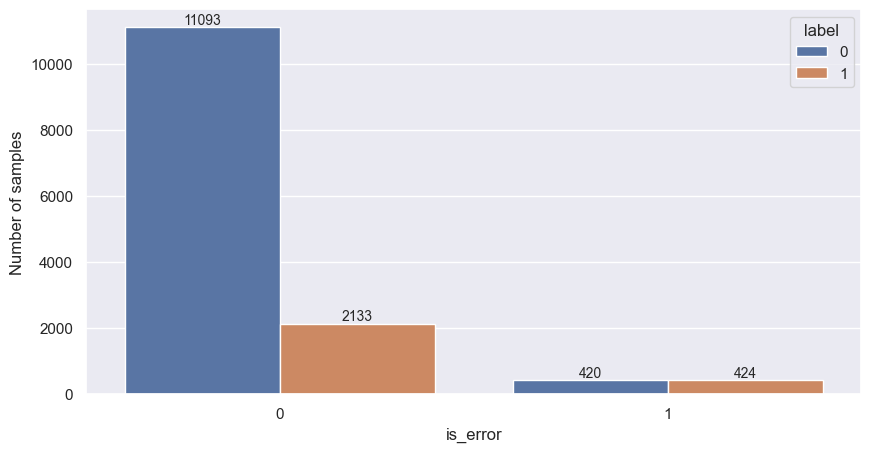

In [99]:
sns.set(font_scale=1)

plt.figure(figsize=(10, 5))
chart = sns.countplot(x="is_error", hue="label", data=error_df)
chart.set(ylabel='Number of samples',
          xlabel='is_error')

for p in chart.patches:
    chart.annotate(f'{int(p.get_height())}', 
                   (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha='center', va='bottom', fontsize=10)

plt.show()

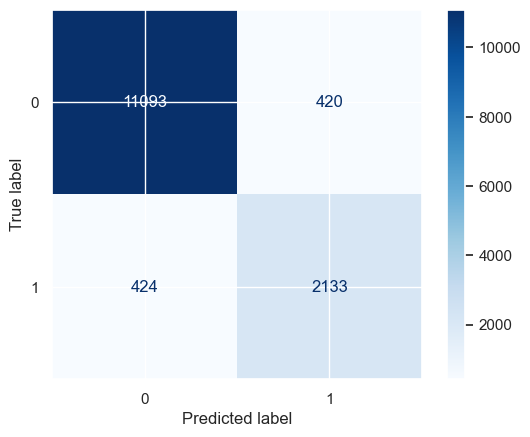

In [106]:
cm = confusion_matrix(error_df['label'], error_df['prediction'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")

plt.show()

**More than half of the errors were on students, even though they are a much smaller portion of the test set. It is much easier for our model to identify non-depressed people than depressed ones!**

**Now let's see if we can find the features that are most correlated to errors, to understand the errors better. We will train a model on the test set and look at its feature importance and SHAP values:** 

 99%|===================| 2782/2814 [00:16<00:00]        

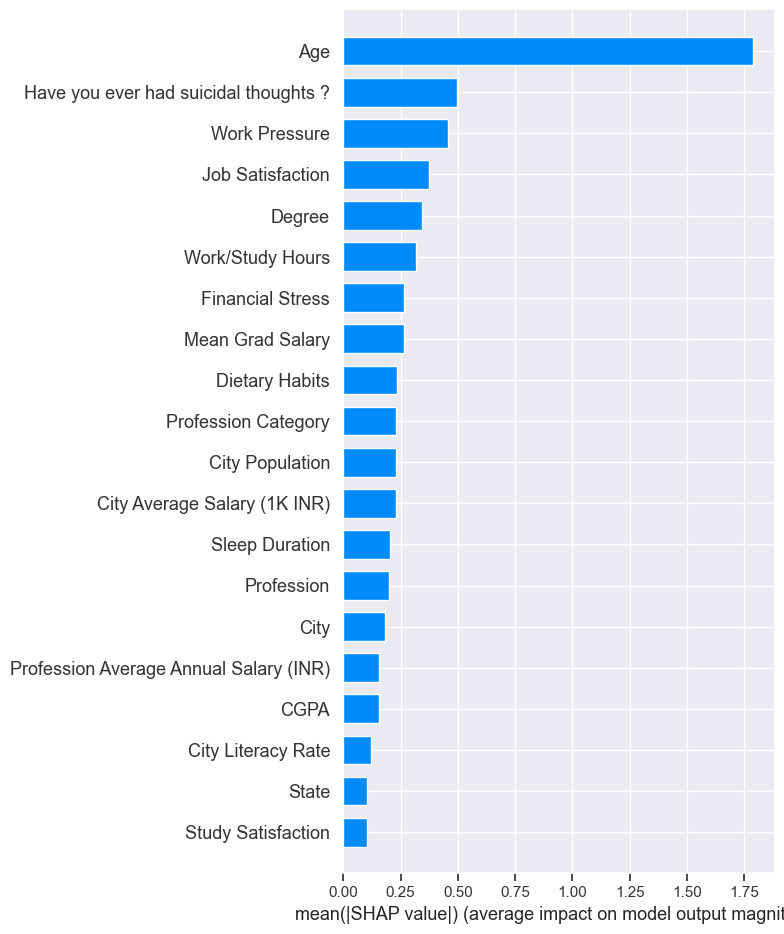

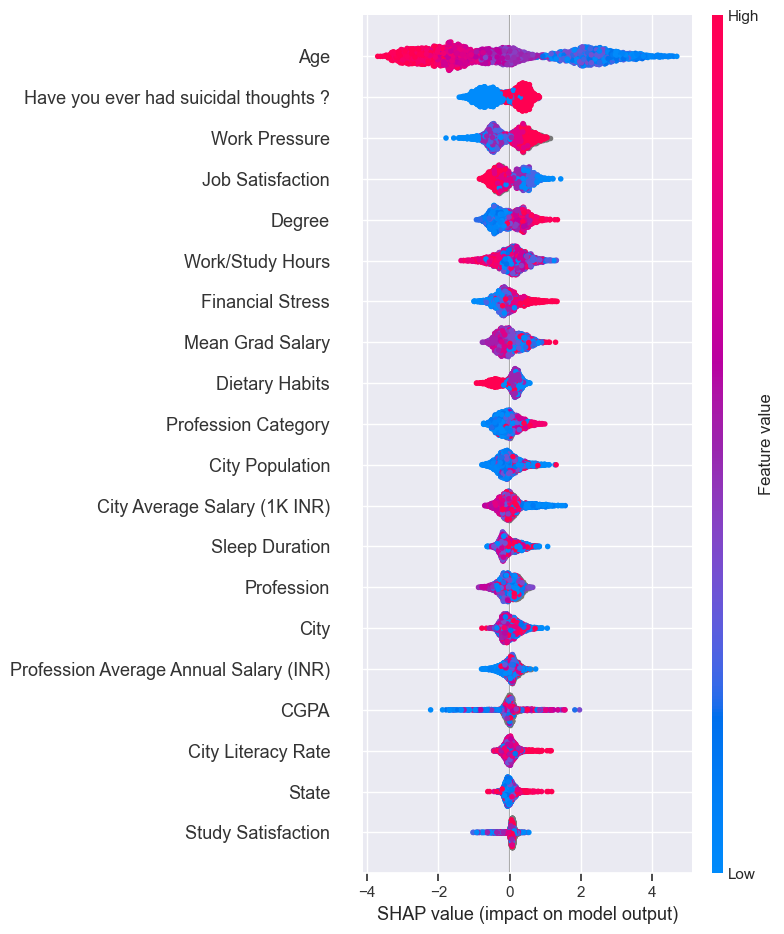

In [72]:
X_error, y_error = error_df.drop(columns=['label', 'prediction', 'is_error']), error_df['is_error']

X_train_error, X_test_error, y_train_error, y_test_error = train_test_split(X_error, y_error,
                                                                            test_size=0.2, random_state=42, stratify=y_error)

error_model = xgb.XGBClassifier(random_state=42)
error_model.fit(X_train_error, y_train_error)

importances = error_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_error.columns, 'Importance': importances})

y_pred_error = error_model.predict(X_test_error)

explainer = shap.Explainer(error_model, X_train_error)
shap_values = explainer(X_test_error)

shap.summary_plot(shap_values, X_test_error, plot_type="bar")

shap.summary_plot(shap_values, X_test_error)

**Let's look at the Age feature. It has the highest importance, the highest connection to errors. Using SHAP values, we can see that the lower the Age is - the more likely the model to make a mistake. It is likely that the mode learned to associate low age with Depression. Another example is that the model makes mistakes when dietary habits are worse. It is likely that the model learned that bad dietary habits are connected to Depression - but some people eat terribly and feel great!**

**Let's look at some graphs of feature distributions hued by is_error - first on positive examples and then negative examples:**

In [73]:
depressed_df = error_df[error_df['label'] == 1]
non_depressed_df = error_df[error_df['label'] == 0]

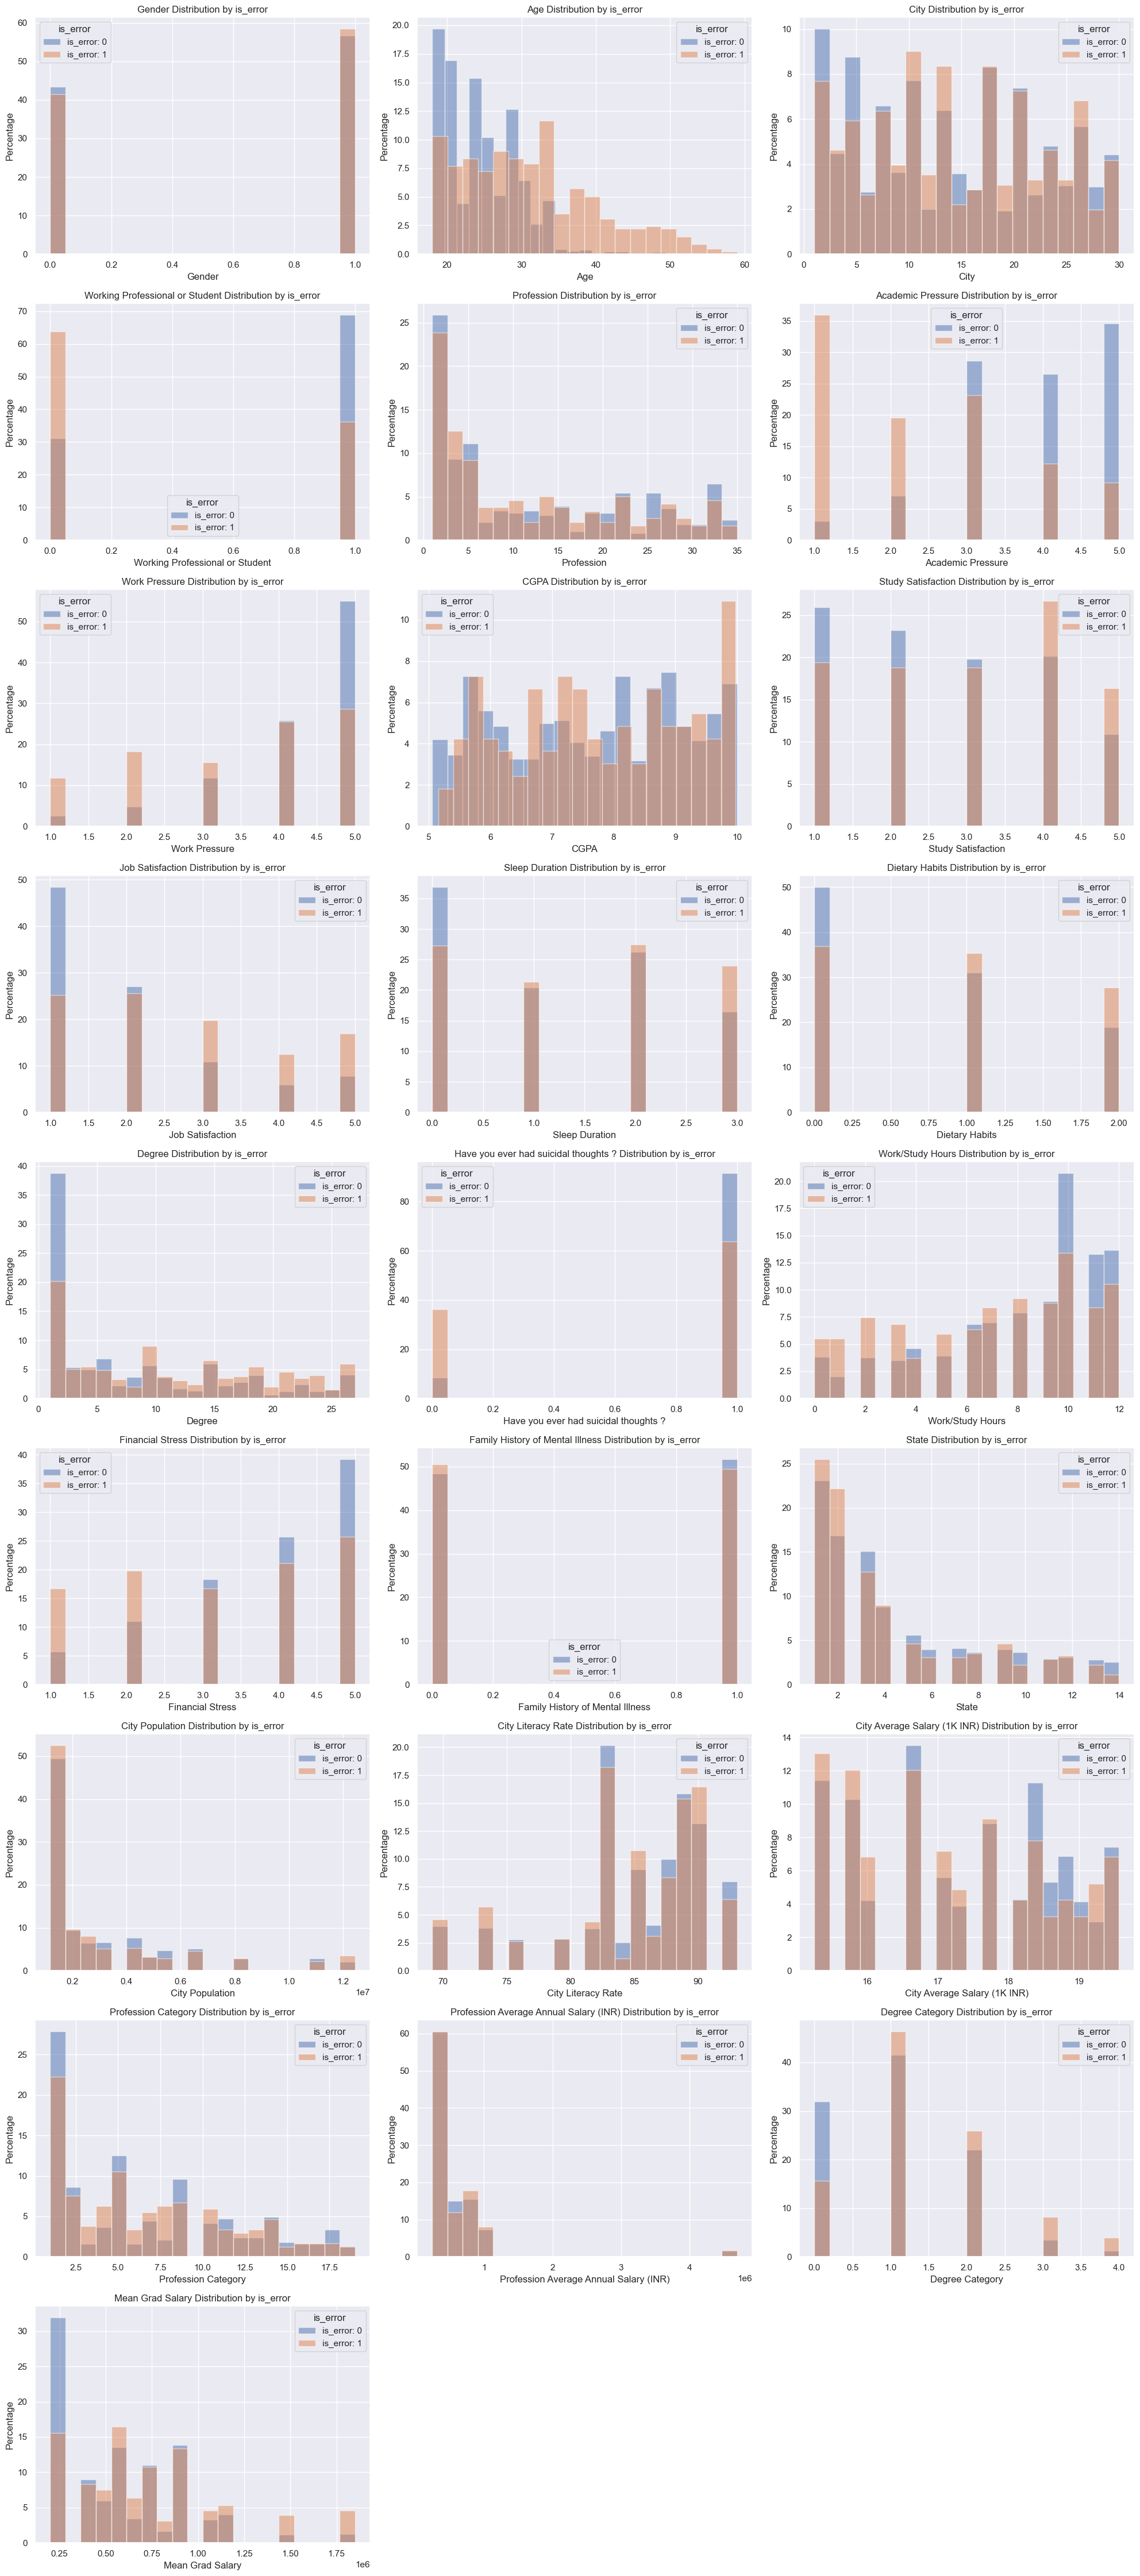

In [77]:
num_features = len(X.columns)
num_cols = 3
num_rows = (num_features // num_cols) + (1 if num_features % num_cols != 0 else 0)

plt.figure(figsize=(20, 5 * num_rows))

for i, feature in enumerate(X.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    for status in depressed_df['is_error'].unique():
        subset = depressed_df[depressed_df['is_error'] == status][feature].dropna()
        if len(subset) > 0:
            counts, bin_edges = np.histogram(subset, bins=20)
            percentages = (counts / counts.sum()) * 100
            plt.bar(bin_edges[:-1], percentages, width=np.diff(bin_edges), alpha=0.5, label=f'is_error: {status}', align='edge')
    
    plt.title(f'{feature} Distribution by is_error')
    plt.xlabel(feature)
    plt.ylabel('Percentage')
    plt.legend(title='is_error')

plt.tight_layout()
plt.show()

**A lot of the features have similar distributions, but some differ in very sensible ways. Let's look at age again (Note that these distributions are only for people with depression) - the model makes errors mostly for people with a high age. It makes a lot of sense - it learned to associate high age with people with no depression! Which is what we saw in the SHAP values as well. Another example would be Academic pressure. The model learned that people with lower academic pressure are less depressed. Which is why the model makes more mistakes here when the Academic Pressure is low!**

**The errors in this part were the false negatives. Now let's look at the non-depressed distributions and explore the false positives:**

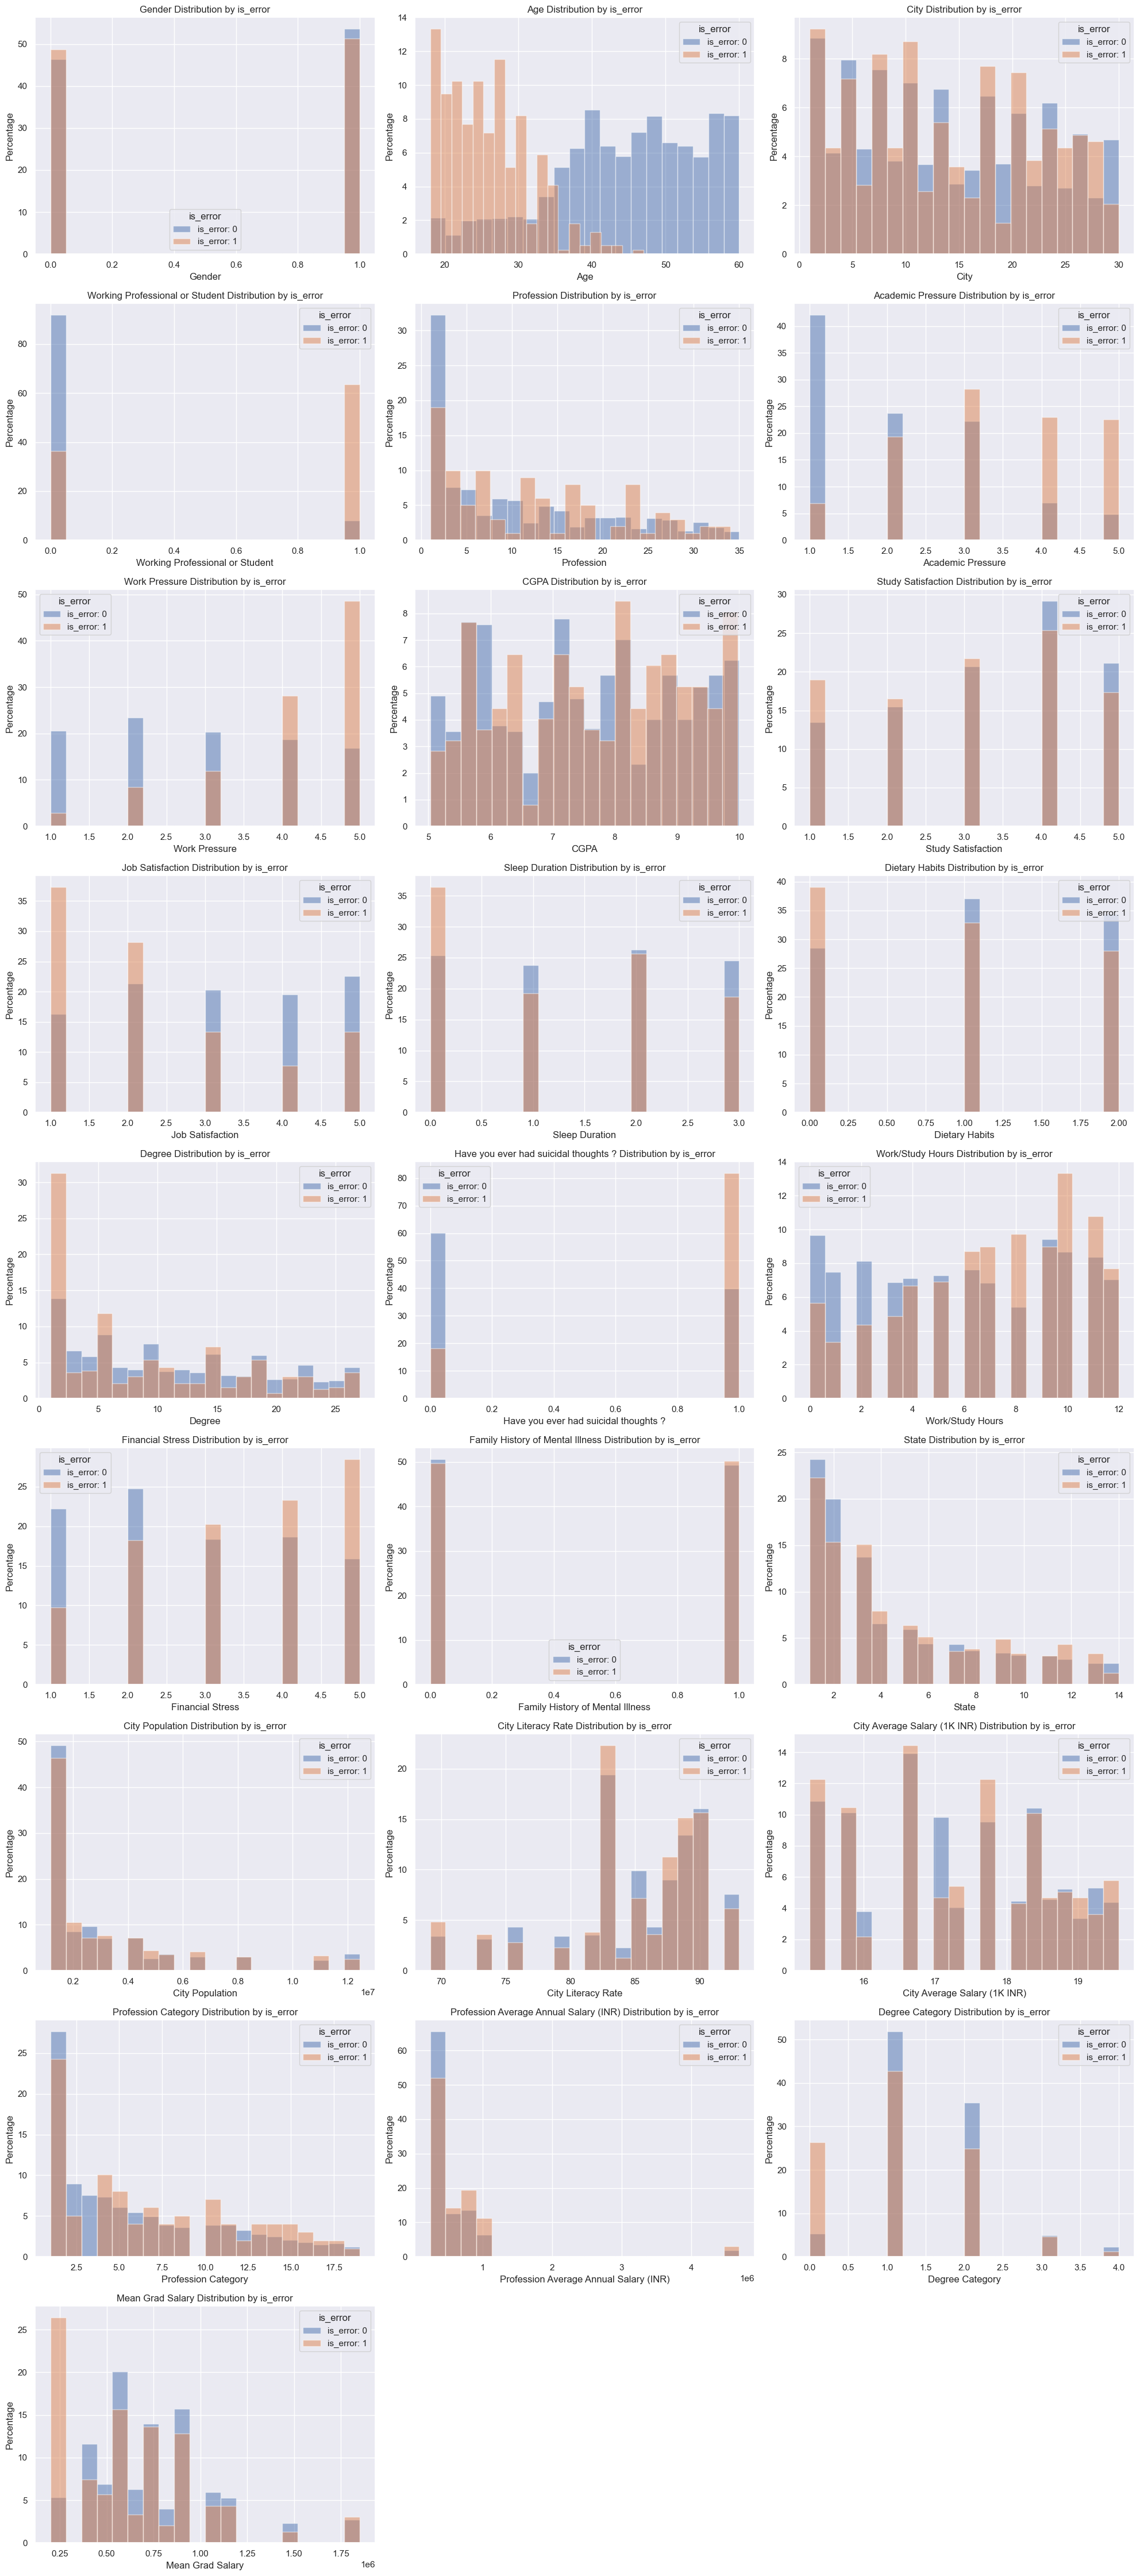

In [76]:
num_features = len(X.columns)
num_cols = 3
num_rows = (num_features // num_cols) + (1 if num_features % num_cols != 0 else 0)

plt.figure(figsize=(20, 5 * num_rows))

for i, feature in enumerate(X.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    for status in non_depressed_df['is_error'].unique():
        subset = non_depressed_df[non_depressed_df['is_error'] == status][feature].dropna()
        if len(subset) > 0:
            counts, bin_edges = np.histogram(subset, bins=20)
            percentages = (counts / counts.sum()) * 100
            plt.bar(bin_edges[:-1], percentages, width=np.diff(bin_edges), alpha=0.5, label=f'is_error: {status}', align='edge')
    
    plt.title(f'{feature} Distribution by is_error')
    plt.xlabel(feature)
    plt.ylabel('Percentage')
    plt.legend(title='is_error')

plt.tight_layout()
plt.show()

**Pretty much the reverse happens here, the root of many false positives is "bad" feature values - bad dietary habits, more pressure, low age, etc.**


# Training the final models #

In [100]:
submission_predictor = TabularPredictor(
    label='Depression',
    problem_type='binary',
    eval_metric='accuracy'
).fit(
    train_data=df,
    presets='best_quality',
    time_limit=1200,
    ag_args_fit={'num_cpus': 2},
    verbosity=2,
    num_gpus=2)

No path specified. Models will be saved in: "AutogluonModels\ag-20241123_004835"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.8.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          8
Memory Avail:       4.69 GB / 15.80 GB (29.7%)
Disk Space Avail:   68.20 GB / 475.62 GB (14.3%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=3, num_bag_folds=5, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout 

		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])  :  8 | ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', ...]
		('int', [])    :  1 | ['id']
		('object', []) : 10 | ['Name', 'Gender', 'City', 'Working Professional or Student', 'Profession', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('category', [])  : 6 | ['Name', 'City', 'Profession', 'Sleep Duration', 'Dietary Habits', ...]
		('float', [])     : 8 | ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', ...]
		('int', [])       : 1 | ['id']
		('int', ['bool']) : 4 | ['Gender', 'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
	1.0s = Fit runtime
	19 features in original data used to generate 19 features in processed data.
	Train Data (Processed) Memory Usage: 11.14 MB (0.2% of available memory)
Data preprocessing and fe

Fitting 108 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 258.2s of the 581.04s of remaining time.
Specified total num_gpus: 2, but only 0 are available. Will use 0 instead
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=2, gpus=0, memory=2.38%)
	0.9399	 = Validation score   (accuracy)
	6.13s	 = Training   runtime
	0.42s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 250.23s of the 573.08s of remaining time.
Specified total num_gpus: 2, but only 0 are available. Will use 0 instead
	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=2, gpus=0, memory=2.40%)
	0.9396	 = Validation score   (accuracy)
	5.02s	 = Training   runtime
	0.29s	 = Validation runtime
Fitting model: RandomForestGini_BAG_L2 ... Training model for up to 242.49s of the 565.34s of remaining time.
Specified total num_gpus: 2, but only 0 are ava

	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=2, gpus=0, memory=2.45%)
	0.9395	 = Validation score   (accuracy)
	6.4s	 = Training   runtime
	0.37s	 = Validation runtime
Fitting model: RandomForestGini_BAG_L4 ... Training model for up to 71.53s of the 71.48s of remaining time.
Specified total num_gpus: 2, but only 0 are available. Will use 0 instead
	0.9394	 = Validation score   (accuracy)
	39.71s	 = Training   runtime
	3.66s	 = Validation runtime
Fitting model: RandomForestEntr_BAG_L4 ... Training model for up to 27.84s of the 27.79s of remaining time.
Specified total num_gpus: 2, but only 0 are available. Will use 0 instead
	0.9389	 = Validation score   (accuracy)
	20.38s	 = Training   runtime
	2.03s	 = Validation runtime
Fitting model: WeightedEnsemble_L5 ... Training model for up to 360.0s of the 4.73s of remaining time.
	Ensemble Weights: {'CatBoost_BAG_L3': 0.75, 'XGBoost_BAG_L2': 0.1, 'CatBoost_BAG_L2': 0.05, 'ExtraTre

In [81]:
X, y = df.drop(columns=['Depression']), df['Depression']

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, 'accuracy', X, y), n_trials=50)  

best_params = study.best_params
submission_model = lgb.LGBMClassifier(**best_params)
submission_model.fit(X, y)

[I 2024-11-22 22:09:46,662] A new study created in memory with name: no-name-b306f2fe-0311-4664-bfdc-66fc48946ee6
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77


[I 2024-11-22 22:10:00,767] Trial 0 finished with value: 0.9189196872778963 and parameters: {'num_leaves': 102, 'learning_rate': 0.2857790068047196, 'numn_iterations': 934, 'max_depth': 2, 'min_data_in_leaf': 77, 'n_estimators': 278, 'reg_alpha': 0.7235484183039497, 'reg_lambda': 3.6539332827265745, 'colsample_bytree': 0.6701202853724955, 'subsample': 0.26262702936203436, 'scale_pos_weight': 4.489282926643872}. Best is trial 0 with value: 0.9189196872778963.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


[I 2024-11-22 22:10:17,500] Trial 1 finished with value: 0.908905472636816 and parameters: {'num_leaves': 152, 'learning_rate': 0.07764664597541501, 'numn_iterations': 606, 'max_depth': 6, 'min_data_in_leaf': 86, 'n_estimators': 401, 'reg_alpha': 0.07501596107251635, 'reg_lambda': 2.969752199482322, 'colsample_bytree': 0.30452014617362083, 'subsample': 0.3514067839153472, 'scale_pos_weight': 8.535262190966318}. Best is trial 0 with value: 0.9189196872778963.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86


[I 2024-11-22 22:10:37,859] Trial 2 finished with value: 0.8993390191897654 and parameters: {'num_leaves': 132, 'learning_rate': 0.020280053402870923, 'numn_iterations': 685, 'max_depth': 5, 'min_data_in_leaf': 86, 'n_estimators': 609, 'reg_alpha': 0.021030155566248983, 'reg_lambda': 5.56444629832067, 'colsample_bytree': 0.6158196568119063, 'subsample': 0.48814655721711164, 'scale_pos_weight': 8.045649344134452}. Best is trial 0 with value: 0.9189196872778963.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2024-11-22 22:10:57,357] Trial 3 finished with value: 0.9301279317697227 and parameters: {'num_leaves': 157, 'learning_rate': 0.16006040439342747, 'numn_iterations': 464, 'max_depth': 8, 'min_data_in_leaf': 9, 'n_estimators': 419, 'reg_alpha': 0.23014051860178844, 'reg_lambda': 0.005663776095989394, 'colsample_bytree': 0.44859910747568343, 'subsample': 0.3734285012439713, 'scale_pos_weight': 7.066571491583627}. Best is trial 3 with value: 0.9301279317697227.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


[I 2024-11-22 22:11:20,362] Trial 4 finished with value: 0.9203482587064677 and parameters: {'num_leaves': 169, 'learning_rate': 0.02141273240181764, 'numn_iterations': 799, 'max_depth': 5, 'min_data_in_leaf': 38, 'n_estimators': 944, 'reg_alpha': 0.0024672626932154954, 'reg_lambda': 3.602837458326788, 'colsample_bytree': 0.768107865893428, 'subsample': 0.978990570181545, 'scale_pos_weight': 4.242342747931719}. Best is trial 3 with value: 0.9301279317697227.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17


[I 2024-11-22 22:11:31,993] Trial 5 finished with value: 0.9386638237384506 and parameters: {'num_leaves': 32, 'learning_rate': 0.0987053337665617, 'numn_iterations': 495, 'max_depth': 4, 'min_data_in_leaf': 17, 'n_estimators': 684, 'reg_alpha': 0.024039902426286248, 'reg_lambda': 0.284488369439693, 'colsample_bytree': 0.3532484644159066, 'subsample': 0.5709835271256478, 'scale_pos_weight': 1.4630534942182}. Best is trial 5 with value: 0.9386638237384506.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


[I 2024-11-22 22:11:50,993] Trial 6 finished with value: 0.9278606965174129 and parameters: {'num_leaves': 184, 'learning_rate': 0.012169050221217736, 'numn_iterations': 389, 'max_depth': 7, 'min_data_in_leaf': 44, 'n_estimators': 439, 'reg_alpha': 0.23400535508607662, 'reg_lambda': 0.00463434953770112, 'colsample_bytree': 0.5416065807987082, 'subsample': 0.5012798606356392, 'scale_pos_weight': 2.9165518771654715}. Best is trial 5 with value: 0.9386638237384506.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2024-11-22 22:12:19,321] Trial 7 finished with value: 0.9141862117981521 and parameters: {'num_leaves': 111, 'learning_rate': 0.020652671823614948, 'numn_iterations': 696, 'max_depth': 11, 'min_data_in_leaf': 24, 'n_estimators': 769, 'reg_alpha': 6.365090873273223, 'reg_lambda': 0.011657619921496755, 'colsample_bytree': 0.33735655022379296, 'subsample': 0.6168887407421938, 'scale_pos_weight': 6.189731157960529}. Best is trial 5 with value: 0.9386638237384506.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13


[I 2024-11-22 22:12:24,898] Trial 8 finished with value: 0.9201492537313433 and parameters: {'num_leaves': 111, 'learning_rate': 0.27795863249535663, 'numn_iterations': 127, 'max_depth': 8, 'min_data_in_leaf': 13, 'n_estimators': 384, 'reg_alpha': 1.8835274380615048, 'reg_lambda': 9.299186404911678, 'colsample_bytree': 0.3554302393851284, 'subsample': 0.6630691093708723, 'scale_pos_weight': 6.258479398162022}. Best is trial 5 with value: 0.9386638237384506.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36


[I 2024-11-22 22:12:47,598] Trial 9 finished with value: 0.9239445628997867 and parameters: {'num_leaves': 61, 'learning_rate': 0.05284991072217044, 'numn_iterations': 684, 'max_depth': 7, 'min_data_in_leaf': 36, 'n_estimators': 799, 'reg_alpha': 4.586100400152279, 'reg_lambda': 0.005780847815667288, 'colsample_bytree': 0.8622738326256938, 'subsample': 0.923989393663711, 'scale_pos_weight': 0.22786862113251968}. Best is trial 5 with value: 0.9386638237384506.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62


[I 2024-11-22 22:12:52,961] Trial 10 finished with value: 0.9378464818763327 and parameters: {'num_leaves': 13, 'learning_rate': 0.08175477778553483, 'numn_iterations': 246, 'max_depth': 2, 'min_data_in_leaf': 62, 'n_estimators': 107, 'reg_alpha': 0.0010302413204952613, 'reg_lambda': 0.29836598563653566, 'colsample_bytree': 0.963368341254095, 'subsample': 0.7932860183142342, 'scale_pos_weight': 0.8363452825182236}. Best is trial 5 with value: 0.9386638237384506.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65


[I 2024-11-22 22:12:58,454] Trial 11 finished with value: 0.9214570007107321 and parameters: {'num_leaves': 10, 'learning_rate': 0.08490799416688356, 'numn_iterations': 243, 'max_depth': 2, 'min_data_in_leaf': 65, 'n_estimators': 121, 'reg_alpha': 0.0011021113120600892, 'reg_lambda': 0.2431712962974172, 'colsample_bytree': 0.9802164116275447, 'subsample': 0.7854836206901447, 'scale_pos_weight': 0.26370470067025953}. Best is trial 5 with value: 0.9386638237384506.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


[I 2024-11-22 22:12:59,840] Trial 12 finished with value: 0.9184719260838664 and parameters: {'num_leaves': 14, 'learning_rate': 0.0437218366972852, 'numn_iterations': 17, 'max_depth': 3, 'min_data_in_leaf': 60, 'n_estimators': 690, 'reg_alpha': 0.009882145434547561, 'reg_lambda': 0.25384568724552825, 'colsample_bytree': 0.9717888590170473, 'subsample': 0.7946433649512191, 'scale_pos_weight': 1.7618580927320924}. Best is trial 5 with value: 0.9386638237384506.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55


[I 2024-11-22 22:13:07,153] Trial 13 finished with value: 0.9342359630419331 and parameters: {'num_leaves': 65, 'learning_rate': 0.12895191580871543, 'numn_iterations': 266, 'max_depth': 4, 'min_data_in_leaf': 55, 'n_estimators': 127, 'reg_alpha': 0.005085708884200062, 'reg_lambda': 0.04528310530404898, 'colsample_bytree': 0.7526781871273887, 'subsample': 0.7316271025812557, 'scale_pos_weight': 2.168974519892193}. Best is trial 5 with value: 0.9386638237384506.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99


[I 2024-11-22 22:13:16,035] Trial 14 finished with value: 0.9274271499644634 and parameters: {'num_leaves': 36, 'learning_rate': 0.12284002355997112, 'numn_iterations': 379, 'max_depth': 3, 'min_data_in_leaf': 99, 'n_estimators': 958, 'reg_alpha': 0.02303164158124787, 'reg_lambda': 0.43994774574335704, 'colsample_bytree': 0.4849386616671389, 'subsample': 0.5760932406147258, 'scale_pos_weight': 3.232638968928633}. Best is trial 5 with value: 0.9386638237384506.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2024-11-22 22:13:30,799] Trial 15 finished with value: 0.9388059701492537 and parameters: {'num_leaves': 49, 'learning_rate': 0.03763263478241606, 'numn_iterations': 521, 'max_depth': 4, 'min_data_in_leaf': 24, 'n_estimators': 533, 'reg_alpha': 0.002407577635730546, 'reg_lambda': 0.04765398604732469, 'colsample_bytree': 0.8552453014778323, 'subsample': 0.8671774282800151, 'scale_pos_weight': 1.3509677610637885}. Best is trial 15 with value: 0.9388059701492537.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24


[I 2024-11-22 22:13:52,385] Trial 16 finished with value: 0.9367519545131486 and parameters: {'num_leaves': 63, 'learning_rate': 0.03733310845953482, 'numn_iterations': 530, 'max_depth': 10, 'min_data_in_leaf': 24, 'n_estimators': 577, 'reg_alpha': 0.05121416269156169, 'reg_lambda': 0.043222252302277206, 'colsample_bytree': 0.841387562815777, 'subsample': 0.90215905839979, 'scale_pos_weight': 1.800546810422283}. Best is trial 15 with value: 0.9388059701492537.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[I 2024-11-22 22:14:20,269] Trial 17 finished with value: 0.9252096659559346 and parameters: {'num_leaves': 47, 'learning_rate': 0.03177830873134086, 'numn_iterations': 877, 'max_depth': 5, 'min_data_in_leaf': 20, 'n_estimators': 693, 'reg_alpha': 0.004534768906780728, 'reg_lambda': 0.0011749212858110896, 'colsample_bytree': 0.6542936303164925, 'subsample': 0.4873392159008822, 'scale_pos_weight': 3.6912548705487715}. Best is trial 15 with value: 0.9388059701492537.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


[I 2024-11-22 22:14:37,069] Trial 18 finished with value: 0.9364889836531628 and parameters: {'num_leaves': 82, 'learning_rate': 0.010725145618005152, 'numn_iterations': 536, 'max_depth': 4, 'min_data_in_leaf': 29, 'n_estimators': 836, 'reg_alpha': 0.013111751125593554, 'reg_lambda': 0.8747734893349282, 'colsample_bytree': 0.870571321145238, 'subsample': 0.6941373016257687, 'scale_pos_weight': 1.3423355640413581}. Best is trial 15 with value: 0.9388059701492537.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2024-11-22 22:14:46,558] Trial 19 finished with value: 0.9163113006396589 and parameters: {'num_leaves': 37, 'learning_rate': 0.18768234600372471, 'numn_iterations': 377, 'max_depth': 4, 'min_data_in_leaf': 9, 'n_estimators': 499, 'reg_alpha': 0.04003456608928281, 'reg_lambda': 0.06452838966255844, 'colsample_bytree': 0.4477545036220422, 'subsample': 0.8798733721051267, 'scale_pos_weight': 5.388885827387686}. Best is trial 15 with value: 0.9388059701492537.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46


[I 2024-11-22 22:15:10,864] Trial 20 finished with value: 0.9154939587775409 and parameters: {'num_leaves': 83, 'learning_rate': 0.06073268336785777, 'numn_iterations': 592, 'max_depth': 9, 'min_data_in_leaf': 46, 'n_estimators': 663, 'reg_alpha': 0.0026539691637280437, 'reg_lambda': 0.01715417433255058, 'colsample_bytree': 0.5559787322324894, 'subsample': 0.5499951344959776, 'scale_pos_weight': 9.934709648520222}. Best is trial 15 with value: 0.9388059701492537.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71


[I 2024-11-22 22:15:16,968] Trial 21 finished with value: 0.9387348969438521 and parameters: {'num_leaves': 27, 'learning_rate': 0.08734861722438553, 'numn_iterations': 271, 'max_depth': 2, 'min_data_in_leaf': 71, 'n_estimators': 195, 'reg_alpha': 0.001217956345987868, 'reg_lambda': 0.11908536114258204, 'colsample_bytree': 0.9089635603104032, 'subsample': 0.789897911549289, 'scale_pos_weight': 1.1415474264381884}. Best is trial 15 with value: 0.9388059701492537.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71


[I 2024-11-22 22:15:27,937] Trial 22 finished with value: 0.9308244491826582 and parameters: {'num_leaves': 33, 'learning_rate': 0.10043621351187951, 'numn_iterations': 447, 'max_depth': 3, 'min_data_in_leaf': 71, 'n_estimators': 232, 'reg_alpha': 0.002153024939725931, 'reg_lambda': 0.14339749846743877, 'colsample_bytree': 0.7812062394058372, 'subsample': 0.8694631021153961, 'scale_pos_weight': 2.6822400233207295}. Best is trial 15 with value: 0.9388059701492537.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2024-11-22 22:15:32,904] Trial 23 finished with value: 0.9389339019189766 and parameters: {'num_leaves': 29, 'learning_rate': 0.06710191414093625, 'numn_iterations': 102, 'max_depth': 6, 'min_data_in_leaf': 32, 'n_estimators': 289, 'reg_alpha': 0.006739282747595636, 'reg_lambda': 0.10282560406020787, 'colsample_bytree': 0.9050968307745277, 'subsample': 0.7281007865254248, 'scale_pos_weight': 0.914391101406543}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2024-11-22 22:15:36,878] Trial 24 finished with value: 0.9350817341862119 and parameters: {'num_leaves': 54, 'learning_rate': 0.02834332903070059, 'numn_iterations': 72, 'max_depth': 6, 'min_data_in_leaf': 33, 'n_estimators': 278, 'reg_alpha': 0.006003213608839902, 'reg_lambda': 0.9639504490933737, 'colsample_bytree': 0.9176032518553499, 'subsample': 0.7419243679080547, 'scale_pos_weight': 1.04835687253465}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49


[I 2024-11-22 22:15:44,649] Trial 25 finished with value: 0.9325941719971571 and parameters: {'num_leaves': 80, 'learning_rate': 0.05966350701548416, 'numn_iterations': 159, 'max_depth': 6, 'min_data_in_leaf': 49, 'n_estimators': 200, 'reg_alpha': 0.0018850496137198045, 'reg_lambda': 0.09918305309544678, 'colsample_bytree': 0.9006760928116978, 'subsample': 0.8203548009521785, 'scale_pos_weight': 2.3162563929396214}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


[I 2024-11-22 22:15:55,448] Trial 26 finished with value: 0.9182587064676617 and parameters: {'num_leaves': 24, 'learning_rate': 0.04736176565357811, 'numn_iterations': 306, 'max_depth': 12, 'min_data_in_leaf': 42, 'n_estimators': 326, 'reg_alpha': 0.00903202702089163, 'reg_lambda': 0.021989673268636222, 'colsample_bytree': 0.8157050842206194, 'subsample': 0.9489902677316723, 'scale_pos_weight': 0.19112464904845772}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-11-22 22:15:59,848] Trial 27 finished with value: 0.9210021321961619 and parameters: {'num_leaves': 74, 'learning_rate': 0.0717436566249827, 'numn_iterations': 154, 'max_depth': 3, 'min_data_in_leaf': 5, 'n_estimators': 495, 'reg_alpha': 0.0031499519931098407, 'reg_lambda': 0.1150653558546318, 'colsample_bytree': 0.7125092149387896, 'subsample': 0.844841172151045, 'scale_pos_weight': 3.6381139026314484}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2024-11-22 22:16:12,275] Trial 28 finished with value: 0.9373063255152807 and parameters: {'num_leaves': 47, 'learning_rate': 0.028263319232728443, 'numn_iterations': 318, 'max_depth': 5, 'min_data_in_leaf': 28, 'n_estimators': 196, 'reg_alpha': 0.0010904203785528713, 'reg_lambda': 0.032641585179233365, 'colsample_bytree': 0.929637175917723, 'subsample': 0.699496498133671, 'scale_pos_weight': 0.6950287159276686}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79


Found `num_iterations` in params. Will use it instead of argument
[I 2024-11-22 22:16:13,665] Trial 29 finished with value: 0.8182871357498224 and parameters: {'num_leaves': 98, 'learning_rate': 0.03989591698152245, 'numn_iterations': 12, 'max_depth': 2, 'min_data_in_leaf': 79, 'n_estimators': 305, 'reg_alpha': 0.173029374120908, 'reg_lambda': 0.8017308565693437, 'colsample_bytree': 0.80297396256058, 'subsample': 0.9801319141748359, 'scale_pos_weight': 4.788778326789335}. Best is trial 23 with value: 0.9389339019189766.


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79


suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76


[I 2024-11-22 22:16:18,286] Trial 30 finished with value: 0.920817341862118 and parameters: {'num_leaves': 24, 'learning_rate': 0.015279085044294857, 'numn_iterations': 205, 'max_depth': 2, 'min_data_in_leaf': 76, 'n_estimators': 353, 'reg_alpha': 0.7211983390644914, 'reg_lambda': 0.08737533852653605, 'colsample_bytree': 0.7126917892034909, 'subsample': 0.7570014881601678, 'scale_pos_weight': 2.0305474588033223}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2024-11-22 22:16:22,486] Trial 31 finished with value: 0.9388415067519545 and parameters: {'num_leaves': 27, 'learning_rate': 0.11004725787719334, 'numn_iterations': 103, 'max_depth': 4, 'min_data_in_leaf': 18, 'n_estimators': 233, 'reg_alpha': 0.019918321039335222, 'reg_lambda': 0.17715347972540904, 'colsample_bytree': 0.9972648410093861, 'subsample': 0.6304214177685842, 'scale_pos_weight': 1.195889024257948}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2024-11-22 22:16:27,556] Trial 32 finished with value: 0.9378678038379531 and parameters: {'num_leaves': 45, 'learning_rate': 0.19459377638529113, 'numn_iterations': 104, 'max_depth': 6, 'min_data_in_leaf': 18, 'n_estimators': 243, 'reg_alpha': 0.006587580332323823, 'reg_lambda': 0.17215483003161683, 'colsample_bytree': 0.9930134362029396, 'subsample': 0.6352426165587925, 'scale_pos_weight': 1.1575826692522835}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


[I 2024-11-22 22:16:34,471] Trial 33 finished with value: 0.9316915422885572 and parameters: {'num_leaves': 23, 'learning_rate': 0.11952386541412835, 'numn_iterations': 196, 'max_depth': 4, 'min_data_in_leaf': 32, 'n_estimators': 176, 'reg_alpha': 0.015632280978973345, 'reg_lambda': 0.48310691468618894, 'colsample_bytree': 0.9217396178749298, 'subsample': 0.696306882352505, 'scale_pos_weight': 2.534473694347067}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


[I 2024-11-22 22:16:46,403] Trial 34 finished with value: 0.9373773987206823 and parameters: {'num_leaves': 132, 'learning_rate': 0.06678495474235234, 'numn_iterations': 323, 'max_depth': 5, 'min_data_in_leaf': 25, 'n_estimators': 472, 'reg_alpha': 0.1125007709362885, 'reg_lambda': 0.06492345618806, 'colsample_bytree': 0.8835949643627643, 'subsample': 0.8445614223798547, 'scale_pos_weight': 0.6548249731020434}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94


[I 2024-11-22 22:16:49,209] Trial 35 finished with value: 0.9347903340440654 and parameters: {'num_leaves': 22, 'learning_rate': 0.09678588154102521, 'numn_iterations': 69, 'max_depth': 3, 'min_data_in_leaf': 94, 'n_estimators': 266, 'reg_alpha': 0.0037321371282511982, 'reg_lambda': 0.029962892110962615, 'colsample_bytree': 0.9410395872908128, 'subsample': 0.6486806225881473, 'scale_pos_weight': 1.5283718913159219}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2024-11-22 22:16:53,175] Trial 36 finished with value: 0.9199289267945986 and parameters: {'num_leaves': 43, 'learning_rate': 0.15245458026701889, 'numn_iterations': 73, 'max_depth': 8, 'min_data_in_leaf': 15, 'n_estimators': 345, 'reg_alpha': 0.0016865916574197312, 'reg_lambda': 1.8553579196899612, 'colsample_bytree': 0.8272263453062634, 'subsample': 0.43349670784198235, 'scale_pos_weight': 4.162721942690044}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38


[I 2024-11-22 22:17:12,441] Trial 37 finished with value: 0.9283653162757639 and parameters: {'num_leaves': 95, 'learning_rate': 0.05356306973290719, 'numn_iterations': 608, 'max_depth': 5, 'min_data_in_leaf': 38, 'n_estimators': 149, 'reg_alpha': 0.008981454084109433, 'reg_lambda': 1.6851363345141237, 'colsample_bytree': 0.89129293201913, 'subsample': 0.3431997183669646, 'scale_pos_weight': 3.118678635707707}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54


[I 2024-11-22 22:17:30,674] Trial 38 finished with value: 0.9129921819474058 and parameters: {'num_leaves': 59, 'learning_rate': 0.07546609563465066, 'numn_iterations': 446, 'max_depth': 7, 'min_data_in_leaf': 54, 'n_estimators': 398, 'reg_alpha': 0.058278327584512075, 'reg_lambda': 0.010791405236490545, 'colsample_bytree': 0.9962736587051149, 'subsample': 0.2628790515123476, 'scale_pos_weight': 8.071347147053054}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2024-11-22 22:17:37,244] Trial 39 finished with value: 0.9367945984363895 and parameters: {'num_leaves': 30, 'learning_rate': 0.03594941548145417, 'numn_iterations': 192, 'max_depth': 4, 'min_data_in_leaf': 11, 'n_estimators': 531, 'reg_alpha': 0.03605897121308538, 'reg_lambda': 0.16038373497460884, 'colsample_bytree': 0.608059818405895, 'subsample': 0.6139994117798505, 'scale_pos_weight': 0.763875414308216}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85


[I 2024-11-22 22:17:42,244] Trial 40 finished with value: 0.9171499644633974 and parameters: {'num_leaves': 71, 'learning_rate': 0.22358952728271758, 'numn_iterations': 114, 'max_depth': 6, 'min_data_in_leaf': 85, 'n_estimators': 434, 'reg_alpha': 0.017837803144569873, 'reg_lambda': 0.06462712236831676, 'colsample_bytree': 0.7318618778168092, 'subsample': 0.7571337660862651, 'scale_pos_weight': 5.417543646398869}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21


[I 2024-11-22 22:18:06,098] Trial 41 finished with value: 0.9380597014925373 and parameters: {'num_leaves': 53, 'learning_rate': 0.09057613466303005, 'numn_iterations': 760, 'max_depth': 4, 'min_data_in_leaf': 21, 'n_estimators': 601, 'reg_alpha': 0.02591706822046446, 'reg_lambda': 0.4149585086122595, 'colsample_bytree': 0.9380165551253782, 'subsample': 0.5711126610909375, 'scale_pos_weight': 1.3522444161204288}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


[I 2024-11-22 22:18:20,399] Trial 42 finished with value: 0.9371855010660981 and parameters: {'num_leaves': 17, 'learning_rate': 0.11487622147817539, 'numn_iterations': 649, 'max_depth': 3, 'min_data_in_leaf': 15, 'n_estimators': 637, 'reg_alpha': 0.1012248806012911, 'reg_lambda': 0.21530572393894445, 'colsample_bytree': 0.3845309556609712, 'subsample': 0.5160060822313035, 'scale_pos_weight': 1.7768324545859318}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2024-11-22 22:18:38,839] Trial 43 finished with value: 0.9057569296375266 and parameters: {'num_leaves': 33, 'learning_rate': 0.16076145266501432, 'numn_iterations': 947, 'max_depth': 2, 'min_data_in_leaf': 7, 'n_estimators': 823, 'reg_alpha': 0.0018022201136504538, 'reg_lambda': 0.3774005736211214, 'colsample_bytree': 0.842007439072686, 'subsample': 0.6761808375975531, 'scale_pos_weight': 0.12186675444247996}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18


[I 2024-11-22 22:18:55,005] Trial 44 finished with value: 0.9370078180525943 and parameters: {'num_leaves': 41, 'learning_rate': 0.10071522970993373, 'numn_iterations': 468, 'max_depth': 5, 'min_data_in_leaf': 18, 'n_estimators': 890, 'reg_alpha': 0.003682892689762488, 'reg_lambda': 0.09344089242974546, 'colsample_bytree': 0.9496262970907626, 'subsample': 0.7204975066818571, 'scale_pos_weight': 0.6454860205724631}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


[I 2024-11-22 22:19:11,012] Trial 45 finished with value: 0.9336247334754797 and parameters: {'num_leaves': 198, 'learning_rate': 0.13999360277491993, 'numn_iterations': 571, 'max_depth': 4, 'min_data_in_leaf': 28, 'n_estimators': 761, 'reg_alpha': 0.011476369289489087, 'reg_lambda': 0.6316930869046256, 'colsample_bytree': 0.6050403036993776, 'subsample': 0.6207660771514094, 'scale_pos_weight': 2.308265214113521}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


[I 2024-11-22 22:19:21,145] Trial 46 finished with value: 0.9385927505330491 and parameters: {'num_leaves': 10, 'learning_rate': 0.0663510071879215, 'numn_iterations': 419, 'max_depth': 7, 'min_data_in_leaf': 33, 'n_estimators': 225, 'reg_alpha': 0.007122932982082872, 'reg_lambda': 0.25781016354770286, 'colsample_bytree': 0.6859521989568255, 'subsample': 0.7850708668823506, 'scale_pos_weight': 1.471288771310188}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


[I 2024-11-22 22:19:29,551] Trial 47 finished with value: 0.9287348969438523 and parameters: {'num_leaves': 29, 'learning_rate': 0.04723438047848596, 'numn_iterations': 282, 'max_depth': 6, 'min_data_in_leaf': 42, 'n_estimators': 760, 'reg_alpha': 0.03329527424778169, 'reg_lambda': 0.043643407584453044, 'colsample_bytree': 0.31946863743138454, 'subsample': 0.5927067399283923, 'scale_pos_weight': 2.9668340179564607}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23


[I 2024-11-22 22:19:38,643] Trial 48 finished with value: 0.9048542999289267 and parameters: {'num_leaves': 121, 'learning_rate': 0.08643968137294739, 'numn_iterations': 354, 'max_depth': 3, 'min_data_in_leaf': 23, 'n_estimators': 544, 'reg_alpha': 0.0014336365376657638, 'reg_lambda': 0.01168879433615091, 'colsample_bytree': 0.9671307517134787, 'subsample': 0.5317309295575753, 'scale_pos_weight': 6.522143575524158}. Best is trial 23 with value: 0.9389339019189766.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


[I 2024-11-22 22:19:48,100] Trial 49 finished with value: 0.935543710021322 and parameters: {'num_leaves': 53, 'learning_rate': 0.11099947003871659, 'numn_iterations': 232, 'max_depth': 7, 'min_data_in_leaf': 12, 'n_estimators': 167, 'reg_alpha': 0.0047363900204027195, 'reg_lambda': 0.1474879710206284, 'colsample_bytree': 0.8662296567855704, 'subsample': 0.9482821880346641, 'scale_pos_weight': 1.8931016026368677}. Best is trial 23 with value: 0.9389339019189766.


[LightGBM] [Warning] Unknown parameter: numn_iterations
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32


LGBMClassifier(colsample_bytree=0.9050968307745277,
               learning_rate=0.06710191414093625, max_depth=6,
               min_data_in_leaf=32, n_estimators=289, num_leaves=29,
               numn_iterations=102, reg_alpha=0.006739282747595636,
               reg_lambda=0.10282560406020787,
               scale_pos_weight=0.914391101406543,
               subsample=0.7281007865254248)

In [79]:
test = pd.read_csv('test.csv')

test.drop(columns=['id', 'Name'], inplace=True)

test = pd.merge(test, cities_df, on='City', how='left')
test = pd.merge(test, profession_df, on='Profession', how='left')
test = pd.merge(test, degrees_df, on='Degree', how='left')

test['Gender'] = test['Gender'].replace({'Female': 0, 'Male': 1})
test['Age'] = test['Age'].apply(int)

sleep_duration_map = {
    'Less than 5 hours': 0,
    '5-6 hours': 1,
    '7-8 hours': 2,
    'More than 8 hours': 3,
    '3-4 hours': 0,
    '6-7 hours': 1,
    '4-5 hours': 0,
    '2-3 hours': 0,
    '4-6 hours': 0,
    '6-8 hours': 2
}

test['Working Professional or Student'] = test['Working Professional or Student'].replace({'Working Professional': 0, 'Student': 1})
test['Sleep Duration'] = test['Sleep Duration'].map(sleep_duration_map).fillna(np.nan)

dietary_map = {
    'Unhealthy': 0,
    'Moderate': 1,
    'Healthy': 2
}

test['Dietary Habits'] = test['Dietary Habits'].map(dietary_map).fillna(np.nan)
test['Have you ever had suicidal thoughts ?'] = test['Have you ever had suicidal thoughts ?'].replace({'No': 0, 'Yes': 1})
test['Family History of Mental Illness'] = test['Family History of Mental Illness'].replace({'No': 0, 'Yes': 1})

degree_categories = {'School': 0,
                        'Undergraduate': 1,
                        'Postgraduate': 2,
                        'Professional': 3,
                        'Doctoral': 4}

test['Degree Category'] = test['Degree Category'].map(degree_categories).fillna(np.nan)

top_k_values = test['Profession'].value_counts().nlargest(35).index
mapping = {profession: idx for idx, profession in enumerate(top_k_values, start=1)}
test['Profession'] = test['Profession'].apply(lambda x: mapping.get(x, np.nan))

top_k_values = test['City'].value_counts().nlargest(30).index
mapping = {profession: idx for idx, profession in enumerate(top_k_values, start=1)}
test['City'] = test['City'].apply(lambda x: mapping.get(x, np.nan))

top_k_values = test['State'].value_counts().nlargest(14).index
mapping = {profession: idx for idx, profession in enumerate(top_k_values, start=1)}
test['State'] = test['State'].apply(lambda x: mapping.get(x, np.nan))

top_k_values = test['Profession Category'].value_counts().nlargest(19).index
mapping = {profession: idx for idx, profession in enumerate(top_k_values, start=1)}
test['Profession Category'] = test['Profession Category'].apply(lambda x: mapping.get(x, np.nan))

top_k_values = test['Degree'].value_counts().nlargest(27).index
mapping = {profession: idx for idx, profession in enumerate(top_k_values, start=1)}
test['Degree'] = test['Degree'].apply(lambda x: mapping.get(x, np.nan))

test['Mean Grad Salary'] = (test['Grad Salary Lower Bound'] + test['Grad Salary Upper Bound']) / 2
test.drop(columns=['Grad Salary Lower Bound', 'Grad Salary Upper Bound'], inplace=True)

In [101]:
y_pred = submission_predictor.predict(test)
sub = pd.read_csv('sample_submission.csv')
sub['Depression'] = y_pred

sub.to_csv('final_submission_autogluon.csv', index=False)

2024-11-23 03:13:48,577	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.


**Kaggle submission accuracy: 94.141%**

In [82]:
y_pred = submission_model.predict(test)
sub = pd.read_csv('sample_submission.csv')
sub['Depression'] = y_pred

sub.to_csv('final_submission_lgbm.csv', index=False)

**Kaggle submission accuracy: 94.243%**

# Summary and Conclusions #

**In this project we explored Mental Health Data and tried to build the best possible model to predict our target variable -Depression.
We started by loading, processing and cleaning the data, finding missing values, dropping duplicates, etc.
We then added supplementary features such as information about the cities in which people live, salaries of their profession and information about their degrees and academic backgrounds.
We proceeded by doing EDA - exploratory data analysis, and found deep connections between features and our target variable of depression.
We used featuring engineering so that our model would learn in an effective way. We also saw which features are redundant and which features are not correlated to the target variable. We did statistical tests, such as U-test and chi-squared on features,  to see which features may not have information about the target variable and are redundant.
We plotted a PCA graph hued by our target variable to see if there is a possibility for separation of the data.**

**We tested out different models with varying permutations - we tried different imputation strategies, removing and keeping our outliers, dropping redundant features and not dropping them, using one-hot encoding on categorical features, etc.
We also trained different models such as XGBoost, CatBoost and LightGBM.
We proceeded by doing hyperparameter optimization and training two different models - one with all the data and one split for students and workers. We looked at the feature importance to find out which features have the most weight on the decision of the model.**

**We conducted error analysis to see why our model made mistakes and which features contributed the most to errors.**

**Finally we trained our final models submitted the results.**

**Our analysis found significant correlations between depression and features like age, dietary habits, work pressure etc., and we discovered patterns showing that individuals in a certain age group, status and lifestyle are more prone to have depression.
The feature importance of our model showed that age, work/academic pressure and financial stress were among the most influencial factors for depression.**

**Metrics such as AUC-ROC, F1-score and accuracy indicated that our model is competitive in handling the dataset's binary classification mission.**

**The model made errors - and we saw that one of the most contributing features to this fact was Age. However, since we cannot remove this feature (it is very important for the model), we will have to deal with these losses. 
Our model's final accuracy in the competition was 94.243%, compared to the highest accuracy of the #1 place which was 94.488%. A total of 0.24% differnce in accuracy between our model and the best model that exists. Since it's so little, it's safe it assume that not much more can be extracted from the data we have - people could have lied in the surveys, more features could be needed to make a better prediction (or more samples) etc.**

**Why did some people achieve a higher accuracy? Could be better feature enineering and handling, could be more computational power and more bagging of many models available to them, could be that people copied good solutions (it happens a lot, I checked), could be optimizing solutions of other people and spamming submitions, etc.
For our case and most practical uses, it is probably not necessary.**

**What could've been done to improve our model? Here are just a few ideas:**
1. Incorporating more external datasets to provide a broader context for the findings and improve generalizability.
2. Exploring more relationships between feautres and creating better features.
3. Trying to use SMOTE or pseudo-labling to train on more data.